#  Analysis Part 3: Scan over the NN settings

Johann Brehmer, Felix Kling, Kyle Cranmer 2018

In this tutorial we'll demonstrate how to use MadMiner to generate train and test samples for the Information Geometry methods introduced in the following papers:
- J. Brehmer, K. Cranmer, F. Kling, T. Plehn: ["Better Higgs Measurements Through Information Geometry"](https://arxiv.org/abs/1612.05261)
- J. Brehmer, F. Kling, T. Plehn, T.M.P. Tait: ["Better Higgs-CP Tests Through Information Geometry"](https://arxiv.org/abs/1712.02350)

## 0. Preparations

In [1]:
import sys
import os
madminer_src_path = "/Users/felixkling/Documents/GitHub/madminer"
sys.path.append(madminer_src_path)

from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import math
import matplotlib
import random
import pickle
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.cm as cm
% matplotlib inline

from madminer.fisherinformation import FisherInformation
from madminer.fisherinformation import project_information,profile_information

from madminer.plotting import plot_fisher_information_contours_2d
from madminer.plotting import plot_fisherinfo_barplot
from madminer.plotting import plot_distribution_of_information

from madminer.sampling import SampleAugmenter
from madminer.sampling import constant_benchmark_theta, multiple_benchmark_thetas
from madminer.sampling import constant_morphing_theta, multiple_morphing_thetas, random_morphing_thetas
from madminer.ml import MLForge, EnsembleForge

from sklearn.metrics import mean_squared_error

## 1. Define Path and Files

In [2]:
usenamein='100k'
nsamples=50000

useinputdata = 'data/madminer_wgamma_observables_'+usenamein+'.h5'
usesamplesdir = 'data/scan_'+usenamein+'/'
usemodelsdir = 'models/scan_'+usenamein+'/'
usesummaryfile = 'data/scan_'+usenamein+'/summary.npy'

## 2. Make (unweighted) training and test samples with augmented data

In [3]:
#create sample augmenter
sa = SampleAugmenter(useinputdata, debug=False)

#augment train sample
x, theta, t_xz = sa.extract_samples_train_local(
    theta=constant_benchmark_theta('sm'),
    n_samples=nsamples,
    folder='./'+usesamplesdir,
#    test_split=None,
    filename='train'
)

#augment test sample
x, theta, t_xz = sa.extract_samples_train_local(
    theta=constant_benchmark_theta('sm'),
    n_samples=nsamples,
    folder='./'+usesamplesdir,
#    test_split=None,
    filename='test',
    switch_train_test_events=True
)


00:42  
00:42  ------------------------------------------------------------
00:42  |                                                          |
00:42  |  MadMiner v2018.11.09                                    |
00:42  |                                                          |
00:42  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
00:42  |                                                          |
00:42  ------------------------------------------------------------
00:42  
00:42  Loading data from data/madminer_wgamma_observables_100k.h5
00:42  Found 2 parameters:
00:42     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
00:42     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
00:42  Found 6 benchmarks:
00:42     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
00:42     w: CWL2 = 20.00, CPWL2 = 0.00e+00
00:42     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
00:42     morphing_basis_vector_3: CWL2 = 17.32, CPW

## 3. Scan

### 3a) Define Settings

In [4]:
#Number of epochs
choices_epochs = [10,20,50,100]
choices_nhidden = [2,3,4,5,6,7]
choices_nneuron = [20,50,100,200]
choices_activation = ['tanh', 'sigmoid', 'relu']
choices_regularization = [None,1,0.1,0.01,0.001]
choices_lrinitial = [0.1,0.01,0.001,0.0001]
choices_lrratio = [1,10,100,1000] 
choices_trainer = ['adam', 'amsgrad', 'sgd']
choices_validation = [None,0.25,0.5]

### 3b) Scan over Settings

In [5]:
# read file
if os.path.isfile(usesummaryfile):
    summary=np.load(usesummaryfile)
else:
    summary=np.array([])
n0scan=len(summary)

#scan nscan possible settings
nscan=500
for iscan in range (n0scan,n0scan+nscan):
    #Output
    print ('Do Run Number ', iscan-n0scan , ' out of ', nscan)
    
    #choose settings randomly
    index_epochs=random.randint(0,len(choices_epochs)-1)
    index_nhidden=random.randint(0,len(choices_nhidden)-1)
    index_nneuron=random.randint(0,len(choices_nneuron)-1)
    index_activation=random.randint(0,len(choices_activation)-1)
    index_regularization=random.randint(0,len(choices_regularization)-1)
    index_lrinitial=random.randint(0,len(choices_lrinitial)-1)
    index_lrratio=random.randint(0,len(choices_lrratio)-1)
    index_trainer=random.randint(0,len(choices_trainer)-1)
    index_validation=random.randint(0,len(choices_validation)-1)

    this_nhidden = choices_nhidden[index_nhidden]
    this_nneuron = choices_nneuron[index_nneuron]
    this_lrinitial = choices_lrinitial[index_lrinitial]
    this_lrratio = choices_lrratio[index_lrratio]
    
    this_epochs = choices_epochs[index_epochs]
    this_hidden = tuple( [ this_nneuron for i in range(this_nhidden)] )
    this_activation = choices_activation[index_activation]
    this_regularization = choices_regularization[index_regularization]
    this_learning = ( this_lrinitial,this_lrinitial/this_lrratio )
    this_trainer = choices_trainer[index_trainer]
    this_validation = choices_validation[index_validation]
    
    #Setup/train/save ensemble
    forge = MLForge()
    if iscan==0:
        forge.train(
            method='sally',
            x_filename=usesamplesdir+'x_train.npy',
            t_xz0_filename=usesamplesdir+'t_xz_train.npy',
            early_stopping=False,
            validation_split=None
        )   
    else: 
        forge.train(
            method='sally',
            x_filename=usesamplesdir+'x_train.npy',
            t_xz0_filename=usesamplesdir+'t_xz_train.npy',
            batch_size=128,
            early_stopping=False,
            validation_split=None,
            n_epochs=this_epochs,
            n_hidden=this_hidden,
            activation=this_activation,
            grad_x_regularization=this_regularization,
            initial_lr=this_learning[0],
            final_lr=this_learning[1],
            trainer=this_trainer
        )
    modelsavefile=usemodelsdir+'setup_{}/sally_test'.format(iscan)
    forge.save(modelsavefile)
    
    #Fisher Info 
    fisher = FisherInformation(useinputdata, debug=False)
    fi_mean , _ = fisher.calculate_fisher_information_full_detector(
        theta=[0.,0.], luminosity=300*1000.,return_error=True,
        model_file=modelsavefile,
        unweighted_x_sample_file=usesamplesdir+'x_test.npy'
    )
    
    #Scores and MSE
    t_pl_test=np.load(usesamplesdir+'t_xz_test.npy')
    t_ml_test=forge.evaluate(usesamplesdir+'x_test.npy')
    t_mse = mean_squared_error(t_pl_test,t_ml_test)
    
    #Save everything
    newelement= [iscan,
                 index_epochs,index_nhidden,index_nneuron,index_activation,index_regularization,
                 index_lrinitial,index_lrratio,index_trainer,
                 np.linalg.det(fi_mean),
                 t_mse
                ]
#    summary.append(newelement)
    if len(summary)==0:
        summary= [newelement]
    else:
        summary = np.append(summary, [newelement],axis=0) 
    
#Save 
np.save(usesummaryfile,summary)

00:42  Starting training
00:42    Method:                 sally
00:42    Training data: x at data/scan_100k/x_train.npy
00:42                   t_xz (theta0) at  data/scan_100k/t_xz_train.npy
00:42    Features:               all
00:42    Method:                 sally
00:42    Hidden layers:          (100, 100)
00:42    Activation function:    tanh
00:42    Batch size:             128
00:42    Trainer:                amsgrad
00:42    Epochs:                 50
00:42    Learning rate:          0.001 initially, decaying to 0.0001
00:42    Validation split:       None
00:42    Early stopping:         False
00:42    Scale inputs:           True
00:42    Regularization:         None
00:42  Loading training data
00:42  Found 50000 samples with 2 parameters and 23 observables
00:42  Rescaling inputs
00:42  Creating model for method sally
00:42  Training model


Do Run Number  0  out of  500


00:42    Epoch 5: train loss 0.0005 (mse_score: 0.0005)
00:42    Epoch 10: train loss 0.0004 (mse_score: 0.0004)
00:42    Epoch 15: train loss 0.0003 (mse_score: 0.0003)
00:42    Epoch 20: train loss 0.0003 (mse_score: 0.0003)
00:42    Epoch 25: train loss 0.0003 (mse_score: 0.0003)
00:42    Epoch 30: train loss 0.0002 (mse_score: 0.0002)
00:42    Epoch 35: train loss 0.0002 (mse_score: 0.0002)
00:42    Epoch 40: train loss 0.0002 (mse_score: 0.0002)
00:42    Epoch 45: train loss 0.0002 (mse_score: 0.0002)
00:42    Epoch 50: train loss 0.0002 (mse_score: 0.0002)
00:42  Finished training
00:42  Loading data from data/madminer_wgamma_observables_100k.h5
00:42  Found 2 parameters:
00:42     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
00:42     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
00:42  Found 6 benchmarks:
00:42     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
00:42     w: CWL2 = 20.00, CPWL2 = 0.00e+00
00:42     morphing_ba

Do Run Number  1  out of  500


00:43    Epoch 1: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0005)
00:43    Epoch 2: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0015)
00:43    Epoch 3: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0023)
00:43    Epoch 4: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0028)
00:43    Epoch 5: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0030)
00:43    Epoch 6: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0032)
00:43    Epoch 7: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0033)
00:43    Epoch 8: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0033)
00:43    Epoch 9: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0034)
00:43    Epoch 10: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0034)
00:43  Finished training
00:43  Loading data from data/madminer_wgamma_observables_100k.h5
00:43  Found 2 parameters:
00:43     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
00:43     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  2  out of  500


00:43    Epoch 10: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0151)
00:44    Epoch 20: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0160)
00:44    Epoch 30: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0168)
00:44    Epoch 40: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0166)
00:44    Epoch 50: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0177)
00:44    Epoch 60: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0176)
00:44    Epoch 70: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0174)
00:45    Epoch 80: train loss 0.0001 (mse_score: 0.0000, l2_grad_x: 0.0176)
00:45    Epoch 90: train loss 0.0001 (mse_score: 0.0000, l2_grad_x: 0.0177)
00:45    Epoch 100: train loss 0.0001 (mse_score: 0.0000, l2_grad_x: 0.0173)
00:45  Finished training
00:45  Loading data from data/madminer_wgamma_observables_100k.h5
00:45  Found 2 parameters:
00:45     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
00:45     CPWL2 (LHA: dim6 5, maxim

Do Run Number  3  out of  500


00:45    Epoch 5: train loss 0.0077 (mse_score: 0.0026, l2_grad_x: 0.0051)
00:45    Epoch 10: train loss 0.0056 (mse_score: 0.0022, l2_grad_x: 0.0034)
00:45    Epoch 15: train loss 0.0046 (mse_score: 0.0020, l2_grad_x: 0.0026)
00:45    Epoch 20: train loss 0.0039 (mse_score: 0.0019, l2_grad_x: 0.0021)
00:46    Epoch 25: train loss 0.0035 (mse_score: 0.0018, l2_grad_x: 0.0017)
00:46    Epoch 30: train loss 0.0032 (mse_score: 0.0017, l2_grad_x: 0.0015)
00:46    Epoch 35: train loss 0.0029 (mse_score: 0.0016, l2_grad_x: 0.0013)
00:46    Epoch 40: train loss 0.0027 (mse_score: 0.0016, l2_grad_x: 0.0011)
00:46    Epoch 45: train loss 0.0025 (mse_score: 0.0016, l2_grad_x: 0.0010)
00:46    Epoch 50: train loss 0.0024 (mse_score: 0.0015, l2_grad_x: 0.0009)
00:46  Finished training
00:46  Loading data from data/madminer_wgamma_observables_100k.h5
00:46  Found 2 parameters:
00:46     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
00:46     CPWL2 (LHA: dim6 5, maximal

Do Run Number  4  out of  500


00:46    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
00:46    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
00:47    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
00:47    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
00:47    Epoch 50: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
00:47    Epoch 60: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
00:47    Epoch 70: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
00:47    Epoch 80: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
00:48    Epoch 90: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
00:48    Epoch 100: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
00:48  Finished training
00:48  Loading data from data/madminer_wgamma_observables_100k.h5
00:48  Found 2 parameters:
00:48     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
00:48     CPWL2 (LHA: dim6 5, maxim

Do Run Number  5  out of  500


00:48    Epoch 1: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0028)
00:48    Epoch 2: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0044)
00:48    Epoch 3: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0049)
00:48    Epoch 4: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0049)
00:48    Epoch 5: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0050)
00:48    Epoch 6: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0050)
00:48    Epoch 7: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0050)
00:48    Epoch 8: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0050)
00:48    Epoch 9: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0050)
00:49    Epoch 10: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0050)
00:49  Finished training
00:49  Loading data from data/madminer_wgamma_observables_100k.h5
00:49  Found 2 parameters:
00:49     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
00:49     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  6  out of  500


00:49    Epoch 5: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
00:49    Epoch 10: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0000)
00:49    Epoch 15: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0001)
00:49    Epoch 20: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0001)
00:49    Epoch 25: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0001)
00:49    Epoch 30: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0001)
00:49    Epoch 35: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0001)
00:50    Epoch 40: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0001)
00:50    Epoch 45: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0001)
00:50    Epoch 50: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0001)
00:50  Finished training
00:50  Loading data from data/madminer_wgamma_observables_100k.h5
00:50  Found 2 parameters:
00:50     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
00:50     CPWL2 (LHA: dim6 5, maximal

Do Run Number  7  out of  500


00:50    Epoch 5: train loss 0.0011 (mse_score: 0.0009, l2_grad_x: 0.0002)
00:50    Epoch 10: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
00:51    Epoch 15: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
00:51    Epoch 20: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
00:51    Epoch 25: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
00:51    Epoch 30: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0001)
00:51    Epoch 35: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0001)
00:51    Epoch 40: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0001)
00:52    Epoch 45: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0001)
00:52    Epoch 50: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0001)
00:52  Finished training
00:52  Loading data from data/madminer_wgamma_observables_100k.h5
00:52  Found 2 parameters:
00:52     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
00:52     CPWL2 (LHA: dim6 5, maximal

Do Run Number  8  out of  500


00:52    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
00:52    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
00:53    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
00:53    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
00:53    Epoch 50: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
00:53    Epoch 60: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
00:53    Epoch 70: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
00:53    Epoch 80: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
00:53    Epoch 90: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
00:54    Epoch 100: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
00:54  Finished training
00:54  Loading data from data/madminer_wgamma_observables_100k.h5
00:54  Found 2 parameters:
00:54     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
00:54     CPWL2 (LHA: dim6 5, maxim

Do Run Number  9  out of  500


00:54    Epoch 1: train loss 0.0021 (mse_score: 0.0021, l2_grad_x: 0.0005)
00:54    Epoch 2: train loss 0.0021 (mse_score: 0.0021, l2_grad_x: 0.0005)
00:54    Epoch 3: train loss 0.0020 (mse_score: 0.0020, l2_grad_x: 0.0005)
00:54    Epoch 4: train loss 0.0019 (mse_score: 0.0019, l2_grad_x: 0.0005)
00:54    Epoch 5: train loss 0.0019 (mse_score: 0.0019, l2_grad_x: 0.0005)
00:54    Epoch 6: train loss 0.0019 (mse_score: 0.0018, l2_grad_x: 0.0005)
00:54    Epoch 7: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0005)
00:54    Epoch 8: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0005)
00:54    Epoch 9: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0005)
00:54    Epoch 10: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0005)
00:54  Finished training
00:54  Loading data from data/madminer_wgamma_observables_100k.h5
00:54  Found 2 parameters:
00:54     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
00:54     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  10  out of  500


00:54    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
00:55    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
00:55    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
00:55    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
00:55    Epoch 50: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
00:55    Epoch 60: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
00:55    Epoch 70: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
00:56    Epoch 80: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
00:56    Epoch 90: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
00:56    Epoch 100: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
00:56  Finished training
00:56  Loading data from data/madminer_wgamma_observables_100k.h5
00:56  Found 2 parameters:
00:56     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
00:56     CPWL2 (LHA: dim6 5, maxim

Do Run Number  11  out of  500


00:56    Epoch 2: train loss 0.0019 (mse_score: 0.0018, l2_grad_x: 0.0001)
00:56    Epoch 4: train loss 0.0015 (mse_score: 0.0014, l2_grad_x: 0.0001)
00:56    Epoch 6: train loss 0.0015 (mse_score: 0.0014, l2_grad_x: 0.0001)
00:57    Epoch 8: train loss 0.0015 (mse_score: 0.0014, l2_grad_x: 0.0001)
00:57    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0001)
00:57    Epoch 12: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0001)
00:57    Epoch 14: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0001)
00:57    Epoch 16: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0001)
00:57    Epoch 18: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0001)
00:57    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0001)
00:57  Finished training
00:57  Loading data from data/madminer_wgamma_observables_100k.h5
00:57  Found 2 parameters:
00:57     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
00:57     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  12  out of  500


00:57    Epoch 5: train loss 0.0002 (mse_score: 0.0002)
00:58    Epoch 10: train loss 0.0001 (mse_score: 0.0001)
00:58    Epoch 15: train loss 0.0001 (mse_score: 0.0001)
00:58    Epoch 20: train loss 0.0001 (mse_score: 0.0001)
00:58    Epoch 25: train loss 0.0001 (mse_score: 0.0001)
00:58    Epoch 30: train loss 0.0000 (mse_score: 0.0000)
00:58    Epoch 35: train loss 0.0000 (mse_score: 0.0000)
00:58    Epoch 40: train loss 0.0000 (mse_score: 0.0000)
00:58    Epoch 45: train loss 0.0000 (mse_score: 0.0000)
00:58    Epoch 50: train loss 0.0000 (mse_score: 0.0000)
00:58  Finished training
00:58  Loading data from data/madminer_wgamma_observables_100k.h5
00:58  Found 2 parameters:
00:58     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
00:58     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
00:58  Found 6 benchmarks:
00:58     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
00:58     w: CWL2 = 20.00, CPWL2 = 0.00e+00
00:58     morphing_ba

Do Run Number  13  out of  500


00:58    Epoch 2: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0031)
00:58    Epoch 4: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0041)
00:59    Epoch 6: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0046)
00:59    Epoch 8: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0046)
00:59    Epoch 10: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0047)
00:59    Epoch 12: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0047)
00:59    Epoch 14: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0047)
00:59    Epoch 16: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0047)
00:59    Epoch 18: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0047)
00:59    Epoch 20: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0047)
00:59  Finished training
00:59  Loading data from data/madminer_wgamma_observables_100k.h5
00:59  Found 2 parameters:
00:59     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
00:59     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  14  out of  500


00:59    Epoch 1: train loss 0.0078 (mse_score: 0.0066, l2_grad_x: 0.0113)
00:59    Epoch 2: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0005)
00:59    Epoch 3: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0003)
00:59    Epoch 4: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0003)
00:59    Epoch 5: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0002)
00:59    Epoch 6: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0002)
00:59    Epoch 7: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0002)
00:59    Epoch 8: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0002)
00:59    Epoch 9: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0002)
00:59    Epoch 10: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0002)
00:59  Finished training
00:59  Loading data from data/madminer_wgamma_observables_100k.h5
00:59  Found 2 parameters:
00:59     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
00:59     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  15  out of  500


01:00    Epoch 5: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
01:00    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
01:01    Epoch 15: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
01:01    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
01:01    Epoch 25: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
01:02    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
01:02    Epoch 35: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
01:03    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
01:03    Epoch 45: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
01:03    Epoch 50: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
01:03  Finished training
01:03  Loading data from data/madminer_wgamma_observables_100k.h5
01:03  Found 2 parameters:
01:03     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
01:03     CPWL2 (LHA: dim6 5, maximal

Do Run Number  16  out of  500


01:04    Epoch 5: train loss 0.0013 (mse_score: 0.0013)
01:04    Epoch 10: train loss 0.0013 (mse_score: 0.0013)
01:04    Epoch 15: train loss 0.0013 (mse_score: 0.0013)
01:04    Epoch 20: train loss 0.0013 (mse_score: 0.0013)
01:04    Epoch 25: train loss 0.0013 (mse_score: 0.0013)
01:04    Epoch 30: train loss 0.0013 (mse_score: 0.0013)
01:04    Epoch 35: train loss 0.0013 (mse_score: 0.0013)
01:04    Epoch 40: train loss 0.0013 (mse_score: 0.0013)
01:04    Epoch 45: train loss 0.0013 (mse_score: 0.0013)
01:04    Epoch 50: train loss 0.0013 (mse_score: 0.0013)
01:04  Finished training
01:04  Loading data from data/madminer_wgamma_observables_100k.h5
01:04  Found 2 parameters:
01:04     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
01:04     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
01:04  Found 6 benchmarks:
01:04     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
01:04     w: CWL2 = 20.00, CPWL2 = 0.00e+00
01:04     morphing_ba

Do Run Number  17  out of  500


01:05    Epoch 10: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0009)
01:05    Epoch 20: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0007)
01:05    Epoch 30: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0006)
01:06    Epoch 40: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0006)
01:06    Epoch 50: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0006)
01:06    Epoch 60: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0006)
01:06    Epoch 70: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0006)
01:07    Epoch 80: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0006)
01:07    Epoch 90: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0006)
01:07    Epoch 100: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0006)
01:07  Finished training
01:07  Loading data from data/madminer_wgamma_observables_100k.h5
01:07  Found 2 parameters:
01:07     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
01:07     CPWL2 (LHA: dim6 5, maxim

Do Run Number  18  out of  500


01:08    Epoch 1: train loss 0.0138 (mse_score: 0.0138)
01:08    Epoch 2: train loss 0.0124 (mse_score: 0.0124)
01:08    Epoch 3: train loss 0.0118 (mse_score: 0.0118)
01:08    Epoch 4: train loss 0.0116 (mse_score: 0.0116)
01:08    Epoch 5: train loss 0.0115 (mse_score: 0.0115)
01:08    Epoch 6: train loss 0.0114 (mse_score: 0.0114)
01:08    Epoch 7: train loss 0.0114 (mse_score: 0.0114)
01:08    Epoch 8: train loss 0.0114 (mse_score: 0.0114)
01:08    Epoch 9: train loss 0.0114 (mse_score: 0.0114)
01:08    Epoch 10: train loss 0.0114 (mse_score: 0.0114)
01:08  Finished training
01:08  Loading data from data/madminer_wgamma_observables_100k.h5
01:08  Found 2 parameters:
01:08     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
01:08     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
01:08  Found 6 benchmarks:
01:08     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
01:08     w: CWL2 = 20.00, CPWL2 = 0.00e+00
01:08     morphing_basis_vect

Do Run Number  19  out of  500


01:08    Epoch 10: train loss 0.0186 (mse_score: 0.0086, l2_grad_x: 0.0100)
01:08    Epoch 20: train loss 0.0138 (mse_score: 0.0068, l2_grad_x: 0.0070)
01:08    Epoch 30: train loss 0.0122 (mse_score: 0.0062, l2_grad_x: 0.0060)
01:09    Epoch 40: train loss 0.0115 (mse_score: 0.0059, l2_grad_x: 0.0056)
01:09    Epoch 50: train loss 0.0112 (mse_score: 0.0058, l2_grad_x: 0.0054)
01:09    Epoch 60: train loss 0.0111 (mse_score: 0.0058, l2_grad_x: 0.0053)
01:09    Epoch 70: train loss 0.0110 (mse_score: 0.0057, l2_grad_x: 0.0052)
01:09    Epoch 80: train loss 0.0110 (mse_score: 0.0057, l2_grad_x: 0.0052)
01:10    Epoch 90: train loss 0.0110 (mse_score: 0.0057, l2_grad_x: 0.0052)
01:10    Epoch 100: train loss 0.0110 (mse_score: 0.0057, l2_grad_x: 0.0052)
01:10  Finished training
01:10  Loading data from data/madminer_wgamma_observables_100k.h5
01:10  Found 2 parameters:
01:10     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
01:10     CPWL2 (LHA: dim6 5, maxim

Do Run Number  20  out of  500


01:10    Epoch 1: train loss 0.0011 (mse_score: 0.0009, l2_grad_x: 0.0002)
01:10    Epoch 2: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
01:10    Epoch 3: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0000)
01:10    Epoch 4: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
01:10    Epoch 5: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
01:10    Epoch 6: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0000)
01:10    Epoch 7: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0000)
01:10    Epoch 8: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
01:10    Epoch 9: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
01:10    Epoch 10: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
01:10  Finished training
01:10  Loading data from data/madminer_wgamma_observables_100k.h5
01:10  Found 2 parameters:
01:10     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
01:10     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  21  out of  500


01:10    Epoch 2: train loss 14105.3649 (mse_score: 9.9692, l2_grad_x: 14095.3956)
01:11    Epoch 4: train loss 47.9212 (mse_score: 0.2934, l2_grad_x: 47.6277)
01:11    Epoch 6: train loss 0.3230 (mse_score: 0.0726, l2_grad_x: 0.2504)
01:11    Epoch 8: train loss 0.1079 (mse_score: 0.0704, l2_grad_x: 0.0375)
01:11    Epoch 10: train loss 0.1021 (mse_score: 0.0695, l2_grad_x: 0.0326)
01:11    Epoch 12: train loss 0.1000 (mse_score: 0.0691, l2_grad_x: 0.0309)
01:11    Epoch 14: train loss 0.0991 (mse_score: 0.0689, l2_grad_x: 0.0302)
01:11    Epoch 16: train loss 0.0988 (mse_score: 0.0688, l2_grad_x: 0.0300)
01:11    Epoch 18: train loss 0.0987 (mse_score: 0.0688, l2_grad_x: 0.0299)
01:11    Epoch 20: train loss 0.0986 (mse_score: 0.0688, l2_grad_x: 0.0298)
01:11  Finished training
01:11  Loading data from data/madminer_wgamma_observables_100k.h5
01:11  Found 2 parameters:
01:11     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
01:11     CPWL2 (LHA: dim6 5, 

Do Run Number  22  out of  500


01:12    Epoch 2: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0002)
01:12    Epoch 4: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0003)
01:12    Epoch 6: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0003)
01:12    Epoch 8: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0003)
01:12    Epoch 10: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0003)
01:12    Epoch 12: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0003)
01:12    Epoch 14: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0003)
01:12    Epoch 16: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0003)
01:12    Epoch 18: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0003)
01:12    Epoch 20: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0003)
01:12  Finished training
01:12  Loading data from data/madminer_wgamma_observables_100k.h5
01:12  Found 2 parameters:
01:12     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
01:12     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  23  out of  500


01:12    Epoch 5: train loss 0.0007 (mse_score: 0.0007)
01:13    Epoch 10: train loss 0.0006 (mse_score: 0.0006)
01:13    Epoch 15: train loss 0.0005 (mse_score: 0.0005)
01:13    Epoch 20: train loss 0.0005 (mse_score: 0.0005)
01:13    Epoch 25: train loss 0.0005 (mse_score: 0.0005)
01:13    Epoch 30: train loss 0.0005 (mse_score: 0.0005)
01:13    Epoch 35: train loss 0.0005 (mse_score: 0.0005)
01:13    Epoch 40: train loss 0.0005 (mse_score: 0.0005)
01:13    Epoch 45: train loss 0.0005 (mse_score: 0.0005)
01:13    Epoch 50: train loss 0.0005 (mse_score: 0.0005)
01:13  Finished training
01:13  Loading data from data/madminer_wgamma_observables_100k.h5
01:13  Found 2 parameters:
01:13     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
01:13     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
01:13  Found 6 benchmarks:
01:13     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
01:13     w: CWL2 = 20.00, CPWL2 = 0.00e+00
01:13     morphing_ba

Do Run Number  24  out of  500


01:14    Epoch 1: train loss 0.0009 (mse_score: 0.0009)
01:14    Epoch 2: train loss 0.0006 (mse_score: 0.0006)
01:14    Epoch 3: train loss 0.0005 (mse_score: 0.0005)
01:14    Epoch 4: train loss 0.0005 (mse_score: 0.0005)
01:14    Epoch 5: train loss 0.0005 (mse_score: 0.0005)
01:14    Epoch 6: train loss 0.0005 (mse_score: 0.0005)
01:14    Epoch 7: train loss 0.0005 (mse_score: 0.0005)
01:14    Epoch 8: train loss 0.0005 (mse_score: 0.0005)
01:14    Epoch 9: train loss 0.0005 (mse_score: 0.0005)
01:14    Epoch 10: train loss 0.0005 (mse_score: 0.0005)
01:14  Finished training
01:14  Loading data from data/madminer_wgamma_observables_100k.h5
01:14  Found 2 parameters:
01:14     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
01:14     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
01:14  Found 6 benchmarks:
01:14     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
01:14     w: CWL2 = 20.00, CPWL2 = 0.00e+00
01:14     morphing_basis_vect

Do Run Number  25  out of  500


01:14    Epoch 1: train loss 0.0054 (mse_score: 0.0052, l2_grad_x: 0.0141)
01:14    Epoch 2: train loss 0.0027 (mse_score: 0.0026, l2_grad_x: 0.0122)
01:14    Epoch 3: train loss 0.0021 (mse_score: 0.0020, l2_grad_x: 0.0108)
01:14    Epoch 4: train loss 0.0019 (mse_score: 0.0018, l2_grad_x: 0.0098)
01:14    Epoch 5: train loss 0.0017 (mse_score: 0.0016, l2_grad_x: 0.0090)
01:14    Epoch 6: train loss 0.0016 (mse_score: 0.0015, l2_grad_x: 0.0084)
01:14    Epoch 7: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0079)
01:14    Epoch 8: train loss 0.0015 (mse_score: 0.0014, l2_grad_x: 0.0074)
01:14    Epoch 9: train loss 0.0014 (mse_score: 0.0013, l2_grad_x: 0.0071)
01:14    Epoch 10: train loss 0.0014 (mse_score: 0.0013, l2_grad_x: 0.0067)
01:14  Finished training
01:14  Loading data from data/madminer_wgamma_observables_100k.h5
01:14  Found 2 parameters:
01:14     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
01:14     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  26  out of  500


01:14    Epoch 2: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0021)
01:15    Epoch 4: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0028)
01:15    Epoch 6: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0034)
01:15    Epoch 8: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0037)
01:15    Epoch 10: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0038)
01:15    Epoch 12: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0040)
01:15    Epoch 14: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0041)
01:15    Epoch 16: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0041)
01:15    Epoch 18: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0042)
01:15    Epoch 20: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0043)
01:15  Finished training
01:15  Loading data from data/madminer_wgamma_observables_100k.h5
01:15  Found 2 parameters:
01:15     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
01:15     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  27  out of  500


01:16    Epoch 2: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
01:16    Epoch 4: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
01:16    Epoch 6: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
01:16    Epoch 8: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
01:17    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
01:17    Epoch 12: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
01:17    Epoch 14: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
01:17    Epoch 16: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
01:18    Epoch 18: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
01:18    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
01:18  Finished training
01:18  Loading data from data/madminer_wgamma_observables_100k.h5
01:18  Found 2 parameters:
01:18     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
01:18     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  28  out of  500


01:18    Epoch 5: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0107)
01:19    Epoch 10: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0117)
01:19    Epoch 15: train loss 0.5033 (mse_score: 0.0651, l2_grad_x: 438.2157)
01:19    Epoch 20: train loss 0.0130 (mse_score: 0.0033, l2_grad_x: 9.7338)
01:20    Epoch 25: train loss 0.0037 (mse_score: 0.0018, l2_grad_x: 1.9074)
01:20    Epoch 30: train loss 0.0018 (mse_score: 0.0014, l2_grad_x: 0.3256)
01:20    Epoch 35: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0429)
01:20    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0190)
01:21    Epoch 45: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0109)
01:21    Epoch 50: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0091)
01:21  Finished training
01:21  Loading data from data/madminer_wgamma_observables_100k.h5
01:21  Found 2 parameters:
01:21     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
01:21     CPWL2 (LHA: dim6 5, maxim

Do Run Number  29  out of  500


01:22    Epoch 5: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
01:22    Epoch 10: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
01:23    Epoch 15: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
01:23    Epoch 20: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0000)
01:24    Epoch 25: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0000)
01:24    Epoch 30: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0000)
01:25    Epoch 35: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0000)
01:25    Epoch 40: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0000)
01:26    Epoch 45: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0000)
01:26    Epoch 50: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0000)
01:26  Finished training
01:26  Loading data from data/madminer_wgamma_observables_100k.h5
01:26  Found 2 parameters:
01:26     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
01:26     CPWL2 (LHA: dim6 5, maximal

Do Run Number  30  out of  500


01:27    Epoch 1: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
01:27    Epoch 2: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0010)
01:27    Epoch 3: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0013)
01:27    Epoch 4: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0013)
01:27    Epoch 5: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0013)
01:27    Epoch 6: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0014)
01:27    Epoch 7: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0014)
01:27    Epoch 8: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0014)
01:27    Epoch 9: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0014)
01:27    Epoch 10: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0014)
01:27  Finished training
01:27  Loading data from data/madminer_wgamma_observables_100k.h5
01:27  Found 2 parameters:
01:27     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
01:27     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  31  out of  500


01:27    Epoch 10: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0003)
01:27    Epoch 20: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0003)
01:28    Epoch 30: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0003)
01:28    Epoch 40: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0003)
01:28    Epoch 50: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0003)
01:28    Epoch 60: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0003)
01:29    Epoch 70: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0003)
01:29    Epoch 80: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0003)
01:29    Epoch 90: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0003)
01:29    Epoch 100: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0003)
01:29  Finished training
01:29  Loading data from data/madminer_wgamma_observables_100k.h5
01:29  Found 2 parameters:
01:29     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
01:29     CPWL2 (LHA: dim6 5, maxim

Do Run Number  32  out of  500


01:29    Epoch 2: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0047)
01:29    Epoch 4: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0057)
01:30    Epoch 6: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0061)
01:30    Epoch 8: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0063)
01:30    Epoch 10: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0064)
01:30    Epoch 12: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0065)
01:30    Epoch 14: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0065)
01:30    Epoch 16: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0066)
01:30    Epoch 18: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0066)
01:30    Epoch 20: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0066)
01:30  Finished training
01:30  Loading data from data/madminer_wgamma_observables_100k.h5
01:30  Found 2 parameters:
01:30     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
01:30     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  33  out of  500


01:30    Epoch 5: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0010)
01:30    Epoch 10: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0013)
01:30    Epoch 15: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0014)
01:30    Epoch 20: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0014)
01:30    Epoch 25: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0014)
01:30    Epoch 30: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0014)
01:30    Epoch 35: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0015)
01:31    Epoch 40: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0015)
01:31    Epoch 45: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0015)
01:31    Epoch 50: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0015)
01:31  Finished training
01:31  Loading data from data/madminer_wgamma_observables_100k.h5
01:31  Found 2 parameters:
01:31     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
01:31     CPWL2 (LHA: dim6 5, maximal

Do Run Number  34  out of  500


01:31    Epoch 1: train loss 0.0074 (mse_score: 0.0073, l2_grad_x: 0.0084)
01:31    Epoch 2: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0024)
01:31    Epoch 3: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0028)
01:31    Epoch 4: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0032)
01:31    Epoch 5: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0035)
01:31    Epoch 6: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0036)
01:31    Epoch 7: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0037)
01:31    Epoch 8: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0038)
01:31    Epoch 9: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0039)
01:31    Epoch 10: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0039)
01:31  Finished training
01:31  Loading data from data/madminer_wgamma_observables_100k.h5
01:31  Found 2 parameters:
01:31     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
01:31     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  35  out of  500


01:32    Epoch 1: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0029)
01:32    Epoch 2: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0039)
01:32    Epoch 3: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0044)
01:32    Epoch 4: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0048)
01:32    Epoch 5: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0049)
01:32    Epoch 6: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0048)
01:32    Epoch 7: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0048)
01:32    Epoch 8: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0047)
01:32    Epoch 9: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0049)
01:32    Epoch 10: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0050)
01:32  Finished training
01:32  Loading data from data/madminer_wgamma_observables_100k.h5
01:32  Found 2 parameters:
01:32     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
01:32     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  36  out of  500


01:33    Epoch 10: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0001)
01:34    Epoch 20: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0001)
01:35    Epoch 30: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0001)
01:36    Epoch 40: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0001)
01:36    Epoch 50: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0001)
01:37    Epoch 60: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0001)
01:38    Epoch 70: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0001)
01:39    Epoch 80: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0001)
01:40    Epoch 90: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0001)
01:41    Epoch 100: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0001)
01:41  Finished training
01:41  Loading data from data/madminer_wgamma_observables_100k.h5
01:41  Found 2 parameters:
01:41     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
01:41     CPWL2 (LHA: dim6 5, maxim

Do Run Number  37  out of  500


01:41    Epoch 5: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
01:41    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
01:41    Epoch 15: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
01:41    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
01:41    Epoch 25: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
01:41    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
01:41    Epoch 35: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
01:41    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
01:41    Epoch 45: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
01:42    Epoch 50: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
01:42  Finished training
01:42  Loading data from data/madminer_wgamma_observables_100k.h5
01:42  Found 2 parameters:
01:42     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
01:42     CPWL2 (LHA: dim6 5, maximal

Do Run Number  38  out of  500


01:43    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
01:44    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
01:45    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
01:46    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
01:47    Epoch 50: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
01:48    Epoch 60: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
01:49    Epoch 70: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
01:50    Epoch 80: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
01:51    Epoch 90: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
01:52    Epoch 100: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
01:52  Finished training
01:52  Loading data from data/madminer_wgamma_observables_100k.h5
01:52  Found 2 parameters:
01:52     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
01:52     CPWL2 (LHA: dim6 5, maxim

Do Run Number  39  out of  500


01:53    Epoch 10: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0024)
01:53    Epoch 20: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0029)
01:53    Epoch 30: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0032)
01:53    Epoch 40: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0033)
01:54    Epoch 50: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0033)
01:54    Epoch 60: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0034)
01:54    Epoch 70: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0034)
01:54    Epoch 80: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0034)
01:55    Epoch 90: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0034)
01:55    Epoch 100: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0034)
01:55  Finished training
01:55  Loading data from data/madminer_wgamma_observables_100k.h5
01:55  Found 2 parameters:
01:55     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
01:55     CPWL2 (LHA: dim6 5, maxim

Do Run Number  40  out of  500


01:55    Epoch 5: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
01:56    Epoch 10: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0000)
01:56    Epoch 15: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0000)
01:56    Epoch 20: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0000)
01:56    Epoch 25: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0000)
01:56    Epoch 30: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0000)
01:56    Epoch 35: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0000)
01:57    Epoch 40: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0000)
01:57    Epoch 45: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0000)
01:57    Epoch 50: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0000)
01:57  Finished training
01:57  Loading data from data/madminer_wgamma_observables_100k.h5
01:57  Found 2 parameters:
01:57     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
01:57     CPWL2 (LHA: dim6 5, maximal

Do Run Number  41  out of  500


01:57    Epoch 5: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0004)
01:57    Epoch 10: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0005)
01:57    Epoch 15: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0004)
01:58    Epoch 20: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0004)
01:58    Epoch 25: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0003)
01:58    Epoch 30: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0003)
01:58    Epoch 35: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0002)
01:58    Epoch 40: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0005)
01:58    Epoch 45: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
01:58    Epoch 50: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
01:58  Finished training
01:58  Loading data from data/madminer_wgamma_observables_100k.h5
01:58  Found 2 parameters:
01:58     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
01:58     CPWL2 (LHA: dim6 5, maximal

Do Run Number  42  out of  500


01:58    Epoch 2: train loss 0.0014 (mse_score: 0.0014)
01:58    Epoch 4: train loss 0.0014 (mse_score: 0.0014)
01:58    Epoch 6: train loss 0.0014 (mse_score: 0.0014)
01:58    Epoch 8: train loss 0.0014 (mse_score: 0.0014)
01:58    Epoch 10: train loss 0.0014 (mse_score: 0.0014)
01:58    Epoch 12: train loss 0.0014 (mse_score: 0.0014)
01:58    Epoch 14: train loss 0.0014 (mse_score: 0.0014)
01:58    Epoch 16: train loss 0.0014 (mse_score: 0.0014)
01:58    Epoch 18: train loss 0.0014 (mse_score: 0.0014)
01:59    Epoch 20: train loss 0.0014 (mse_score: 0.0014)
01:59  Finished training
01:59  Loading data from data/madminer_wgamma_observables_100k.h5
01:59  Found 2 parameters:
01:59     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
01:59     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
01:59  Found 6 benchmarks:
01:59     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
01:59     w: CWL2 = 20.00, CPWL2 = 0.00e+00
01:59     morphing_basis

Do Run Number  43  out of  500


01:59    Epoch 2: train loss 0.0012 (mse_score: 0.0009, l2_grad_x: 0.0003)
01:59    Epoch 4: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0001)
01:59    Epoch 6: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0001)
01:59    Epoch 8: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0001)
01:59    Epoch 10: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0001)
01:59    Epoch 12: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0001)
01:59    Epoch 14: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0001)
01:59    Epoch 16: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
01:59    Epoch 18: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
01:59    Epoch 20: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0000)
01:59  Finished training
01:59  Loading data from data/madminer_wgamma_observables_100k.h5
01:59  Found 2 parameters:
01:59     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
01:59     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  44  out of  500


02:00    Epoch 1: train loss 0.5732 (mse_score: 0.5732)
02:00    Epoch 2: train loss 0.0016 (mse_score: 0.0016)
02:00    Epoch 3: train loss 0.0016 (mse_score: 0.0016)
02:00    Epoch 4: train loss 0.0016 (mse_score: 0.0016)
02:00    Epoch 5: train loss 0.0016 (mse_score: 0.0016)
02:00    Epoch 6: train loss 0.0016 (mse_score: 0.0016)
02:00    Epoch 7: train loss 0.0016 (mse_score: 0.0016)
02:00    Epoch 8: train loss 0.0015 (mse_score: 0.0015)
02:00    Epoch 9: train loss 0.0015 (mse_score: 0.0015)
02:00    Epoch 10: train loss 0.0015 (mse_score: 0.0015)
02:00  Finished training
02:00  Loading data from data/madminer_wgamma_observables_100k.h5
02:00  Found 2 parameters:
02:00     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
02:00     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
02:00  Found 6 benchmarks:
02:00     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
02:00     w: CWL2 = 20.00, CPWL2 = 0.00e+00
02:00     morphing_basis_vect

Do Run Number  45  out of  500


02:00    Epoch 10: train loss 108.2692 (mse_score: 0.2364, l2_grad_x: 108.0328)
02:00    Epoch 20: train loss 153.3565 (mse_score: 0.2847, l2_grad_x: 153.0718)
02:01    Epoch 30: train loss 44.8670 (mse_score: 0.0726, l2_grad_x: 44.7944)
02:01    Epoch 40: train loss 21.0702 (mse_score: 0.0322, l2_grad_x: 21.0380)
02:01    Epoch 50: train loss 4.5023 (mse_score: 0.0120, l2_grad_x: 4.4903)
02:01    Epoch 60: train loss 2.9015 (mse_score: 0.0065, l2_grad_x: 2.8950)
02:02    Epoch 70: train loss 0.1332 (mse_score: 0.0014, l2_grad_x: 0.1319)
02:02    Epoch 80: train loss 0.1040 (mse_score: 0.0013, l2_grad_x: 0.1027)
02:02    Epoch 90: train loss 0.0218 (mse_score: 0.0012, l2_grad_x: 0.0206)
02:02    Epoch 100: train loss 0.0878 (mse_score: 0.0013, l2_grad_x: 0.0865)
02:02  Finished training
02:02  Loading data from data/madminer_wgamma_observables_100k.h5
02:02  Found 2 parameters:
02:02     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
02:02     CPWL2 (LHA: d

Do Run Number  46  out of  500


02:02    Epoch 2: train loss 0.0007 (mse_score: 0.0007)
02:03    Epoch 4: train loss 0.0005 (mse_score: 0.0005)
02:03    Epoch 6: train loss 0.0004 (mse_score: 0.0004)
02:03    Epoch 8: train loss 0.0004 (mse_score: 0.0004)
02:03    Epoch 10: train loss 0.0003 (mse_score: 0.0003)
02:03    Epoch 12: train loss 0.0003 (mse_score: 0.0003)
02:03    Epoch 14: train loss 0.0002 (mse_score: 0.0002)
02:03    Epoch 16: train loss 0.0002 (mse_score: 0.0002)
02:03    Epoch 18: train loss 0.0002 (mse_score: 0.0002)
02:03    Epoch 20: train loss 0.0002 (mse_score: 0.0002)
02:03  Finished training
02:03  Loading data from data/madminer_wgamma_observables_100k.h5
02:03  Found 2 parameters:
02:03     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
02:03     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
02:03  Found 6 benchmarks:
02:03     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
02:03     w: CWL2 = 20.00, CPWL2 = 0.00e+00
02:03     morphing_basis

Do Run Number  47  out of  500


02:03    Epoch 5: train loss 0.0004 (mse_score: 0.0004)
02:03    Epoch 10: train loss 0.0003 (mse_score: 0.0003)
02:03    Epoch 15: train loss 0.0002 (mse_score: 0.0002)
02:04    Epoch 20: train loss 0.0002 (mse_score: 0.0002)
02:04    Epoch 25: train loss 0.0002 (mse_score: 0.0002)
02:04    Epoch 30: train loss 0.0002 (mse_score: 0.0002)
02:04    Epoch 35: train loss 0.0002 (mse_score: 0.0002)
02:04    Epoch 40: train loss 0.0002 (mse_score: 0.0002)
02:04    Epoch 45: train loss 0.0002 (mse_score: 0.0002)
02:05    Epoch 50: train loss 0.0002 (mse_score: 0.0002)
02:05  Finished training
02:05  Loading data from data/madminer_wgamma_observables_100k.h5
02:05  Found 2 parameters:
02:05     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
02:05     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
02:05  Found 6 benchmarks:
02:05     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
02:05     w: CWL2 = 20.00, CPWL2 = 0.00e+00
02:05     morphing_ba

Do Run Number  48  out of  500


02:05    Epoch 1: train loss 0.0065 (mse_score: 0.0065, l2_grad_x: 0.0034)
02:05    Epoch 2: train loss 0.0038 (mse_score: 0.0038, l2_grad_x: 0.0033)
02:05    Epoch 3: train loss 0.0032 (mse_score: 0.0032, l2_grad_x: 0.0033)
02:05    Epoch 4: train loss 0.0030 (mse_score: 0.0030, l2_grad_x: 0.0033)
02:05    Epoch 5: train loss 0.0029 (mse_score: 0.0029, l2_grad_x: 0.0033)
02:05    Epoch 6: train loss 0.0029 (mse_score: 0.0029, l2_grad_x: 0.0033)
02:05    Epoch 7: train loss 0.0029 (mse_score: 0.0029, l2_grad_x: 0.0033)
02:05    Epoch 8: train loss 0.0029 (mse_score: 0.0029, l2_grad_x: 0.0033)
02:05    Epoch 9: train loss 0.0029 (mse_score: 0.0029, l2_grad_x: 0.0033)
02:05    Epoch 10: train loss 0.0029 (mse_score: 0.0029, l2_grad_x: 0.0033)
02:05  Finished training
02:05  Loading data from data/madminer_wgamma_observables_100k.h5
02:05  Found 2 parameters:
02:05     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
02:05     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  49  out of  500


02:05    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:05    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:06    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:06    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:06    Epoch 50: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:06    Epoch 60: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:06    Epoch 70: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:06    Epoch 80: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:07    Epoch 90: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:07    Epoch 100: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:07  Finished training
02:07  Loading data from data/madminer_wgamma_observables_100k.h5
02:07  Found 2 parameters:
02:07     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
02:07     CPWL2 (LHA: dim6 5, maxim

Do Run Number  50  out of  500


02:07    Epoch 5: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:07    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:07    Epoch 15: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:07    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:07    Epoch 25: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:07    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:07    Epoch 35: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:08    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:08    Epoch 45: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:08    Epoch 50: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:08  Finished training
02:08  Loading data from data/madminer_wgamma_observables_100k.h5
02:08  Found 2 parameters:
02:08     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
02:08     CPWL2 (LHA: dim6 5, maximal

Do Run Number  51  out of  500


02:08    Epoch 10: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0004)
02:08    Epoch 20: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0005)
02:08    Epoch 30: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0006)
02:08    Epoch 40: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0006)
02:09    Epoch 50: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0006)
02:09    Epoch 60: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0006)
02:09    Epoch 70: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0006)
02:09    Epoch 80: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0006)
02:09    Epoch 90: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0006)
02:09    Epoch 100: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0006)
02:09  Finished training
02:09  Loading data from data/madminer_wgamma_observables_100k.h5
02:09  Found 2 parameters:
02:09     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
02:09     CPWL2 (LHA: dim6 5, maxim

Do Run Number  52  out of  500


02:09    Epoch 5: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:10    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:10    Epoch 15: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:10    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:10    Epoch 25: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:10    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:10    Epoch 35: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:10    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:10    Epoch 45: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:10    Epoch 50: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:10  Finished training
02:10  Loading data from data/madminer_wgamma_observables_100k.h5
02:10  Found 2 parameters:
02:10     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
02:10     CPWL2 (LHA: dim6 5, maximal

Do Run Number  53  out of  500


02:10    Epoch 2: train loss 0.0175 (mse_score: 0.0170, l2_grad_x: 0.0449)
02:10    Epoch 4: train loss 0.0082 (mse_score: 0.0078, l2_grad_x: 0.0387)
02:10    Epoch 6: train loss 0.0058 (mse_score: 0.0055, l2_grad_x: 0.0355)
02:10    Epoch 8: train loss 0.0048 (mse_score: 0.0045, l2_grad_x: 0.0336)
02:10    Epoch 10: train loss 0.0043 (mse_score: 0.0040, l2_grad_x: 0.0323)
02:10    Epoch 12: train loss 0.0040 (mse_score: 0.0037, l2_grad_x: 0.0314)
02:10    Epoch 14: train loss 0.0037 (mse_score: 0.0034, l2_grad_x: 0.0307)
02:11    Epoch 16: train loss 0.0036 (mse_score: 0.0033, l2_grad_x: 0.0303)
02:11    Epoch 18: train loss 0.0035 (mse_score: 0.0032, l2_grad_x: 0.0299)
02:11    Epoch 20: train loss 0.0034 (mse_score: 0.0031, l2_grad_x: 0.0296)
02:11  Finished training
02:11  Loading data from data/madminer_wgamma_observables_100k.h5
02:11  Found 2 parameters:
02:11     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
02:11     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  54  out of  500


02:11    Epoch 2: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0007)
02:11    Epoch 4: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0005)
02:11    Epoch 6: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0005)
02:11    Epoch 8: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0005)
02:11    Epoch 10: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0005)
02:11    Epoch 12: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0005)
02:11    Epoch 14: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0005)
02:11    Epoch 16: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0005)
02:11    Epoch 18: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0005)
02:11    Epoch 20: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0005)
02:11  Finished training
02:11  Loading data from data/madminer_wgamma_observables_100k.h5
02:11  Found 2 parameters:
02:11     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
02:11     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  55  out of  500


02:12    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:13    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:15    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:16    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:17    Epoch 50: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:18    Epoch 60: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:19    Epoch 70: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:20    Epoch 80: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:21    Epoch 90: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:22    Epoch 100: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:22  Finished training
02:22  Loading data from data/madminer_wgamma_observables_100k.h5
02:22  Found 2 parameters:
02:22     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
02:22     CPWL2 (LHA: dim6 5, maxim

Do Run Number  56  out of  500


02:23    Epoch 5: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0041)
02:23    Epoch 10: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0048)
02:23    Epoch 15: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0047)
02:23    Epoch 20: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0049)
02:23    Epoch 25: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0050)
02:23    Epoch 30: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0050)
02:23    Epoch 35: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0050)
02:23    Epoch 40: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0049)
02:23    Epoch 45: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0049)
02:23    Epoch 50: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0049)
02:23  Finished training
02:23  Loading data from data/madminer_wgamma_observables_100k.h5
02:23  Found 2 parameters:
02:23     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
02:23     CPWL2 (LHA: dim6 5, maximal

Do Run Number  57  out of  500


02:24    Epoch 5: train loss 80886.1323 (mse_score: 61.0858, l2_grad_x: 8082504.8725)
02:24    Epoch 10: train loss 106747.7253 (mse_score: 45.5785, l2_grad_x: 10670215.0146)
02:25    Epoch 15: train loss 25437.3523 (mse_score: 12.6578, l2_grad_x: 2542469.5265)
02:25    Epoch 20: train loss 7996.2503 (mse_score: 7.1792, l2_grad_x: 798907.1269)
02:25    Epoch 25: train loss 21852.2946 (mse_score: 9.4355, l2_grad_x: 2184285.9564)
02:26    Epoch 30: train loss 4227.3023 (mse_score: 2.8065, l2_grad_x: 422449.5895)
02:26    Epoch 35: train loss 5004.0868 (mse_score: 2.1349, l2_grad_x: 500195.2009)
02:26    Epoch 40: train loss 5010.3170 (mse_score: 1.8324, l2_grad_x: 500848.4714)
02:27    Epoch 45: train loss 2026.3398 (mse_score: 1.6358, l2_grad_x: 202470.4112)
02:27    Epoch 50: train loss 1337.9776 (mse_score: 0.5239, l2_grad_x: 133745.3769)
02:27  Finished training
02:27  Loading data from data/madminer_wgamma_observables_100k.h5
02:27  Found 2 parameters:
02:27     CWL2 (LHA: dim6 2, m

Do Run Number  58  out of  500


02:27    Epoch 5: train loss 0.0005 (mse_score: 0.0005)
02:27    Epoch 10: train loss 0.0003 (mse_score: 0.0003)
02:28    Epoch 15: train loss 0.0002 (mse_score: 0.0002)
02:28    Epoch 20: train loss 0.0002 (mse_score: 0.0002)
02:28    Epoch 25: train loss 0.0002 (mse_score: 0.0002)
02:28    Epoch 30: train loss 0.0002 (mse_score: 0.0002)
02:28    Epoch 35: train loss 0.0002 (mse_score: 0.0002)
02:28    Epoch 40: train loss 0.0002 (mse_score: 0.0002)
02:28    Epoch 45: train loss 0.0002 (mse_score: 0.0002)
02:28    Epoch 50: train loss 0.0002 (mse_score: 0.0002)
02:28  Finished training
02:28  Loading data from data/madminer_wgamma_observables_100k.h5
02:28  Found 2 parameters:
02:28     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
02:28     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
02:28  Found 6 benchmarks:
02:28     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
02:28     w: CWL2 = 20.00, CPWL2 = 0.00e+00
02:28     morphing_ba

Do Run Number  59  out of  500


02:28    Epoch 10: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
02:29    Epoch 20: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
02:29    Epoch 30: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
02:29    Epoch 40: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0000)
02:29    Epoch 50: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
02:29    Epoch 60: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
02:30    Epoch 70: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
02:30    Epoch 80: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
02:30    Epoch 90: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
02:30    Epoch 100: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
02:30  Finished training
02:30  Loading data from data/madminer_wgamma_observables_100k.h5
02:30  Found 2 parameters:
02:30     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
02:30     CPWL2 (LHA: dim6 5, maxim

Do Run Number  60  out of  500


02:31    Epoch 10: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0017)
02:31    Epoch 20: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0020)
02:31    Epoch 30: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0019)
02:32    Epoch 40: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0018)
02:32    Epoch 50: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0017)
02:32    Epoch 60: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0016)
02:33    Epoch 70: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0016)
02:33    Epoch 80: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0015)
02:33    Epoch 90: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0015)
02:34    Epoch 100: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0015)
02:34  Finished training
02:34  Loading data from data/madminer_wgamma_observables_100k.h5
02:34  Found 2 parameters:
02:34     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
02:34     CPWL2 (LHA: dim6 5, maxim

Do Run Number  61  out of  500


02:34    Epoch 1: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0023)
02:34    Epoch 2: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0038)
02:34    Epoch 3: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0043)
02:34    Epoch 4: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0046)
02:34    Epoch 5: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0047)
02:34    Epoch 6: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0048)
02:34    Epoch 7: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0049)
02:34    Epoch 8: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0049)
02:34    Epoch 9: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0050)
02:34    Epoch 10: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0048)
02:34  Finished training
02:34  Loading data from data/madminer_wgamma_observables_100k.h5
02:34  Found 2 parameters:
02:34     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
02:34     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  62  out of  500


02:35    Epoch 5: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0000)
02:35    Epoch 10: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
02:35    Epoch 15: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
02:35    Epoch 20: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
02:35    Epoch 25: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
02:35    Epoch 30: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
02:35    Epoch 35: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0001)
02:35    Epoch 40: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0001)
02:35    Epoch 45: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0001)
02:35    Epoch 50: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0001)
02:35  Finished training
02:35  Loading data from data/madminer_wgamma_observables_100k.h5
02:35  Found 2 parameters:
02:35     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
02:35     CPWL2 (LHA: dim6 5, maximal

Do Run Number  63  out of  500


02:36    Epoch 10: train loss 0.0021 (mse_score: 0.0020, l2_grad_x: 0.0385)
02:36    Epoch 20: train loss 0.0039 (mse_score: 0.0037, l2_grad_x: 0.1152)
02:36    Epoch 30: train loss 0.0039 (mse_score: 0.0037, l2_grad_x: 0.1416)
02:36    Epoch 40: train loss 0.0032 (mse_score: 0.0030, l2_grad_x: 0.1495)
02:36    Epoch 50: train loss 0.0027 (mse_score: 0.0025, l2_grad_x: 0.1456)
02:36    Epoch 60: train loss 0.0022 (mse_score: 0.0020, l2_grad_x: 0.1256)
02:37    Epoch 70: train loss 0.0017 (mse_score: 0.0016, l2_grad_x: 0.0907)
02:37    Epoch 80: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0577)
02:37    Epoch 90: train loss 0.0014 (mse_score: 0.0013, l2_grad_x: 0.0605)
02:37    Epoch 100: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0462)
02:37  Finished training
02:37  Loading data from data/madminer_wgamma_observables_100k.h5
02:37  Found 2 parameters:
02:37     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
02:37     CPWL2 (LHA: dim6 5, maxim

Do Run Number  64  out of  500


02:38    Epoch 5: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0004)
02:38    Epoch 10: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0005)
02:38    Epoch 15: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0006)
02:38    Epoch 20: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0006)
02:38    Epoch 25: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0006)
02:38    Epoch 30: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0006)
02:38    Epoch 35: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0006)
02:39    Epoch 40: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0006)
02:39    Epoch 45: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0006)
02:39    Epoch 50: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0006)
02:39  Finished training
02:39  Loading data from data/madminer_wgamma_observables_100k.h5
02:39  Found 2 parameters:
02:39     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
02:39     CPWL2 (LHA: dim6 5, maximal

Do Run Number  65  out of  500


02:39    Epoch 5: train loss 0.0020 (mse_score: 0.0020)
02:39    Epoch 10: train loss 0.0018 (mse_score: 0.0018)
02:39    Epoch 15: train loss 0.0017 (mse_score: 0.0017)
02:39    Epoch 20: train loss 0.0017 (mse_score: 0.0017)
02:39    Epoch 25: train loss 0.0016 (mse_score: 0.0016)
02:40    Epoch 30: train loss 0.0016 (mse_score: 0.0016)
02:40    Epoch 35: train loss 0.0016 (mse_score: 0.0016)
02:40    Epoch 40: train loss 0.0016 (mse_score: 0.0016)
02:40    Epoch 45: train loss 0.0016 (mse_score: 0.0016)
02:40    Epoch 50: train loss 0.0015 (mse_score: 0.0015)
02:40  Finished training
02:40  Loading data from data/madminer_wgamma_observables_100k.h5
02:40  Found 2 parameters:
02:40     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
02:40     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
02:40  Found 6 benchmarks:
02:40     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
02:40     w: CWL2 = 20.00, CPWL2 = 0.00e+00
02:40     morphing_ba

Do Run Number  66  out of  500


02:40    Epoch 2: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:40    Epoch 4: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:40    Epoch 6: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:40    Epoch 8: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:40    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:40    Epoch 12: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:40    Epoch 14: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:40    Epoch 16: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:40    Epoch 18: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:40    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:40  Finished training
02:40  Loading data from data/madminer_wgamma_observables_100k.h5
02:40  Found 2 parameters:
02:40     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
02:40     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  67  out of  500


02:41    Epoch 10: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0027)
02:41    Epoch 20: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0040)
02:41    Epoch 30: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0042)
02:41    Epoch 40: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0043)
02:42    Epoch 50: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0044)
02:42    Epoch 60: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0045)
02:42    Epoch 70: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0045)
02:42    Epoch 80: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0046)
02:42    Epoch 90: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0046)
02:43    Epoch 100: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0047)
02:43  Finished training
02:43  Loading data from data/madminer_wgamma_observables_100k.h5
02:43  Found 2 parameters:
02:43     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
02:43     CPWL2 (LHA: dim6 5, maxim

Do Run Number  68  out of  500


02:44    Epoch 10: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0001)
02:45    Epoch 20: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0001)
02:47    Epoch 30: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0001)
02:48    Epoch 40: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0001)
02:49    Epoch 50: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0001)
02:50    Epoch 60: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0001)
02:52    Epoch 70: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0001)
02:53    Epoch 80: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0001)
02:54    Epoch 90: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0001)
02:55    Epoch 100: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0001)
02:55  Finished training
02:55  Loading data from data/madminer_wgamma_observables_100k.h5
02:55  Found 2 parameters:
02:55     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
02:55     CPWL2 (LHA: dim6 5, maxim

Do Run Number  69  out of  500


02:56    Epoch 5: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:56    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:56    Epoch 15: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:56    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:56    Epoch 25: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:56    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:56    Epoch 35: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:56    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:56    Epoch 45: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:56    Epoch 50: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:56  Finished training
02:56  Loading data from data/madminer_wgamma_observables_100k.h5
02:56  Found 2 parameters:
02:56     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
02:56     CPWL2 (LHA: dim6 5, maximal

Do Run Number  70  out of  500


02:57    Epoch 5: train loss 0.0013 (mse_score: 0.0009, l2_grad_x: 0.0004)
02:57    Epoch 10: train loss 0.0010 (mse_score: 0.0008, l2_grad_x: 0.0002)
02:57    Epoch 15: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0001)
02:57    Epoch 20: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0001)
02:57    Epoch 25: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0001)
02:57    Epoch 30: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0001)
02:57    Epoch 35: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0001)
02:57    Epoch 40: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0001)
02:57    Epoch 45: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0001)
02:57    Epoch 50: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0001)
02:57  Finished training
02:57  Loading data from data/madminer_wgamma_observables_100k.h5
02:57  Found 2 parameters:
02:57     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
02:57     CPWL2 (LHA: dim6 5, maximal

Do Run Number  71  out of  500


02:58    Epoch 5: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:58    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:58    Epoch 15: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:58    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:58    Epoch 25: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:58    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:58    Epoch 35: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:58    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:58    Epoch 45: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:58    Epoch 50: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
02:58  Finished training
02:58  Loading data from data/madminer_wgamma_observables_100k.h5
02:58  Found 2 parameters:
02:58     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
02:58     CPWL2 (LHA: dim6 5, maximal

Do Run Number  72  out of  500


02:59    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:00    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:01    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:01    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:02    Epoch 50: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:03    Epoch 60: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:03    Epoch 70: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:04    Epoch 80: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:05    Epoch 90: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:06    Epoch 100: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:06  Finished training
03:06  Loading data from data/madminer_wgamma_observables_100k.h5
03:06  Found 2 parameters:
03:06     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
03:06     CPWL2 (LHA: dim6 5, maxim

Do Run Number  73  out of  500


03:06    Epoch 2: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0049)
03:06    Epoch 4: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0064)
03:06    Epoch 6: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0076)
03:06    Epoch 8: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0085)
03:06    Epoch 10: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0094)
03:06    Epoch 12: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0098)
03:06    Epoch 14: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0103)
03:06    Epoch 16: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0106)
03:06    Epoch 18: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0106)
03:06    Epoch 20: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0108)
03:06  Finished training
03:06  Loading data from data/madminer_wgamma_observables_100k.h5
03:06  Found 2 parameters:
03:06     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
03:06     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  74  out of  500


03:07    Epoch 5: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0004)
03:07    Epoch 10: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0004)
03:07    Epoch 15: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0003)
03:07    Epoch 20: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0003)
03:08    Epoch 25: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0003)
03:08    Epoch 30: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0004)
03:08    Epoch 35: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0004)
03:08    Epoch 40: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0004)
03:08    Epoch 45: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0004)
03:08    Epoch 50: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0004)
03:08  Finished training
03:08  Loading data from data/madminer_wgamma_observables_100k.h5
03:08  Found 2 parameters:
03:08     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
03:08     CPWL2 (LHA: dim6 5, maximal

Do Run Number  75  out of  500


03:09    Epoch 1: train loss 0.0045 (mse_score: 0.0045, l2_grad_x: 0.0000)
03:09    Epoch 2: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0002)
03:09    Epoch 3: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0005)
03:09    Epoch 4: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0006)
03:09    Epoch 5: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0007)
03:09    Epoch 6: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0007)
03:09    Epoch 7: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0007)
03:09    Epoch 8: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0007)
03:09    Epoch 9: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0007)
03:09    Epoch 10: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0007)
03:09  Finished training
03:09  Loading data from data/madminer_wgamma_observables_100k.h5
03:09  Found 2 parameters:
03:09     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
03:09     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  76  out of  500


03:09    Epoch 5: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:09    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:10    Epoch 15: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:10    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:10    Epoch 25: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:10    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:10    Epoch 35: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:10    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:10    Epoch 45: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:10    Epoch 50: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:10  Finished training
03:10  Loading data from data/madminer_wgamma_observables_100k.h5
03:10  Found 2 parameters:
03:10     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
03:10     CPWL2 (LHA: dim6 5, maximal

Do Run Number  77  out of  500


03:10    Epoch 1: train loss 0.0017 (mse_score: 0.0011, l2_grad_x: 0.0005)
03:10    Epoch 2: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
03:10    Epoch 3: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
03:11    Epoch 4: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
03:11    Epoch 5: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
03:11    Epoch 6: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
03:11    Epoch 7: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
03:11    Epoch 8: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
03:11    Epoch 9: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
03:11    Epoch 10: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
03:11  Finished training
03:11  Loading data from data/madminer_wgamma_observables_100k.h5
03:11  Found 2 parameters:
03:11     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
03:11     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  78  out of  500


03:11    Epoch 5: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0031)
03:11    Epoch 10: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0029)
03:11    Epoch 15: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0031)
03:11    Epoch 20: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0033)
03:12    Epoch 25: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0036)
03:12    Epoch 30: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0038)
03:12    Epoch 35: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0040)
03:12    Epoch 40: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0042)
03:12    Epoch 45: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0043)
03:12    Epoch 50: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0045)
03:12  Finished training
03:12  Loading data from data/madminer_wgamma_observables_100k.h5
03:12  Found 2 parameters:
03:12     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
03:12     CPWL2 (LHA: dim6 5, maximal

Do Run Number  79  out of  500


03:12    Epoch 1: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0010)
03:13    Epoch 2: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0016)
03:13    Epoch 3: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0020)
03:13    Epoch 4: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0022)
03:13    Epoch 5: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0022)
03:13    Epoch 6: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0023)
03:13    Epoch 7: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0024)
03:13    Epoch 8: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0024)
03:13    Epoch 9: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0024)
03:13    Epoch 10: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0024)
03:13  Finished training
03:13  Loading data from data/madminer_wgamma_observables_100k.h5
03:13  Found 2 parameters:
03:13     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
03:13     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  80  out of  500


03:14    Epoch 1: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0036)
03:14    Epoch 2: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0055)
03:14    Epoch 3: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0072)
03:14    Epoch 4: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0095)
03:14    Epoch 5: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0104)
03:14    Epoch 6: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0108)
03:14    Epoch 7: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0109)
03:14    Epoch 8: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0120)
03:14    Epoch 9: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0131)
03:14    Epoch 10: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0137)
03:14  Finished training
03:14  Loading data from data/madminer_wgamma_observables_100k.h5
03:14  Found 2 parameters:
03:14     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
03:14     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  81  out of  500


03:14    Epoch 5: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0000)
03:15    Epoch 10: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0000)
03:15    Epoch 15: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
03:15    Epoch 20: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
03:15    Epoch 25: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
03:15    Epoch 30: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
03:15    Epoch 35: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
03:16    Epoch 40: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0000)
03:16    Epoch 45: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0000)
03:16    Epoch 50: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0000)
03:16  Finished training
03:16  Loading data from data/madminer_wgamma_observables_100k.h5
03:16  Found 2 parameters:
03:16     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
03:16     CPWL2 (LHA: dim6 5, maximal

Do Run Number  82  out of  500


03:16    Epoch 2: train loss 0.0006 (mse_score: 0.0006)
03:16    Epoch 4: train loss 0.0005 (mse_score: 0.0005)
03:16    Epoch 6: train loss 0.0005 (mse_score: 0.0005)
03:16    Epoch 8: train loss 0.0005 (mse_score: 0.0005)
03:16    Epoch 10: train loss 0.0004 (mse_score: 0.0004)
03:16    Epoch 12: train loss 0.0004 (mse_score: 0.0004)
03:16    Epoch 14: train loss 0.0004 (mse_score: 0.0004)
03:16    Epoch 16: train loss 0.0004 (mse_score: 0.0004)
03:16    Epoch 18: train loss 0.0004 (mse_score: 0.0004)
03:16    Epoch 20: train loss 0.0004 (mse_score: 0.0004)
03:16  Finished training
03:16  Loading data from data/madminer_wgamma_observables_100k.h5
03:16  Found 2 parameters:
03:16     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
03:16     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
03:16  Found 6 benchmarks:
03:16     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
03:16     w: CWL2 = 20.00, CPWL2 = 0.00e+00
03:16     morphing_basis

Do Run Number  83  out of  500


03:17    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:17    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:18    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:18    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:18    Epoch 50: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:19    Epoch 60: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:19    Epoch 70: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:19    Epoch 80: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:20    Epoch 90: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:20    Epoch 100: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:20  Finished training
03:20  Loading data from data/madminer_wgamma_observables_100k.h5
03:20  Found 2 parameters:
03:20     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
03:20     CPWL2 (LHA: dim6 5, maxim

Do Run Number  84  out of  500


03:21    Epoch 10: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0045)
03:21    Epoch 20: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0046)
03:22    Epoch 30: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0048)
03:23    Epoch 40: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0049)
03:23    Epoch 50: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0048)
03:24    Epoch 60: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0049)
03:25    Epoch 70: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0048)
03:25    Epoch 80: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0049)
03:26    Epoch 90: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0049)
03:27    Epoch 100: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0049)
03:27  Finished training
03:27  Loading data from data/madminer_wgamma_observables_100k.h5
03:27  Found 2 parameters:
03:27     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
03:27     CPWL2 (LHA: dim6 5, maxim

Do Run Number  85  out of  500


03:27    Epoch 10: train loss 0.0001 (mse_score: 0.0001)
03:27    Epoch 20: train loss 0.0000 (mse_score: 0.0000)
03:27    Epoch 30: train loss 0.0000 (mse_score: 0.0000)
03:27    Epoch 40: train loss 0.0000 (mse_score: 0.0000)
03:27    Epoch 50: train loss 0.0000 (mse_score: 0.0000)
03:28    Epoch 60: train loss 0.0000 (mse_score: 0.0000)
03:28    Epoch 70: train loss 0.0000 (mse_score: 0.0000)
03:28    Epoch 80: train loss 0.0000 (mse_score: 0.0000)
03:28    Epoch 90: train loss 0.0000 (mse_score: 0.0000)
03:28    Epoch 100: train loss 0.0000 (mse_score: 0.0000)
03:28  Finished training
03:28  Loading data from data/madminer_wgamma_observables_100k.h5
03:28  Found 2 parameters:
03:28     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
03:28     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
03:28  Found 6 benchmarks:
03:28     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
03:28     w: CWL2 = 20.00, CPWL2 = 0.00e+00
03:28     morphing_

Do Run Number  86  out of  500


03:29    Epoch 10: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0047)
03:29    Epoch 20: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0047)
03:29    Epoch 30: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0049)
03:29    Epoch 40: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0049)
03:30    Epoch 50: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0050)
03:30    Epoch 60: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0051)
03:30    Epoch 70: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0051)
03:30    Epoch 80: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0051)
03:31    Epoch 90: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0051)
03:31    Epoch 100: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0051)
03:31  Finished training
03:31  Loading data from data/madminer_wgamma_observables_100k.h5
03:31  Found 2 parameters:
03:31     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
03:31     CPWL2 (LHA: dim6 5, maxim

Do Run Number  87  out of  500


03:31    Epoch 1: train loss 0.0665 (mse_score: 0.0665, l2_grad_x: 0.0013)
03:31    Epoch 2: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:31    Epoch 3: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0002)
03:31    Epoch 4: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0004)
03:31    Epoch 5: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0016)
03:31    Epoch 6: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0027)
03:31    Epoch 7: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0032)
03:31    Epoch 8: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0031)
03:31    Epoch 9: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0031)
03:31    Epoch 10: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0031)
03:31  Finished training
03:31  Loading data from data/madminer_wgamma_observables_100k.h5
03:31  Found 2 parameters:
03:31     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
03:31     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  88  out of  500


03:32    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0007)
03:32    Epoch 20: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0007)
03:32    Epoch 30: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0007)
03:32    Epoch 40: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0007)
03:32    Epoch 50: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0007)
03:33    Epoch 60: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0007)
03:33    Epoch 70: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0007)
03:33    Epoch 80: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0007)
03:33    Epoch 90: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0007)
03:33    Epoch 100: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0007)
03:33  Finished training
03:33  Loading data from data/madminer_wgamma_observables_100k.h5
03:33  Found 2 parameters:
03:33     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
03:33     CPWL2 (LHA: dim6 5, maxim

Do Run Number  89  out of  500


03:34    Epoch 10: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0147)
03:34    Epoch 20: train loss 0.0000 (mse_score: 0.0000, l2_grad_x: 0.0144)
03:34    Epoch 30: train loss 0.0000 (mse_score: 0.0000, l2_grad_x: 0.0132)
03:35    Epoch 40: train loss 0.0000 (mse_score: 0.0000, l2_grad_x: 0.0125)
03:35    Epoch 50: train loss 0.0000 (mse_score: 0.0000, l2_grad_x: 0.0122)
03:35    Epoch 60: train loss 0.0000 (mse_score: 0.0000, l2_grad_x: 0.0121)
03:35    Epoch 70: train loss 0.0000 (mse_score: 0.0000, l2_grad_x: 0.0119)
03:36    Epoch 80: train loss 0.0000 (mse_score: 0.0000, l2_grad_x: 0.0119)
03:36    Epoch 90: train loss 0.0000 (mse_score: 0.0000, l2_grad_x: 0.0118)
03:36    Epoch 100: train loss 0.0000 (mse_score: 0.0000, l2_grad_x: 0.0118)
03:36  Finished training
03:36  Loading data from data/madminer_wgamma_observables_100k.h5
03:36  Found 2 parameters:
03:36     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
03:36     CPWL2 (LHA: dim6 5, maxim

Do Run Number  90  out of  500


03:37    Epoch 2: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0028)
03:37    Epoch 4: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0035)
03:37    Epoch 6: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0040)
03:37    Epoch 8: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0043)
03:38    Epoch 10: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0045)
03:38    Epoch 12: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0046)
03:38    Epoch 14: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0047)
03:38    Epoch 16: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0047)
03:38    Epoch 18: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0047)
03:39    Epoch 20: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0048)
03:39  Finished training
03:39  Loading data from data/madminer_wgamma_observables_100k.h5
03:39  Found 2 parameters:
03:39     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
03:39     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  91  out of  500


03:39    Epoch 2: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:39    Epoch 4: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:39    Epoch 6: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:39    Epoch 8: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:39    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:39    Epoch 12: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:39    Epoch 14: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:39    Epoch 16: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:39    Epoch 18: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:39    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:39  Finished training
03:39  Loading data from data/madminer_wgamma_observables_100k.h5
03:39  Found 2 parameters:
03:39     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
03:39     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  92  out of  500


03:40    Epoch 5: train loss 0.0014 (mse_score: 0.0014)
03:40    Epoch 10: train loss 0.0014 (mse_score: 0.0014)
03:40    Epoch 15: train loss 0.0014 (mse_score: 0.0014)
03:40    Epoch 20: train loss 0.0014 (mse_score: 0.0014)
03:40    Epoch 25: train loss 0.0014 (mse_score: 0.0014)
03:40    Epoch 30: train loss 0.0014 (mse_score: 0.0014)
03:41    Epoch 35: train loss 0.0014 (mse_score: 0.0014)
03:41    Epoch 40: train loss 0.0014 (mse_score: 0.0014)
03:41    Epoch 45: train loss 0.0014 (mse_score: 0.0014)
03:41    Epoch 50: train loss 0.0014 (mse_score: 0.0014)
03:41  Finished training
03:41  Loading data from data/madminer_wgamma_observables_100k.h5
03:41  Found 2 parameters:
03:41     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
03:41     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
03:41  Found 6 benchmarks:
03:41     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
03:41     w: CWL2 = 20.00, CPWL2 = 0.00e+00
03:41     morphing_ba

Do Run Number  93  out of  500


03:41    Epoch 1: train loss 0.0024 (mse_score: 0.0017, l2_grad_x: 0.0007)
03:41    Epoch 2: train loss 0.0013 (mse_score: 0.0010, l2_grad_x: 0.0002)
03:41    Epoch 3: train loss 0.0012 (mse_score: 0.0010, l2_grad_x: 0.0002)
03:42    Epoch 4: train loss 0.0012 (mse_score: 0.0010, l2_grad_x: 0.0002)
03:42    Epoch 5: train loss 0.0012 (mse_score: 0.0010, l2_grad_x: 0.0002)
03:42    Epoch 6: train loss 0.0012 (mse_score: 0.0010, l2_grad_x: 0.0002)
03:42    Epoch 7: train loss 0.0012 (mse_score: 0.0010, l2_grad_x: 0.0002)
03:42    Epoch 8: train loss 0.0012 (mse_score: 0.0010, l2_grad_x: 0.0002)
03:42    Epoch 9: train loss 0.0012 (mse_score: 0.0010, l2_grad_x: 0.0002)
03:42    Epoch 10: train loss 0.0012 (mse_score: 0.0010, l2_grad_x: 0.0002)
03:42  Finished training
03:42  Loading data from data/madminer_wgamma_observables_100k.h5
03:42  Found 2 parameters:
03:42     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
03:42     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  94  out of  500


03:42    Epoch 10: train loss 0.0002 (mse_score: 0.0002)
03:42    Epoch 20: train loss 0.0001 (mse_score: 0.0001)
03:43    Epoch 30: train loss 0.0000 (mse_score: 0.0000)
03:43    Epoch 40: train loss 0.0000 (mse_score: 0.0000)
03:43    Epoch 50: train loss 0.0000 (mse_score: 0.0000)
03:43    Epoch 60: train loss 0.0000 (mse_score: 0.0000)
03:43    Epoch 70: train loss 0.0000 (mse_score: 0.0000)
03:44    Epoch 80: train loss 0.0000 (mse_score: 0.0000)
03:44    Epoch 90: train loss 0.0000 (mse_score: 0.0000)
03:44    Epoch 100: train loss 0.0000 (mse_score: 0.0000)
03:44  Finished training
03:44  Loading data from data/madminer_wgamma_observables_100k.h5
03:44  Found 2 parameters:
03:44     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
03:44     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
03:44  Found 6 benchmarks:
03:44     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
03:44     w: CWL2 = 20.00, CPWL2 = 0.00e+00
03:44     morphing_

Do Run Number  95  out of  500


03:44    Epoch 5: train loss 0.0023 (mse_score: 0.0023)
03:45    Epoch 10: train loss 0.0020 (mse_score: 0.0020)
03:45    Epoch 15: train loss 0.0018 (mse_score: 0.0018)
03:45    Epoch 20: train loss 0.0017 (mse_score: 0.0017)
03:45    Epoch 25: train loss 0.0016 (mse_score: 0.0016)
03:45    Epoch 30: train loss 0.0016 (mse_score: 0.0016)
03:45    Epoch 35: train loss 0.0016 (mse_score: 0.0016)
03:45    Epoch 40: train loss 0.0016 (mse_score: 0.0016)
03:45    Epoch 45: train loss 0.0015 (mse_score: 0.0015)
03:45    Epoch 50: train loss 0.0015 (mse_score: 0.0015)
03:45  Finished training
03:45  Loading data from data/madminer_wgamma_observables_100k.h5
03:45  Found 2 parameters:
03:45     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
03:45     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
03:45  Found 6 benchmarks:
03:45     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
03:45     w: CWL2 = 20.00, CPWL2 = 0.00e+00
03:45     morphing_ba

Do Run Number  96  out of  500


03:46    Epoch 1: train loss 0.0019 (mse_score: 0.0019, l2_grad_x: 0.0100)
03:46    Epoch 2: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0078)
03:46    Epoch 3: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0076)
03:46    Epoch 4: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0075)
03:46    Epoch 5: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0075)
03:46    Epoch 6: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0075)
03:46    Epoch 7: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0075)
03:46    Epoch 8: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0075)
03:46    Epoch 9: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0075)
03:46    Epoch 10: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0075)
03:46  Finished training
03:46  Loading data from data/madminer_wgamma_observables_100k.h5
03:46  Found 2 parameters:
03:46     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
03:46     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  97  out of  500


03:46    Epoch 5: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:46    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:46    Epoch 15: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0000)
03:46    Epoch 20: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0000)
03:46    Epoch 25: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0001)
03:47    Epoch 30: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0001)
03:47    Epoch 35: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0001)
03:47    Epoch 40: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0001)
03:47    Epoch 45: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0001)
03:47    Epoch 50: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0001)
03:47  Finished training
03:47  Loading data from data/madminer_wgamma_observables_100k.h5
03:47  Found 2 parameters:
03:47     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
03:47     CPWL2 (LHA: dim6 5, maximal

Do Run Number  98  out of  500


03:47    Epoch 10: train loss 0.0002 (mse_score: 0.0002)
03:48    Epoch 20: train loss 0.0001 (mse_score: 0.0001)
03:48    Epoch 30: train loss 0.0001 (mse_score: 0.0001)
03:48    Epoch 40: train loss 0.0001 (mse_score: 0.0001)
03:48    Epoch 50: train loss 0.0001 (mse_score: 0.0001)
03:48    Epoch 60: train loss 0.0001 (mse_score: 0.0001)
03:48    Epoch 70: train loss 0.0001 (mse_score: 0.0001)
03:48    Epoch 80: train loss 0.0001 (mse_score: 0.0001)
03:49    Epoch 90: train loss 0.0001 (mse_score: 0.0001)
03:49    Epoch 100: train loss 0.0001 (mse_score: 0.0001)
03:49  Finished training
03:49  Loading data from data/madminer_wgamma_observables_100k.h5
03:49  Found 2 parameters:
03:49     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
03:49     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
03:49  Found 6 benchmarks:
03:49     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
03:49     w: CWL2 = 20.00, CPWL2 = 0.00e+00
03:49     morphing_

Do Run Number  99  out of  500


03:49    Epoch 5: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0045)
03:49    Epoch 10: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0050)
03:49    Epoch 15: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0051)
03:49    Epoch 20: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0052)
03:49    Epoch 25: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0052)
03:49    Epoch 30: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0052)
03:50    Epoch 35: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0052)
03:50    Epoch 40: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0052)
03:50    Epoch 45: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0053)
03:50    Epoch 50: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0053)
03:50  Finished training
03:50  Loading data from data/madminer_wgamma_observables_100k.h5
03:50  Found 2 parameters:
03:50     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
03:50     CPWL2 (LHA: dim6 5, maximal

Do Run Number  100  out of  500


03:50    Epoch 2: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:50    Epoch 4: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:50    Epoch 6: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:50    Epoch 8: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:50    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:50    Epoch 12: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:50    Epoch 14: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:50    Epoch 16: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:51    Epoch 18: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:51    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:51  Finished training
03:51  Loading data from data/madminer_wgamma_observables_100k.h5
03:51  Found 2 parameters:
03:51     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
03:51     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  101  out of  500


03:51    Epoch 1: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0003)
03:51    Epoch 2: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0004)
03:51    Epoch 3: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0003)
03:51    Epoch 4: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0003)
03:51    Epoch 5: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0004)
03:51    Epoch 6: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0004)
03:51    Epoch 7: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0004)
03:51    Epoch 8: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0004)
03:51    Epoch 9: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0004)
03:51    Epoch 10: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0004)
03:51  Finished training
03:51  Loading data from data/madminer_wgamma_observables_100k.h5
03:51  Found 2 parameters:
03:51     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
03:51     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  102  out of  500


03:51    Epoch 1: train loss 0.0070 (mse_score: 0.0068, l2_grad_x: 0.1827)
03:51    Epoch 2: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0106)
03:51    Epoch 3: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0081)
03:51    Epoch 4: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0026)
03:51    Epoch 5: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0017)
03:51    Epoch 6: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0026)
03:51    Epoch 7: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0031)
03:51    Epoch 8: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0035)
03:51    Epoch 9: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0037)
03:51    Epoch 10: train loss 1262.7376 (mse_score: 15.2710, l2_grad_x: 1247466.5306)
03:51  Finished training
03:51  Loading data from data/madminer_wgamma_observables_100k.h5
03:51  Found 2 parameters:
03:51     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
03:51     CPWL2 (LHA: dim6 5, maxim

Do Run Number  103  out of  500


03:52    Epoch 10: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0042)
03:52    Epoch 20: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0047)
03:52    Epoch 30: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0048)
03:52    Epoch 40: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0049)
03:52    Epoch 50: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0048)
03:53    Epoch 60: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0054)
03:53    Epoch 70: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0049)
03:53    Epoch 80: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0051)
03:53    Epoch 90: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0050)
03:53    Epoch 100: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0050)
03:53  Finished training
03:53  Loading data from data/madminer_wgamma_observables_100k.h5
03:53  Found 2 parameters:
03:53     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
03:53     CPWL2 (LHA: dim6 5, maxim

Do Run Number  104  out of  500


03:53    Epoch 1: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0027)
03:53    Epoch 2: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0037)
03:53    Epoch 3: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0052)
03:54    Epoch 4: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0057)
03:54    Epoch 5: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0062)
03:54    Epoch 6: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0068)
03:54    Epoch 7: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0074)
03:54    Epoch 8: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0081)
03:54    Epoch 9: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0089)
03:54    Epoch 10: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0098)
03:54  Finished training
03:54  Loading data from data/madminer_wgamma_observables_100k.h5
03:54  Found 2 parameters:
03:54     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
03:54     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  105  out of  500


03:54    Epoch 1: train loss 0.2407 (mse_score: 0.1042, l2_grad_x: 0.1364)
03:54    Epoch 2: train loss 0.0017 (mse_score: 0.0014, l2_grad_x: 0.0003)
03:54    Epoch 3: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:54    Epoch 4: train loss 0.0014 (mse_score: 0.0013, l2_grad_x: 0.0000)
03:54    Epoch 5: train loss 0.0014 (mse_score: 0.0013, l2_grad_x: 0.0000)
03:54    Epoch 6: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
03:54    Epoch 7: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
03:54    Epoch 8: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
03:54    Epoch 9: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
03:54    Epoch 10: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
03:54  Finished training
03:54  Loading data from data/madminer_wgamma_observables_100k.h5
03:54  Found 2 parameters:
03:54     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
03:54     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  106  out of  500


03:54    Epoch 10: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0034)
03:55    Epoch 20: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0045)
03:55    Epoch 30: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0045)
03:55    Epoch 40: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0047)
03:55    Epoch 50: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0045)
03:55    Epoch 60: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0047)
03:55    Epoch 70: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0046)
03:55    Epoch 80: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0048)
03:55    Epoch 90: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0048)
03:56    Epoch 100: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0048)
03:56  Finished training
03:56  Loading data from data/madminer_wgamma_observables_100k.h5
03:56  Found 2 parameters:
03:56     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
03:56     CPWL2 (LHA: dim6 5, maxim

Do Run Number  107  out of  500


03:56    Epoch 1: train loss 0.0009 (mse_score: 0.0009)
03:56    Epoch 2: train loss 0.0004 (mse_score: 0.0004)
03:56    Epoch 3: train loss 0.0003 (mse_score: 0.0003)
03:56    Epoch 4: train loss 0.0003 (mse_score: 0.0003)
03:56    Epoch 5: train loss 0.0003 (mse_score: 0.0003)
03:56    Epoch 6: train loss 0.0003 (mse_score: 0.0003)
03:56    Epoch 7: train loss 0.0003 (mse_score: 0.0003)
03:56    Epoch 8: train loss 0.0003 (mse_score: 0.0003)
03:56    Epoch 9: train loss 0.0003 (mse_score: 0.0003)
03:56    Epoch 10: train loss 0.0003 (mse_score: 0.0003)
03:56  Finished training
03:56  Loading data from data/madminer_wgamma_observables_100k.h5
03:56  Found 2 parameters:
03:56     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
03:56     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
03:56  Found 6 benchmarks:
03:56     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
03:56     w: CWL2 = 20.00, CPWL2 = 0.00e+00
03:56     morphing_basis_vect

Do Run Number  108  out of  500


03:56    Epoch 5: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:56    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:56    Epoch 15: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:57    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:57    Epoch 25: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:57    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:57    Epoch 35: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:57    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:57    Epoch 45: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:57    Epoch 50: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
03:57  Finished training
03:57  Loading data from data/madminer_wgamma_observables_100k.h5
03:57  Found 2 parameters:
03:57     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
03:57     CPWL2 (LHA: dim6 5, maximal

Do Run Number  109  out of  500


03:57    Epoch 2: train loss 3018327.0828 (mse_score: 29.2305, l2_grad_x: 30182977.3751)
03:57    Epoch 4: train loss 30417543.8056 (mse_score: 17.7731, l2_grad_x: 304175261.7962)
03:57    Epoch 6: train loss 42202360.4872 (mse_score: 45.8894, l2_grad_x: 422023150.4227)
03:58    Epoch 8: train loss 64804850.3435 (mse_score: 38.0544, l2_grad_x: 648048119.1290)
03:58    Epoch 10: train loss 7924305.8017 (mse_score: 11.2617, l2_grad_x: 79242945.5852)
03:58    Epoch 12: train loss 2307154776.6366 (mse_score: 2.8937, l2_grad_x: 23071546730.0927)
03:58    Epoch 14: train loss 6530960.3348 (mse_score: 2.5284, l2_grad_x: 65309577.6781)
03:58    Epoch 16: train loss 18529981.1677 (mse_score: 5.6136, l2_grad_x: 185299750.7270)
03:58    Epoch 18: train loss 3575156.8289 (mse_score: 1.6798, l2_grad_x: 35751551.1469)
03:58    Epoch 20: train loss 1544713.9949 (mse_score: 0.9776, l2_grad_x: 15447130.0788)
03:58  Finished training
03:58  Loading data from data/madminer_wgamma_observables_100k.h5
03:5

Do Run Number  110  out of  500


03:58    Epoch 10: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0003)
03:59    Epoch 20: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0003)
03:59    Epoch 30: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0004)
03:59    Epoch 40: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0004)
03:59    Epoch 50: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0004)
04:00    Epoch 60: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0004)
04:00    Epoch 70: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0004)
04:00    Epoch 80: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0004)
04:00    Epoch 90: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0004)
04:01    Epoch 100: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0004)
04:01  Finished training
04:01  Loading data from data/madminer_wgamma_observables_100k.h5
04:01  Found 2 parameters:
04:01     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
04:01     CPWL2 (LHA: dim6 5, maxim

Do Run Number  111  out of  500


04:01    Epoch 5: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0047)
04:01    Epoch 10: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0053)
04:01    Epoch 15: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0057)
04:01    Epoch 20: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0060)
04:02    Epoch 25: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0062)
04:02    Epoch 30: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0064)
04:02    Epoch 35: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0066)
04:02    Epoch 40: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0067)
04:02    Epoch 45: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0068)
04:02    Epoch 50: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0069)
04:02  Finished training
04:02  Loading data from data/madminer_wgamma_observables_100k.h5
04:02  Found 2 parameters:
04:02     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
04:02     CPWL2 (LHA: dim6 5, maximal

Do Run Number  112  out of  500


04:03    Epoch 2: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
04:03    Epoch 4: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0001)
04:03    Epoch 6: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0003)
04:03    Epoch 8: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0003)
04:03    Epoch 10: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0003)
04:03    Epoch 12: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0003)
04:03    Epoch 14: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0003)
04:03    Epoch 16: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0004)
04:04    Epoch 18: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0004)
04:04    Epoch 20: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0004)
04:04  Finished training
04:04  Loading data from data/madminer_wgamma_observables_100k.h5
04:04  Found 2 parameters:
04:04     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
04:04     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  113  out of  500


04:04    Epoch 5: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0000)
04:04    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:05    Epoch 15: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:05    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:05    Epoch 25: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:05    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:06    Epoch 35: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:06    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:06    Epoch 45: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:06    Epoch 50: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:06  Finished training
04:06  Loading data from data/madminer_wgamma_observables_100k.h5
04:06  Found 2 parameters:
04:06     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
04:06     CPWL2 (LHA: dim6 5, maximal

Do Run Number  114  out of  500


04:07    Epoch 5: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
04:07    Epoch 10: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
04:07    Epoch 15: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
04:07    Epoch 20: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0000)
04:08    Epoch 25: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0000)
04:08    Epoch 30: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0000)
04:08    Epoch 35: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0000)
04:08    Epoch 40: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0000)
04:09    Epoch 45: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0000)
04:09    Epoch 50: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0000)
04:09  Finished training
04:09  Loading data from data/madminer_wgamma_observables_100k.h5
04:09  Found 2 parameters:
04:09     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
04:09     CPWL2 (LHA: dim6 5, maximal

Do Run Number  115  out of  500


04:09    Epoch 1: train loss 0.0125 (mse_score: 0.0105, l2_grad_x: 0.0201)
04:09    Epoch 2: train loss 0.0086 (mse_score: 0.0067, l2_grad_x: 0.0189)
04:09    Epoch 3: train loss 0.0079 (mse_score: 0.0061, l2_grad_x: 0.0185)
04:09    Epoch 4: train loss 0.0077 (mse_score: 0.0059, l2_grad_x: 0.0183)
04:09    Epoch 5: train loss 0.0076 (mse_score: 0.0058, l2_grad_x: 0.0182)
04:09    Epoch 6: train loss 0.0075 (mse_score: 0.0057, l2_grad_x: 0.0181)
04:09    Epoch 7: train loss 0.0075 (mse_score: 0.0057, l2_grad_x: 0.0181)
04:09    Epoch 8: train loss 0.0075 (mse_score: 0.0057, l2_grad_x: 0.0181)
04:09    Epoch 9: train loss 0.0075 (mse_score: 0.0057, l2_grad_x: 0.0181)
04:09    Epoch 10: train loss 0.0075 (mse_score: 0.0057, l2_grad_x: 0.0181)
04:09  Finished training
04:09  Loading data from data/madminer_wgamma_observables_100k.h5
04:09  Found 2 parameters:
04:09     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
04:09     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  116  out of  500


04:10    Epoch 2: train loss 0.0014 (mse_score: 0.0014)
04:10    Epoch 4: train loss 0.0014 (mse_score: 0.0014)
04:10    Epoch 6: train loss 0.0014 (mse_score: 0.0014)
04:10    Epoch 8: train loss 0.0014 (mse_score: 0.0014)
04:10    Epoch 10: train loss 0.0014 (mse_score: 0.0014)
04:10    Epoch 12: train loss 0.0014 (mse_score: 0.0014)
04:10    Epoch 14: train loss 0.0014 (mse_score: 0.0014)
04:10    Epoch 16: train loss 0.0014 (mse_score: 0.0014)
04:10    Epoch 18: train loss 0.0014 (mse_score: 0.0014)
04:10    Epoch 20: train loss 0.0014 (mse_score: 0.0014)
04:10  Finished training
04:10  Loading data from data/madminer_wgamma_observables_100k.h5
04:10  Found 2 parameters:
04:10     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
04:10     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
04:10  Found 6 benchmarks:
04:10     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
04:10     w: CWL2 = 20.00, CPWL2 = 0.00e+00
04:10     morphing_basis

Do Run Number  117  out of  500


04:11    Epoch 10: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0006)
04:11    Epoch 20: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0006)
04:11    Epoch 30: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0006)
04:11    Epoch 40: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0007)
04:11    Epoch 50: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0006)
04:11    Epoch 60: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0006)
04:12    Epoch 70: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0006)
04:12    Epoch 80: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0006)
04:12    Epoch 90: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0006)
04:12    Epoch 100: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0006)
04:12  Finished training
04:12  Loading data from data/madminer_wgamma_observables_100k.h5
04:12  Found 2 parameters:
04:12     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
04:12     CPWL2 (LHA: dim6 5, maxim

Do Run Number  118  out of  500


04:13    Epoch 10: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
04:13    Epoch 20: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
04:14    Epoch 30: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
04:14    Epoch 40: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0000)
04:14    Epoch 50: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0000)
04:15    Epoch 60: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0000)
04:15    Epoch 70: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0000)
04:15    Epoch 80: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0000)
04:16    Epoch 90: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0000)
04:16    Epoch 100: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0000)
04:16  Finished training
04:16  Loading data from data/madminer_wgamma_observables_100k.h5
04:16  Found 2 parameters:
04:16     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
04:16     CPWL2 (LHA: dim6 5, maxim

Do Run Number  119  out of  500


04:17    Epoch 5: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:17    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:17    Epoch 15: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:18    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:18    Epoch 25: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:18    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:18    Epoch 35: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:19    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:19    Epoch 45: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:19    Epoch 50: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:19  Finished training
04:19  Loading data from data/madminer_wgamma_observables_100k.h5
04:19  Found 2 parameters:
04:19     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
04:19     CPWL2 (LHA: dim6 5, maximal

Do Run Number  120  out of  500


04:20    Epoch 1: train loss 0.0113 (mse_score: 0.0113, l2_grad_x: 0.0000)
04:20    Epoch 2: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:20    Epoch 3: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:20    Epoch 4: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:20    Epoch 5: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:20    Epoch 6: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:20    Epoch 7: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:20    Epoch 8: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:20    Epoch 9: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:20    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:20  Finished training
04:20  Loading data from data/madminer_wgamma_observables_100k.h5
04:20  Found 2 parameters:
04:20     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
04:20     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  121  out of  500


04:20    Epoch 5: train loss 0.0003 (mse_score: 0.0003)
04:20    Epoch 10: train loss 0.0002 (mse_score: 0.0002)
04:20    Epoch 15: train loss 0.0001 (mse_score: 0.0001)
04:20    Epoch 20: train loss 0.0001 (mse_score: 0.0001)
04:20    Epoch 25: train loss 0.0001 (mse_score: 0.0001)
04:21    Epoch 30: train loss 0.0001 (mse_score: 0.0001)
04:21    Epoch 35: train loss 0.0001 (mse_score: 0.0001)
04:21    Epoch 40: train loss 0.0001 (mse_score: 0.0001)
04:21    Epoch 45: train loss 0.0001 (mse_score: 0.0001)
04:21    Epoch 50: train loss 0.0001 (mse_score: 0.0001)
04:21  Finished training
04:21  Loading data from data/madminer_wgamma_observables_100k.h5
04:21  Found 2 parameters:
04:21     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
04:21     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
04:21  Found 6 benchmarks:
04:21     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
04:21     w: CWL2 = 20.00, CPWL2 = 0.00e+00
04:21     morphing_ba

Do Run Number  122  out of  500


04:21    Epoch 5: train loss 0.0001 (mse_score: 0.0001)
04:22    Epoch 10: train loss 0.0000 (mse_score: 0.0000)
04:22    Epoch 15: train loss 0.0000 (mse_score: 0.0000)
04:23    Epoch 20: train loss 0.0000 (mse_score: 0.0000)
04:23    Epoch 25: train loss 0.0000 (mse_score: 0.0000)
04:24    Epoch 30: train loss 0.0000 (mse_score: 0.0000)
04:24    Epoch 35: train loss 0.0000 (mse_score: 0.0000)
04:24    Epoch 40: train loss 0.0000 (mse_score: 0.0000)
04:25    Epoch 45: train loss 0.0000 (mse_score: 0.0000)
04:25    Epoch 50: train loss 0.0000 (mse_score: 0.0000)
04:25  Finished training
04:25  Loading data from data/madminer_wgamma_observables_100k.h5
04:25  Found 2 parameters:
04:25     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
04:25     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
04:25  Found 6 benchmarks:
04:25     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
04:25     w: CWL2 = 20.00, CPWL2 = 0.00e+00
04:25     morphing_ba

Do Run Number  123  out of  500


04:26    Epoch 1: train loss 0.0046 (mse_score: 0.0046, l2_grad_x: 0.0011)
04:26    Epoch 2: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0016)
04:26    Epoch 3: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0018)
04:26    Epoch 4: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0020)
04:26    Epoch 5: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0021)
04:26    Epoch 6: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0021)
04:26    Epoch 7: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0021)
04:26    Epoch 8: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0021)
04:26    Epoch 9: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0021)
04:26    Epoch 10: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0021)
04:26  Finished training
04:26  Loading data from data/madminer_wgamma_observables_100k.h5
04:26  Found 2 parameters:
04:26     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
04:26     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  124  out of  500


04:26    Epoch 1: train loss 0.0022 (mse_score: 0.0021, l2_grad_x: 0.0001)
04:26    Epoch 2: train loss 0.0014 (mse_score: 0.0013, l2_grad_x: 0.0001)
04:26    Epoch 3: train loss 0.0014 (mse_score: 0.0013, l2_grad_x: 0.0001)
04:26    Epoch 4: train loss 0.0014 (mse_score: 0.0013, l2_grad_x: 0.0001)
04:26    Epoch 5: train loss 0.0014 (mse_score: 0.0013, l2_grad_x: 0.0001)
04:26    Epoch 6: train loss 0.0014 (mse_score: 0.0013, l2_grad_x: 0.0001)
04:26    Epoch 7: train loss 0.0014 (mse_score: 0.0013, l2_grad_x: 0.0001)
04:26    Epoch 8: train loss 0.0014 (mse_score: 0.0013, l2_grad_x: 0.0001)
04:26    Epoch 9: train loss 0.0014 (mse_score: 0.0013, l2_grad_x: 0.0001)
04:26    Epoch 10: train loss 0.0014 (mse_score: 0.0013, l2_grad_x: 0.0001)
04:26  Finished training
04:26  Loading data from data/madminer_wgamma_observables_100k.h5
04:26  Found 2 parameters:
04:26     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
04:26     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  125  out of  500


04:27    Epoch 2: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0005)
04:27    Epoch 4: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0007)
04:27    Epoch 6: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0009)
04:27    Epoch 8: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0010)
04:27    Epoch 10: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0011)
04:27    Epoch 12: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0011)
04:27    Epoch 14: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0012)
04:27    Epoch 16: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0012)
04:27    Epoch 18: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0012)
04:27    Epoch 20: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0012)
04:27  Finished training
04:27  Loading data from data/madminer_wgamma_observables_100k.h5
04:27  Found 2 parameters:
04:27     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
04:27     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  126  out of  500


04:27    Epoch 5: train loss 0.0039 (mse_score: 0.0039)
04:27    Epoch 10: train loss 0.0024 (mse_score: 0.0024)
04:27    Epoch 15: train loss 0.0019 (mse_score: 0.0019)
04:27    Epoch 20: train loss 0.0016 (mse_score: 0.0016)
04:28    Epoch 25: train loss 0.0015 (mse_score: 0.0015)
04:28    Epoch 30: train loss 0.0015 (mse_score: 0.0015)
04:28    Epoch 35: train loss 0.0014 (mse_score: 0.0014)
04:28    Epoch 40: train loss 0.0014 (mse_score: 0.0014)
04:28    Epoch 45: train loss 0.0013 (mse_score: 0.0013)
04:28    Epoch 50: train loss 0.0013 (mse_score: 0.0013)
04:28  Finished training
04:28  Loading data from data/madminer_wgamma_observables_100k.h5
04:28  Found 2 parameters:
04:28     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
04:28     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
04:28  Found 6 benchmarks:
04:28     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
04:28     w: CWL2 = 20.00, CPWL2 = 0.00e+00
04:28     morphing_ba

Do Run Number  127  out of  500


04:28    Epoch 1: train loss 0.0013 (mse_score: 0.0013)
04:28    Epoch 2: train loss 0.0011 (mse_score: 0.0011)
04:28    Epoch 3: train loss 0.0010 (mse_score: 0.0010)
04:28    Epoch 4: train loss 0.0010 (mse_score: 0.0010)
04:28    Epoch 5: train loss 0.0010 (mse_score: 0.0010)
04:28    Epoch 6: train loss 0.0010 (mse_score: 0.0010)
04:28    Epoch 7: train loss 0.0010 (mse_score: 0.0010)
04:28    Epoch 8: train loss 0.0010 (mse_score: 0.0010)
04:28    Epoch 9: train loss 0.0010 (mse_score: 0.0010)
04:28    Epoch 10: train loss 0.0010 (mse_score: 0.0010)
04:28  Finished training
04:28  Loading data from data/madminer_wgamma_observables_100k.h5
04:28  Found 2 parameters:
04:28     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
04:28     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
04:28  Found 6 benchmarks:
04:28     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
04:28     w: CWL2 = 20.00, CPWL2 = 0.00e+00
04:28     morphing_basis_vect

Do Run Number  128  out of  500


04:29    Epoch 10: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0041)
04:29    Epoch 20: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0042)
04:29    Epoch 30: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0043)
04:29    Epoch 40: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0044)
04:30    Epoch 50: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0045)
04:30    Epoch 60: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0046)
04:30    Epoch 70: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0046)
04:30    Epoch 80: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0047)
04:30    Epoch 90: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0047)
04:31    Epoch 100: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0047)
04:31  Finished training
04:31  Loading data from data/madminer_wgamma_observables_100k.h5
04:31  Found 2 parameters:
04:31     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
04:31     CPWL2 (LHA: dim6 5, maxim

Do Run Number  129  out of  500


04:31    Epoch 2: train loss 0.0014 (mse_score: 0.0013, l2_grad_x: 0.0000)
04:31    Epoch 4: train loss 0.0014 (mse_score: 0.0013, l2_grad_x: 0.0000)
04:31    Epoch 6: train loss 0.0014 (mse_score: 0.0013, l2_grad_x: 0.0000)
04:31    Epoch 8: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
04:31    Epoch 10: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
04:31    Epoch 12: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
04:31    Epoch 14: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
04:31    Epoch 16: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
04:31    Epoch 18: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
04:31    Epoch 20: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
04:31  Finished training
04:31  Loading data from data/madminer_wgamma_observables_100k.h5
04:31  Found 2 parameters:
04:31     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
04:31     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  130  out of  500


04:32    Epoch 1: train loss 0.0934 (mse_score: 0.0934, l2_grad_x: 0.0000)
04:32    Epoch 2: train loss 0.0042 (mse_score: 0.0042, l2_grad_x: 0.0000)
04:32    Epoch 3: train loss 0.0020 (mse_score: 0.0020, l2_grad_x: 0.0000)
04:32    Epoch 4: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
04:32    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
04:32    Epoch 6: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
04:32    Epoch 7: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
04:32    Epoch 8: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
04:32    Epoch 9: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
04:32    Epoch 10: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
04:32  Finished training
04:32  Loading data from data/madminer_wgamma_observables_100k.h5
04:32  Found 2 parameters:
04:32     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
04:32     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  131  out of  500


04:33    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:33    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:34    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:35    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:35    Epoch 50: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:36    Epoch 60: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:37    Epoch 70: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:37    Epoch 80: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:38    Epoch 90: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:39    Epoch 100: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:39  Finished training
04:39  Loading data from data/madminer_wgamma_observables_100k.h5
04:39  Found 2 parameters:
04:39     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
04:39     CPWL2 (LHA: dim6 5, maxim

Do Run Number  132  out of  500


04:39    Epoch 10: train loss 0.0014 (mse_score: 0.0014)
04:39    Epoch 20: train loss 0.0014 (mse_score: 0.0014)
04:39    Epoch 30: train loss 0.0014 (mse_score: 0.0014)
04:40    Epoch 40: train loss 0.0014 (mse_score: 0.0014)
04:40    Epoch 50: train loss 0.0014 (mse_score: 0.0014)
04:40    Epoch 60: train loss 0.0014 (mse_score: 0.0014)
04:40    Epoch 70: train loss 0.0014 (mse_score: 0.0014)
04:40    Epoch 80: train loss 0.0014 (mse_score: 0.0014)
04:41    Epoch 90: train loss 0.0014 (mse_score: 0.0014)
04:41    Epoch 100: train loss 0.0014 (mse_score: 0.0014)
04:41  Finished training
04:41  Loading data from data/madminer_wgamma_observables_100k.h5
04:41  Found 2 parameters:
04:41     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
04:41     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
04:41  Found 6 benchmarks:
04:41     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
04:41     w: CWL2 = 20.00, CPWL2 = 0.00e+00
04:41     morphing_

Do Run Number  133  out of  500


04:41    Epoch 5: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0047)
04:41    Epoch 10: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0050)
04:41    Epoch 15: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0051)
04:41    Epoch 20: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0052)
04:41    Epoch 25: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0051)
04:41    Epoch 30: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0052)
04:41    Epoch 35: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0052)
04:42    Epoch 40: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0052)
04:42    Epoch 45: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0052)
04:42    Epoch 50: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0052)
04:42  Finished training
04:42  Loading data from data/madminer_wgamma_observables_100k.h5
04:42  Found 2 parameters:
04:42     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
04:42     CPWL2 (LHA: dim6 5, maximal

Do Run Number  134  out of  500


04:42    Epoch 2: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0068)
04:42    Epoch 4: train loss 1.2286 (mse_score: 0.1571, l2_grad_x: 1071.5409)
04:42    Epoch 6: train loss 0.0372 (mse_score: 0.0077, l2_grad_x: 29.4996)
04:42    Epoch 8: train loss 0.0058 (mse_score: 0.0033, l2_grad_x: 2.4184)
04:42    Epoch 10: train loss 0.0025 (mse_score: 0.0023, l2_grad_x: 0.2003)
04:42    Epoch 12: train loss 0.0020 (mse_score: 0.0019, l2_grad_x: 0.0417)
04:43    Epoch 14: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0176)
04:43    Epoch 16: train loss 0.0038 (mse_score: 0.0019, l2_grad_x: 1.8157)
04:43    Epoch 18: train loss 0.4307 (mse_score: 0.0616, l2_grad_x: 369.1435)
04:43    Epoch 20: train loss 0.8246 (mse_score: 0.0684, l2_grad_x: 756.1829)
04:43  Finished training
04:43  Loading data from data/madminer_wgamma_observables_100k.h5
04:43  Found 2 parameters:
04:43     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
04:43     CPWL2 (LHA: dim6 5, ma

Do Run Number  135  out of  500


04:43    Epoch 5: train loss 0.0007 (mse_score: 0.0007)
04:43    Epoch 10: train loss 0.0005 (mse_score: 0.0005)
04:43    Epoch 15: train loss 0.0005 (mse_score: 0.0005)
04:43    Epoch 20: train loss 0.0005 (mse_score: 0.0005)
04:43    Epoch 25: train loss 0.0005 (mse_score: 0.0005)
04:43    Epoch 30: train loss 0.0005 (mse_score: 0.0005)
04:43    Epoch 35: train loss 0.0004 (mse_score: 0.0004)
04:43    Epoch 40: train loss 0.0004 (mse_score: 0.0004)
04:43    Epoch 45: train loss 0.0004 (mse_score: 0.0004)
04:44    Epoch 50: train loss 0.0004 (mse_score: 0.0004)
04:44  Finished training
04:44  Loading data from data/madminer_wgamma_observables_100k.h5
04:44  Found 2 parameters:
04:44     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
04:44     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
04:44  Found 6 benchmarks:
04:44     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
04:44     w: CWL2 = 20.00, CPWL2 = 0.00e+00
04:44     morphing_ba

Do Run Number  136  out of  500


04:44    Epoch 1: train loss 0.0250 (mse_score: 0.0250, l2_grad_x: 0.0001)
04:44    Epoch 2: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0004)
04:44    Epoch 3: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0010)
04:44    Epoch 4: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0017)
04:44    Epoch 5: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0014)
04:44    Epoch 6: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0016)
04:44    Epoch 7: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0016)
04:44    Epoch 8: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0017)
04:44    Epoch 9: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0017)
04:44    Epoch 10: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0017)
04:44  Finished training
04:44  Loading data from data/madminer_wgamma_observables_100k.h5
04:44  Found 2 parameters:
04:44     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
04:44     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  137  out of  500


04:44    Epoch 1: train loss 0.0020 (mse_score: 0.0020)
04:44    Epoch 2: train loss 0.0011 (mse_score: 0.0011)
04:44    Epoch 3: train loss 0.0009 (mse_score: 0.0009)
04:44    Epoch 4: train loss 0.0009 (mse_score: 0.0009)
04:44    Epoch 5: train loss 0.0009 (mse_score: 0.0009)
04:44    Epoch 6: train loss 0.0009 (mse_score: 0.0009)
04:44    Epoch 7: train loss 0.0009 (mse_score: 0.0009)
04:44    Epoch 8: train loss 0.0009 (mse_score: 0.0009)
04:44    Epoch 9: train loss 0.0009 (mse_score: 0.0009)
04:44    Epoch 10: train loss 0.0009 (mse_score: 0.0009)
04:44  Finished training
04:44  Loading data from data/madminer_wgamma_observables_100k.h5
04:44  Found 2 parameters:
04:44     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
04:44     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
04:44  Found 6 benchmarks:
04:44     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
04:44     w: CWL2 = 20.00, CPWL2 = 0.00e+00
04:44     morphing_basis_vect

Do Run Number  138  out of  500


04:44    Epoch 2: train loss 0.0400 (mse_score: 0.0400, l2_grad_x: 0.0000)
04:45    Epoch 4: train loss 0.0141 (mse_score: 0.0141, l2_grad_x: 0.0000)
04:45    Epoch 6: train loss 0.0089 (mse_score: 0.0089, l2_grad_x: 0.0000)
04:45    Epoch 8: train loss 0.0072 (mse_score: 0.0072, l2_grad_x: 0.0000)
04:45    Epoch 10: train loss 0.0065 (mse_score: 0.0065, l2_grad_x: 0.0000)
04:45    Epoch 12: train loss 0.0062 (mse_score: 0.0062, l2_grad_x: 0.0000)
04:45    Epoch 14: train loss 0.0061 (mse_score: 0.0061, l2_grad_x: 0.0000)
04:45    Epoch 16: train loss 0.0060 (mse_score: 0.0060, l2_grad_x: 0.0000)
04:45    Epoch 18: train loss 0.0060 (mse_score: 0.0060, l2_grad_x: 0.0000)
04:45    Epoch 20: train loss 0.0060 (mse_score: 0.0060, l2_grad_x: 0.0000)
04:45  Finished training
04:45  Loading data from data/madminer_wgamma_observables_100k.h5
04:45  Found 2 parameters:
04:45     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
04:45     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  139  out of  500


04:45    Epoch 1: train loss 1.1396 (mse_score: 1.1396, l2_grad_x: 0.0000)
04:45    Epoch 2: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:45    Epoch 3: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:45    Epoch 4: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:45    Epoch 5: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:46    Epoch 6: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:46    Epoch 7: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:46    Epoch 8: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:46    Epoch 9: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:46    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:46  Finished training
04:46  Loading data from data/madminer_wgamma_observables_100k.h5
04:46  Found 2 parameters:
04:46     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
04:46     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  140  out of  500


04:46    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:47    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:47    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:47    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:47    Epoch 50: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:48    Epoch 60: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:48    Epoch 70: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:48    Epoch 80: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:48    Epoch 90: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:48    Epoch 100: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:48  Finished training
04:48  Loading data from data/madminer_wgamma_observables_100k.h5
04:48  Found 2 parameters:
04:48     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
04:48     CPWL2 (LHA: dim6 5, maxim

Do Run Number  141  out of  500


04:49    Epoch 10: train loss 0.0006 (mse_score: 0.0006)
04:50    Epoch 20: train loss 0.0005 (mse_score: 0.0005)
04:50    Epoch 30: train loss 0.0004 (mse_score: 0.0004)
04:50    Epoch 40: train loss 0.0003 (mse_score: 0.0003)
04:51    Epoch 50: train loss 0.0002 (mse_score: 0.0002)
04:51    Epoch 60: train loss 0.0002 (mse_score: 0.0002)
04:52    Epoch 70: train loss 0.0001 (mse_score: 0.0001)
04:52    Epoch 80: train loss 0.0001 (mse_score: 0.0001)
04:53    Epoch 90: train loss 0.0001 (mse_score: 0.0001)
04:53    Epoch 100: train loss 0.0001 (mse_score: 0.0001)
04:53  Finished training
04:53  Loading data from data/madminer_wgamma_observables_100k.h5
04:53  Found 2 parameters:
04:53     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
04:53     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
04:53  Found 6 benchmarks:
04:53     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
04:53     w: CWL2 = 20.00, CPWL2 = 0.00e+00
04:53     morphing_

Do Run Number  142  out of  500


04:53    Epoch 1: train loss 0.0099 (mse_score: 0.0098, l2_grad_x: 0.0012)
04:53    Epoch 2: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0014)
04:53    Epoch 3: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0013)
04:53    Epoch 4: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0012)
04:53    Epoch 5: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0012)
04:53    Epoch 6: train loss 0.0010 (mse_score: 0.0008, l2_grad_x: 0.0012)
04:53    Epoch 7: train loss 0.0010 (mse_score: 0.0008, l2_grad_x: 0.0011)
04:53    Epoch 8: train loss 0.0010 (mse_score: 0.0008, l2_grad_x: 0.0011)
04:53    Epoch 9: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0011)
04:53    Epoch 10: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0011)
04:53  Finished training
04:53  Loading data from data/madminer_wgamma_observables_100k.h5
04:53  Found 2 parameters:
04:53     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
04:53     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  143  out of  500


04:54    Epoch 2: train loss 0.0043 (mse_score: 0.0043, l2_grad_x: 0.0029)
04:54    Epoch 4: train loss 0.0040 (mse_score: 0.0040, l2_grad_x: 0.0029)
04:54    Epoch 6: train loss 0.0038 (mse_score: 0.0038, l2_grad_x: 0.0029)
04:54    Epoch 8: train loss 0.0037 (mse_score: 0.0037, l2_grad_x: 0.0029)
04:54    Epoch 10: train loss 0.0037 (mse_score: 0.0037, l2_grad_x: 0.0029)
04:54    Epoch 12: train loss 0.0037 (mse_score: 0.0037, l2_grad_x: 0.0029)
04:54    Epoch 14: train loss 0.0037 (mse_score: 0.0037, l2_grad_x: 0.0029)
04:54    Epoch 16: train loss 0.0037 (mse_score: 0.0037, l2_grad_x: 0.0029)
04:54    Epoch 18: train loss 0.0037 (mse_score: 0.0037, l2_grad_x: 0.0029)
04:54    Epoch 20: train loss 0.0037 (mse_score: 0.0037, l2_grad_x: 0.0029)
04:54  Finished training
04:54  Loading data from data/madminer_wgamma_observables_100k.h5
04:54  Found 2 parameters:
04:54     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
04:54     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  144  out of  500


04:55    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:55    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:56    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:56    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:56    Epoch 50: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:57    Epoch 60: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:57    Epoch 70: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:57    Epoch 80: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:58    Epoch 90: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:58    Epoch 100: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
04:58  Finished training
04:58  Loading data from data/madminer_wgamma_observables_100k.h5
04:58  Found 2 parameters:
04:58     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
04:58     CPWL2 (LHA: dim6 5, maxim

Do Run Number  145  out of  500


04:58    Epoch 2: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0046)
04:59    Epoch 4: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0063)
04:59    Epoch 6: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0078)
04:59    Epoch 8: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0100)
04:59    Epoch 10: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0110)
04:59    Epoch 12: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0115)
04:59    Epoch 14: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0117)
04:59    Epoch 16: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0121)
04:59    Epoch 18: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0130)
04:59    Epoch 20: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0137)
04:59  Finished training
04:59  Loading data from data/madminer_wgamma_observables_100k.h5
04:59  Found 2 parameters:
04:59     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
04:59     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  146  out of  500


04:59    Epoch 2: train loss 94220.0033 (mse_score: 49.8335, l2_grad_x: 94170165.5473)
05:00    Epoch 4: train loss 131299.4621 (mse_score: 19.9379, l2_grad_x: 131279515.0858)
05:00    Epoch 6: train loss 15793.0052 (mse_score: 4.1965, l2_grad_x: 15788808.0853)
05:00    Epoch 8: train loss 13176.8930 (mse_score: 3.7723, l2_grad_x: 13173120.1669)
05:00    Epoch 10: train loss 10180.9869 (mse_score: 3.4568, l2_grad_x: 10177529.5374)
05:00    Epoch 12: train loss 3988.1775 (mse_score: 2.8128, l2_grad_x: 3985364.4757)
05:01    Epoch 14: train loss 6526.3911 (mse_score: 2.6386, l2_grad_x: 6523752.1450)
05:01    Epoch 16: train loss 11709.4013 (mse_score: 2.6094, l2_grad_x: 11706790.9759)
05:01    Epoch 18: train loss 1760.4749 (mse_score: 2.5833, l2_grad_x: 1757891.5110)
05:01    Epoch 20: train loss 1894.1725 (mse_score: 2.5649, l2_grad_x: 1891607.4758)
05:01  Finished training
05:01  Loading data from data/madminer_wgamma_observables_100k.h5
05:01  Found 2 parameters:
05:01     CWL2 (LHA:

Do Run Number  147  out of  500


05:01    Epoch 1: train loss 0.0006 (mse_score: 0.0006)
05:02    Epoch 2: train loss 0.0002 (mse_score: 0.0002)
05:02    Epoch 3: train loss 0.0002 (mse_score: 0.0002)
05:02    Epoch 4: train loss 0.0001 (mse_score: 0.0001)
05:02    Epoch 5: train loss 0.0001 (mse_score: 0.0001)
05:02    Epoch 6: train loss 0.0000 (mse_score: 0.0000)
05:02    Epoch 7: train loss 0.0000 (mse_score: 0.0000)
05:02    Epoch 8: train loss 0.0000 (mse_score: 0.0000)
05:02    Epoch 9: train loss 0.0000 (mse_score: 0.0000)
05:02    Epoch 10: train loss 0.0000 (mse_score: 0.0000)
05:02  Finished training
05:02  Loading data from data/madminer_wgamma_observables_100k.h5
05:02  Found 2 parameters:
05:02     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
05:02     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
05:02  Found 6 benchmarks:
05:02     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
05:02     w: CWL2 = 20.00, CPWL2 = 0.00e+00
05:02     morphing_basis_vect

Do Run Number  148  out of  500


05:02    Epoch 1: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
05:02    Epoch 2: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
05:02    Epoch 3: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
05:03    Epoch 4: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0000)
05:03    Epoch 5: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
05:03    Epoch 6: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
05:03    Epoch 7: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
05:03    Epoch 8: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
05:03    Epoch 9: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
05:03    Epoch 10: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
05:03  Finished training
05:03  Loading data from data/madminer_wgamma_observables_100k.h5
05:03  Found 2 parameters:
05:03     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
05:03     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  149  out of  500


05:03    Epoch 2: train loss 0.0021 (mse_score: 0.0021, l2_grad_x: 0.0000)
05:03    Epoch 4: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
05:03    Epoch 6: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
05:03    Epoch 8: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
05:03    Epoch 10: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
05:03    Epoch 12: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
05:03    Epoch 14: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
05:03    Epoch 16: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
05:03    Epoch 18: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
05:03    Epoch 20: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
05:03  Finished training
05:03  Loading data from data/madminer_wgamma_observables_100k.h5
05:03  Found 2 parameters:
05:03     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
05:03     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  150  out of  500


05:04    Epoch 2: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0063)
05:04    Epoch 4: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0098)
05:04    Epoch 6: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0142)
05:04    Epoch 8: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0158)
05:04    Epoch 10: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0161)
05:04    Epoch 12: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0167)
05:04    Epoch 14: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0170)
05:04    Epoch 16: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0171)
05:04    Epoch 18: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0173)
05:05    Epoch 20: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0173)
05:05  Finished training
05:05  Loading data from data/madminer_wgamma_observables_100k.h5
05:05  Found 2 parameters:
05:05     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
05:05     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  151  out of  500


05:05    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0007)
05:05    Epoch 20: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0007)
05:05    Epoch 30: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0007)
05:05    Epoch 40: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0008)
05:05    Epoch 50: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0009)
05:06    Epoch 60: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0009)
05:06    Epoch 70: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0010)
05:06    Epoch 80: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0010)
05:06    Epoch 90: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0010)
05:06    Epoch 100: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0010)
05:06  Finished training
05:06  Loading data from data/madminer_wgamma_observables_100k.h5
05:06  Found 2 parameters:
05:06     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
05:06     CPWL2 (LHA: dim6 5, maxim

Do Run Number  152  out of  500


05:06    Epoch 2: train loss 0.0009 (mse_score: 0.0009)
05:06    Epoch 4: train loss 0.0009 (mse_score: 0.0009)
05:06    Epoch 6: train loss 0.0009 (mse_score: 0.0009)
05:06    Epoch 8: train loss 0.0009 (mse_score: 0.0009)
05:06    Epoch 10: train loss 0.0009 (mse_score: 0.0009)
05:06    Epoch 12: train loss 0.0009 (mse_score: 0.0009)
05:06    Epoch 14: train loss 0.0009 (mse_score: 0.0009)
05:06    Epoch 16: train loss 0.0009 (mse_score: 0.0009)
05:07    Epoch 18: train loss 0.0009 (mse_score: 0.0009)
05:07    Epoch 20: train loss 0.0009 (mse_score: 0.0009)
05:07  Finished training
05:07  Loading data from data/madminer_wgamma_observables_100k.h5
05:07  Found 2 parameters:
05:07     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
05:07     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
05:07  Found 6 benchmarks:
05:07     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
05:07     w: CWL2 = 20.00, CPWL2 = 0.00e+00
05:07     morphing_basis

Do Run Number  153  out of  500


05:07    Epoch 1: train loss 0.0025 (mse_score: 0.0025, l2_grad_x: 0.0001)
05:07    Epoch 2: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0003)
05:07    Epoch 3: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0004)
05:07    Epoch 4: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0004)
05:07    Epoch 5: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0004)
05:07    Epoch 6: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0004)
05:07    Epoch 7: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0004)
05:07    Epoch 8: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0004)
05:07    Epoch 9: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0004)
05:07    Epoch 10: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0004)
05:07  Finished training
05:07  Loading data from data/madminer_wgamma_observables_100k.h5
05:07  Found 2 parameters:
05:07     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
05:07     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  154  out of  500


05:07    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:08    Epoch 20: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0013)
05:08    Epoch 30: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0020)
05:08    Epoch 40: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0022)
05:08    Epoch 50: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0022)
05:08    Epoch 60: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0021)
05:08    Epoch 70: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0021)
05:09    Epoch 80: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0020)
05:09    Epoch 90: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0020)
05:09    Epoch 100: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0020)
05:09  Finished training
05:09  Loading data from data/madminer_wgamma_observables_100k.h5
05:09  Found 2 parameters:
05:09     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
05:09     CPWL2 (LHA: dim6 5, maxim

Do Run Number  155  out of  500


05:09    Epoch 2: train loss 0.0081 (mse_score: 0.0081, l2_grad_x: 0.0000)
05:09    Epoch 4: train loss 0.0022 (mse_score: 0.0022, l2_grad_x: 0.0000)
05:09    Epoch 6: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
05:09    Epoch 8: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:09    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:09    Epoch 12: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:09    Epoch 14: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:10    Epoch 16: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:10    Epoch 18: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:10    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:10  Finished training
05:10  Loading data from data/madminer_wgamma_observables_100k.h5
05:10  Found 2 parameters:
05:10     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
05:10     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  156  out of  500


05:10    Epoch 2: train loss 0.0010 (mse_score: 0.0010)
05:10    Epoch 4: train loss 0.0009 (mse_score: 0.0009)
05:10    Epoch 6: train loss 0.0009 (mse_score: 0.0009)
05:10    Epoch 8: train loss 0.0009 (mse_score: 0.0009)
05:10    Epoch 10: train loss 0.0009 (mse_score: 0.0009)
05:10    Epoch 12: train loss 0.0009 (mse_score: 0.0009)
05:10    Epoch 14: train loss 0.0009 (mse_score: 0.0009)
05:10    Epoch 16: train loss 0.0009 (mse_score: 0.0009)
05:10    Epoch 18: train loss 0.0009 (mse_score: 0.0009)
05:10    Epoch 20: train loss 0.0008 (mse_score: 0.0008)
05:10  Finished training
05:10  Loading data from data/madminer_wgamma_observables_100k.h5
05:10  Found 2 parameters:
05:10     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
05:10     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
05:10  Found 6 benchmarks:
05:10     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
05:10     w: CWL2 = 20.00, CPWL2 = 0.00e+00
05:10     morphing_basis

Do Run Number  157  out of  500


05:11    Epoch 5: train loss 0.0014 (mse_score: 0.0014)
05:11    Epoch 10: train loss 0.0014 (mse_score: 0.0014)
05:12    Epoch 15: train loss 0.0014 (mse_score: 0.0014)
05:12    Epoch 20: train loss 0.0014 (mse_score: 0.0014)
05:12    Epoch 25: train loss 0.0014 (mse_score: 0.0014)
05:13    Epoch 30: train loss 0.0014 (mse_score: 0.0014)
05:13    Epoch 35: train loss 0.0014 (mse_score: 0.0014)
05:14    Epoch 40: train loss 0.0014 (mse_score: 0.0014)
05:14    Epoch 45: train loss 0.0014 (mse_score: 0.0014)
05:15    Epoch 50: train loss 0.0014 (mse_score: 0.0014)
05:15  Finished training
05:15  Loading data from data/madminer_wgamma_observables_100k.h5
05:15  Found 2 parameters:
05:15     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
05:15     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
05:15  Found 6 benchmarks:
05:15     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
05:15     w: CWL2 = 20.00, CPWL2 = 0.00e+00
05:15     morphing_ba

Do Run Number  158  out of  500


05:15    Epoch 2: train loss 0.0008 (mse_score: 0.0008)
05:15    Epoch 4: train loss 0.0008 (mse_score: 0.0008)
05:15    Epoch 6: train loss 0.0008 (mse_score: 0.0008)
05:15    Epoch 8: train loss 0.0008 (mse_score: 0.0008)
05:15    Epoch 10: train loss 0.0007 (mse_score: 0.0007)
05:15    Epoch 12: train loss 0.0007 (mse_score: 0.0007)
05:15    Epoch 14: train loss 0.0007 (mse_score: 0.0007)
05:15    Epoch 16: train loss 0.0007 (mse_score: 0.0007)
05:15    Epoch 18: train loss 0.0007 (mse_score: 0.0007)
05:15    Epoch 20: train loss 0.0007 (mse_score: 0.0007)
05:15  Finished training
05:15  Loading data from data/madminer_wgamma_observables_100k.h5
05:15  Found 2 parameters:
05:15     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
05:15     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
05:15  Found 6 benchmarks:
05:15     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
05:15     w: CWL2 = 20.00, CPWL2 = 0.00e+00
05:15     morphing_basis

Do Run Number  159  out of  500


05:16    Epoch 1: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0000)
05:16    Epoch 2: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
05:16    Epoch 3: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
05:16    Epoch 4: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
05:16    Epoch 5: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
05:16    Epoch 6: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
05:16    Epoch 7: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
05:16    Epoch 8: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
05:16    Epoch 9: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0000)
05:16    Epoch 10: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0000)
05:16  Finished training
05:16  Loading data from data/madminer_wgamma_observables_100k.h5
05:16  Found 2 parameters:
05:16     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
05:16     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  160  out of  500


05:16    Epoch 5: train loss 8355657.1749 (mse_score: 120.7219, l2_grad_x: 83555359.9745)
05:17    Epoch 10: train loss 1629634.2316 (mse_score: 6.1714, l2_grad_x: 16296280.1692)
05:17    Epoch 15: train loss 3177953.0034 (mse_score: 20.3395, l2_grad_x: 31779326.0572)
05:17    Epoch 20: train loss 21521091.5973 (mse_score: 36.1427, l2_grad_x: 215210544.4328)
05:17    Epoch 25: train loss 1718160126.2933 (mse_score: 64.5507, l2_grad_x: 17181600938.5796)
05:17    Epoch 30: train loss 86354995.0441 (mse_score: 40.0321, l2_grad_x: 863549534.1114)
05:17    Epoch 35: train loss 37434864.9719 (mse_score: 70.6718, l2_grad_x: 374347934.5622)
05:17    Epoch 40: train loss 149445610.1108 (mse_score: 159.2277, l2_grad_x: 1494454465.9484)
05:17    Epoch 45: train loss 141751311.5397 (mse_score: 26.7125, l2_grad_x: 1417512807.6863)
05:17    Epoch 50: train loss 2535559926.5595 (mse_score: 20.3214, l2_grad_x: 25355598056.8109)
05:17  Finished training
05:17  Loading data from data/madminer_wgamma_obs

Do Run Number  161  out of  500


05:18    Epoch 1: train loss 0.0024 (mse_score: 0.0024, l2_grad_x: 0.0107)
05:18    Epoch 2: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0079)
05:18    Epoch 3: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0078)
05:18    Epoch 4: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0080)
05:18    Epoch 5: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0082)
05:18    Epoch 6: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0083)
05:18    Epoch 7: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0085)
05:18    Epoch 8: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0086)
05:18    Epoch 9: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0086)
05:18    Epoch 10: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0087)
05:18  Finished training
05:18  Loading data from data/madminer_wgamma_observables_100k.h5
05:18  Found 2 parameters:
05:18     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
05:18     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  162  out of  500


05:18    Epoch 1: train loss 0.0026 (mse_score: 0.0026, l2_grad_x: 0.0001)
05:18    Epoch 2: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0002)
05:18    Epoch 3: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0002)
05:18    Epoch 4: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0003)
05:18    Epoch 5: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0003)
05:18    Epoch 6: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0003)
05:18    Epoch 7: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0004)
05:18    Epoch 8: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0004)
05:18    Epoch 9: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0004)
05:18    Epoch 10: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0004)
05:18  Finished training
05:18  Loading data from data/madminer_wgamma_observables_100k.h5
05:18  Found 2 parameters:
05:18     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
05:18     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  163  out of  500


05:19    Epoch 10: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0043)
05:19    Epoch 20: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0041)
05:19    Epoch 30: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0041)
05:20    Epoch 40: train loss 0.0001 (mse_score: 0.0000, l2_grad_x: 0.0039)
05:20    Epoch 50: train loss 0.0001 (mse_score: 0.0000, l2_grad_x: 0.0039)
05:20    Epoch 60: train loss 0.0001 (mse_score: 0.0000, l2_grad_x: 0.0038)
05:21    Epoch 70: train loss 0.0001 (mse_score: 0.0000, l2_grad_x: 0.0037)
05:21    Epoch 80: train loss 0.0001 (mse_score: 0.0000, l2_grad_x: 0.0037)
05:21    Epoch 90: train loss 0.0001 (mse_score: 0.0000, l2_grad_x: 0.0037)
05:22    Epoch 100: train loss 0.0001 (mse_score: 0.0000, l2_grad_x: 0.0036)
05:22  Finished training
05:22  Loading data from data/madminer_wgamma_observables_100k.h5
05:22  Found 2 parameters:
05:22     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
05:22     CPWL2 (LHA: dim6 5, maxim

Do Run Number  164  out of  500


05:22    Epoch 2: train loss 0.0048 (mse_score: 0.0048, l2_grad_x: 0.0009)
05:22    Epoch 4: train loss 0.0025 (mse_score: 0.0025, l2_grad_x: 0.0009)
05:22    Epoch 6: train loss 0.0020 (mse_score: 0.0020, l2_grad_x: 0.0008)
05:22    Epoch 8: train loss 0.0019 (mse_score: 0.0019, l2_grad_x: 0.0008)
05:22    Epoch 10: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0008)
05:22    Epoch 12: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0008)
05:22    Epoch 14: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0008)
05:22    Epoch 16: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0008)
05:22    Epoch 18: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0008)
05:22    Epoch 20: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0008)
05:22  Finished training
05:22  Loading data from data/madminer_wgamma_observables_100k.h5
05:22  Found 2 parameters:
05:22     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
05:22     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  165  out of  500


05:22    Epoch 2: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0035)
05:23    Epoch 4: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0040)
05:23    Epoch 6: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0039)
05:23    Epoch 8: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0040)
05:23    Epoch 10: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0041)
05:23    Epoch 12: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0041)
05:23    Epoch 14: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0041)
05:23    Epoch 16: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0043)
05:23    Epoch 18: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0045)
05:23    Epoch 20: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0045)
05:23  Finished training
05:23  Loading data from data/madminer_wgamma_observables_100k.h5
05:23  Found 2 parameters:
05:23     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
05:23     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  166  out of  500


05:24    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:24    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:24    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:24    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:24    Epoch 50: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:25    Epoch 60: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:25    Epoch 70: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:25    Epoch 80: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:25    Epoch 90: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:25    Epoch 100: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:25  Finished training
05:25  Loading data from data/madminer_wgamma_observables_100k.h5
05:25  Found 2 parameters:
05:25     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
05:25     CPWL2 (LHA: dim6 5, maxim

Do Run Number  167  out of  500


05:26    Epoch 2: train loss 0.0021 (mse_score: 0.0020, l2_grad_x: 0.0060)
05:26    Epoch 4: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0039)
05:26    Epoch 6: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0031)
05:26    Epoch 8: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0029)
05:26    Epoch 10: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0029)
05:26    Epoch 12: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0029)
05:26    Epoch 14: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0030)
05:26    Epoch 16: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0031)
05:26    Epoch 18: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0031)
05:26    Epoch 20: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0032)
05:26  Finished training
05:26  Loading data from data/madminer_wgamma_observables_100k.h5
05:26  Found 2 parameters:
05:26     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
05:26     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  168  out of  500


05:26    Epoch 1: train loss 0.2484 (mse_score: 0.2269, l2_grad_x: 0.0215)
05:26    Epoch 2: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:26    Epoch 3: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:26    Epoch 4: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:26    Epoch 5: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:26    Epoch 6: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:26    Epoch 7: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:26    Epoch 8: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:26    Epoch 9: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:26    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:26  Finished training
05:26  Loading data from data/madminer_wgamma_observables_100k.h5
05:26  Found 2 parameters:
05:26     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
05:26     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  169  out of  500


05:27    Epoch 2: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:27    Epoch 4: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:27    Epoch 6: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:27    Epoch 8: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:27    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:27    Epoch 12: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:27    Epoch 14: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:27    Epoch 16: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:27    Epoch 18: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:27    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:27  Finished training
05:27  Loading data from data/madminer_wgamma_observables_100k.h5
05:27  Found 2 parameters:
05:27     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
05:27     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  170  out of  500


05:28    Epoch 2: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
05:28    Epoch 4: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0000)
05:28    Epoch 6: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
05:28    Epoch 8: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
05:28    Epoch 10: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
05:28    Epoch 12: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
05:28    Epoch 14: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
05:28    Epoch 16: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
05:28    Epoch 18: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
05:28    Epoch 20: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
05:28  Finished training
05:28  Loading data from data/madminer_wgamma_observables_100k.h5
05:28  Found 2 parameters:
05:28     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
05:28     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  171  out of  500


05:28    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:29    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:29    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:29    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:30    Epoch 50: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:30    Epoch 60: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:30    Epoch 70: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:30    Epoch 80: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:31    Epoch 90: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:31    Epoch 100: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:31  Finished training
05:31  Loading data from data/madminer_wgamma_observables_100k.h5
05:31  Found 2 parameters:
05:31     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
05:31     CPWL2 (LHA: dim6 5, maxim

Do Run Number  172  out of  500


05:31    Epoch 5: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0000)
05:31    Epoch 10: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0000)
05:31    Epoch 15: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0000)
05:31    Epoch 20: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
05:31    Epoch 25: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
05:32    Epoch 30: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
05:32    Epoch 35: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
05:32    Epoch 40: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
05:32    Epoch 45: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
05:32    Epoch 50: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
05:32  Finished training
05:32  Loading data from data/madminer_wgamma_observables_100k.h5
05:32  Found 2 parameters:
05:32     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
05:32     CPWL2 (LHA: dim6 5, maximal

Do Run Number  173  out of  500


05:32    Epoch 1: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
05:32    Epoch 2: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:32    Epoch 3: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:32    Epoch 4: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:32    Epoch 5: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:32    Epoch 6: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:32    Epoch 7: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:32    Epoch 8: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:32    Epoch 9: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:32    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:32  Finished training
05:32  Loading data from data/madminer_wgamma_observables_100k.h5
05:32  Found 2 parameters:
05:32     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
05:32     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  174  out of  500


05:33    Epoch 5: train loss 0.0015 (mse_score: 0.0014, l2_grad_x: 0.0001)
05:33    Epoch 10: train loss 0.0015 (mse_score: 0.0014, l2_grad_x: 0.0001)
05:33    Epoch 15: train loss 0.0015 (mse_score: 0.0014, l2_grad_x: 0.0001)
05:33    Epoch 20: train loss 0.0015 (mse_score: 0.0014, l2_grad_x: 0.0001)
05:33    Epoch 25: train loss 0.0015 (mse_score: 0.0014, l2_grad_x: 0.0001)
05:33    Epoch 30: train loss 0.0015 (mse_score: 0.0014, l2_grad_x: 0.0001)
05:33    Epoch 35: train loss 0.0015 (mse_score: 0.0014, l2_grad_x: 0.0001)
05:33    Epoch 40: train loss 0.0015 (mse_score: 0.0014, l2_grad_x: 0.0001)
05:33    Epoch 45: train loss 0.0015 (mse_score: 0.0014, l2_grad_x: 0.0001)
05:33    Epoch 50: train loss 0.0015 (mse_score: 0.0014, l2_grad_x: 0.0001)
05:33  Finished training
05:33  Loading data from data/madminer_wgamma_observables_100k.h5
05:33  Found 2 parameters:
05:33     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
05:33     CPWL2 (LHA: dim6 5, maximal

Do Run Number  175  out of  500


05:34    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:34    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:34    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:35    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:35    Epoch 50: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:35    Epoch 60: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:35    Epoch 70: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:35    Epoch 80: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:36    Epoch 90: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:36    Epoch 100: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:36  Finished training
05:36  Loading data from data/madminer_wgamma_observables_100k.h5
05:36  Found 2 parameters:
05:36     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
05:36     CPWL2 (LHA: dim6 5, maxim

Do Run Number  176  out of  500


05:36    Epoch 10: train loss 0.0093 (mse_score: 0.0092, l2_grad_x: 0.0001)
05:37    Epoch 20: train loss 0.0065 (mse_score: 0.0064, l2_grad_x: 0.0001)
05:37    Epoch 30: train loss 0.0056 (mse_score: 0.0054, l2_grad_x: 0.0001)
05:37    Epoch 40: train loss 0.0051 (mse_score: 0.0050, l2_grad_x: 0.0001)
05:37    Epoch 50: train loss 0.0050 (mse_score: 0.0048, l2_grad_x: 0.0001)
05:37    Epoch 60: train loss 0.0049 (mse_score: 0.0047, l2_grad_x: 0.0001)
05:38    Epoch 70: train loss 0.0048 (mse_score: 0.0047, l2_grad_x: 0.0001)
05:38    Epoch 80: train loss 0.0048 (mse_score: 0.0047, l2_grad_x: 0.0001)
05:38    Epoch 90: train loss 0.0048 (mse_score: 0.0047, l2_grad_x: 0.0001)
05:38    Epoch 100: train loss 0.0048 (mse_score: 0.0047, l2_grad_x: 0.0001)
05:38  Finished training
05:38  Loading data from data/madminer_wgamma_observables_100k.h5
05:38  Found 2 parameters:
05:38     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
05:38     CPWL2 (LHA: dim6 5, maxim

Do Run Number  177  out of  500


05:38    Epoch 1: train loss 0.0030 (mse_score: 0.0030, l2_grad_x: 0.0001)
05:38    Epoch 2: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:38    Epoch 3: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:38    Epoch 4: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:38    Epoch 5: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:38    Epoch 6: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:38    Epoch 7: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:38    Epoch 8: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:38    Epoch 9: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:39    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
05:39  Finished training
05:39  Loading data from data/madminer_wgamma_observables_100k.h5
05:39  Found 2 parameters:
05:39     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
05:39     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  178  out of  500


05:39    Epoch 10: train loss 0.0023 (mse_score: 0.0023, l2_grad_x: 0.0010)
05:40    Epoch 20: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0010)
05:41    Epoch 30: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0009)
05:42    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0009)
05:42    Epoch 50: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0009)
05:43    Epoch 60: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0009)
05:44    Epoch 70: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0008)
05:44    Epoch 80: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0008)
05:45    Epoch 90: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0008)
05:46    Epoch 100: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0008)
05:46  Finished training
05:46  Loading data from data/madminer_wgamma_observables_100k.h5
05:46  Found 2 parameters:
05:46     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
05:46     CPWL2 (LHA: dim6 5, maxim

Do Run Number  179  out of  500


05:46    Epoch 5: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0001)
05:46    Epoch 10: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0000)
05:47    Epoch 15: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0000)
05:47    Epoch 20: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0000)
05:47    Epoch 25: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0000)
05:47    Epoch 30: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0000)
05:47    Epoch 35: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0000)
05:47    Epoch 40: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0000)
05:48    Epoch 45: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
05:48    Epoch 50: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
05:48  Finished training
05:48  Loading data from data/madminer_wgamma_observables_100k.h5
05:48  Found 2 parameters:
05:48     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
05:48     CPWL2 (LHA: dim6 5, maximal

Do Run Number  180  out of  500


05:49    Epoch 10: train loss 0.0818 (mse_score: 0.0071, l2_grad_x: 0.7463)
05:50    Epoch 20: train loss 0.0169 (mse_score: 0.0052, l2_grad_x: 0.1173)
05:51    Epoch 30: train loss 0.0111 (mse_score: 0.0047, l2_grad_x: 0.0642)
05:52    Epoch 40: train loss 0.0092 (mse_score: 0.0045, l2_grad_x: 0.0467)
05:53    Epoch 50: train loss 0.0082 (mse_score: 0.0044, l2_grad_x: 0.0386)
05:54    Epoch 60: train loss 0.0077 (mse_score: 0.0043, l2_grad_x: 0.0344)
05:55    Epoch 70: train loss 0.0075 (mse_score: 0.0043, l2_grad_x: 0.0321)
05:56    Epoch 80: train loss 0.0073 (mse_score: 0.0042, l2_grad_x: 0.0307)
05:57    Epoch 90: train loss 0.0072 (mse_score: 0.0042, l2_grad_x: 0.0299)
05:59    Epoch 100: train loss 0.0072 (mse_score: 0.0042, l2_grad_x: 0.0294)
05:59  Finished training
05:59  Loading data from data/madminer_wgamma_observables_100k.h5
05:59  Found 2 parameters:
05:59     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
05:59     CPWL2 (LHA: dim6 5, maxim

Do Run Number  181  out of  500


05:59    Epoch 5: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0004)
05:59    Epoch 10: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0005)
05:59    Epoch 15: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0005)
05:59    Epoch 20: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0005)
05:59    Epoch 25: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0005)
05:59    Epoch 30: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0005)
05:59    Epoch 35: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0006)
05:59    Epoch 40: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0006)
05:59    Epoch 45: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0006)
05:59    Epoch 50: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0006)
05:59  Finished training
05:59  Loading data from data/madminer_wgamma_observables_100k.h5
05:59  Found 2 parameters:
05:59     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
05:59     CPWL2 (LHA: dim6 5, maximal

Do Run Number  182  out of  500


06:00    Epoch 2: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
06:00    Epoch 4: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
06:01    Epoch 6: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
06:01    Epoch 8: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
06:01    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
06:01    Epoch 12: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
06:02    Epoch 14: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
06:02    Epoch 16: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
06:02    Epoch 18: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
06:02    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
06:02  Finished training
06:02  Loading data from data/madminer_wgamma_observables_100k.h5
06:02  Found 2 parameters:
06:02     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
06:02     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  183  out of  500


06:03    Epoch 10: train loss 0.0014 (mse_score: 0.0014)
06:03    Epoch 20: train loss 0.0014 (mse_score: 0.0014)
06:03    Epoch 30: train loss 0.0014 (mse_score: 0.0014)
06:03    Epoch 40: train loss 0.0014 (mse_score: 0.0014)
06:03    Epoch 50: train loss 0.0014 (mse_score: 0.0014)
06:03    Epoch 60: train loss 0.0014 (mse_score: 0.0014)
06:04    Epoch 70: train loss 0.0014 (mse_score: 0.0014)
06:04    Epoch 80: train loss 0.0014 (mse_score: 0.0014)
06:04    Epoch 90: train loss 0.0014 (mse_score: 0.0014)
06:04    Epoch 100: train loss 0.0014 (mse_score: 0.0014)
06:04  Finished training
06:04  Loading data from data/madminer_wgamma_observables_100k.h5
06:04  Found 2 parameters:
06:04     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
06:04     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
06:04  Found 6 benchmarks:
06:04     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
06:04     w: CWL2 = 20.00, CPWL2 = 0.00e+00
06:04     morphing_

Do Run Number  184  out of  500


06:04    Epoch 10: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0015)
06:04    Epoch 20: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0014)
06:05    Epoch 30: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0014)
06:05    Epoch 40: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0013)
06:05    Epoch 50: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0013)
06:05    Epoch 60: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0013)
06:05    Epoch 70: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0013)
06:05    Epoch 80: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0013)
06:05    Epoch 90: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0013)
06:06    Epoch 100: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0013)
06:06  Finished training
06:06  Loading data from data/madminer_wgamma_observables_100k.h5
06:06  Found 2 parameters:
06:06     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
06:06     CPWL2 (LHA: dim6 5, maxim

Do Run Number  185  out of  500


06:06    Epoch 2: train loss 0.0022 (mse_score: 0.0022, l2_grad_x: 0.0105)
06:06    Epoch 4: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0095)
06:06    Epoch 6: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0092)
06:06    Epoch 8: train loss 0.0016 (mse_score: 0.0015, l2_grad_x: 0.0090)
06:06    Epoch 10: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0089)
06:06    Epoch 12: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0088)
06:06    Epoch 14: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0088)
06:06    Epoch 16: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0088)
06:06    Epoch 18: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0088)
06:06    Epoch 20: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0088)
06:06  Finished training
06:06  Loading data from data/madminer_wgamma_observables_100k.h5
06:06  Found 2 parameters:
06:06     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
06:06     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  186  out of  500


06:07    Epoch 10: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0007)
06:07    Epoch 20: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0006)
06:07    Epoch 30: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0006)
06:07    Epoch 40: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0006)
06:08    Epoch 50: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0006)
06:08    Epoch 60: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0006)
06:08    Epoch 70: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0006)
06:08    Epoch 80: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0006)
06:09    Epoch 90: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0006)
06:09    Epoch 100: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0006)
06:09  Finished training
06:09  Loading data from data/madminer_wgamma_observables_100k.h5
06:09  Found 2 parameters:
06:09     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
06:09     CPWL2 (LHA: dim6 5, maxim

Do Run Number  187  out of  500


06:09    Epoch 10: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0003)
06:10    Epoch 20: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0003)
06:10    Epoch 30: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0003)
06:10    Epoch 40: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0003)
06:10    Epoch 50: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0003)
06:10    Epoch 60: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0004)
06:10    Epoch 70: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0004)
06:10    Epoch 80: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0004)
06:10    Epoch 90: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0004)
06:10    Epoch 100: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0004)
06:10  Finished training
06:10  Loading data from data/madminer_wgamma_observables_100k.h5
06:10  Found 2 parameters:
06:10     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
06:10     CPWL2 (LHA: dim6 5, maxim

Do Run Number  188  out of  500


06:11    Epoch 10: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0050)
06:11    Epoch 20: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0048)
06:11    Epoch 30: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0049)
06:12    Epoch 40: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0050)
06:12    Epoch 50: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0049)
06:12    Epoch 60: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0050)
06:12    Epoch 70: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0049)
06:12    Epoch 80: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0048)
06:13    Epoch 90: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0047)
06:13    Epoch 100: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0048)
06:13  Finished training
06:13  Loading data from data/madminer_wgamma_observables_100k.h5
06:13  Found 2 parameters:
06:13     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
06:13     CPWL2 (LHA: dim6 5, maxim

Do Run Number  189  out of  500


06:13    Epoch 2: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0030)
06:13    Epoch 4: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0039)
06:13    Epoch 6: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0043)
06:13    Epoch 8: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0045)
06:13    Epoch 10: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0047)
06:13    Epoch 12: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0047)
06:13    Epoch 14: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0048)
06:13    Epoch 16: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0046)
06:13    Epoch 18: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0048)
06:13    Epoch 20: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0049)
06:13  Finished training
06:13  Loading data from data/madminer_wgamma_observables_100k.h5
06:13  Found 2 parameters:
06:13     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
06:13     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  190  out of  500


06:14    Epoch 1: train loss 0.0069 (mse_score: 0.0069, l2_grad_x: 0.0000)
06:14    Epoch 2: train loss 0.0064 (mse_score: 0.0064, l2_grad_x: 0.0000)
06:14    Epoch 3: train loss 0.0061 (mse_score: 0.0061, l2_grad_x: 0.0000)
06:14    Epoch 4: train loss 0.0058 (mse_score: 0.0058, l2_grad_x: 0.0000)
06:14    Epoch 5: train loss 0.0056 (mse_score: 0.0056, l2_grad_x: 0.0000)
06:14    Epoch 6: train loss 0.0055 (mse_score: 0.0055, l2_grad_x: 0.0000)
06:14    Epoch 7: train loss 0.0054 (mse_score: 0.0054, l2_grad_x: 0.0000)
06:14    Epoch 8: train loss 0.0053 (mse_score: 0.0053, l2_grad_x: 0.0000)
06:14    Epoch 9: train loss 0.0052 (mse_score: 0.0052, l2_grad_x: 0.0000)
06:14    Epoch 10: train loss 0.0052 (mse_score: 0.0052, l2_grad_x: 0.0000)
06:14  Finished training
06:14  Loading data from data/madminer_wgamma_observables_100k.h5
06:14  Found 2 parameters:
06:14     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
06:14     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  191  out of  500


06:14    Epoch 10: train loss 0.0014 (mse_score: 0.0014)
06:15    Epoch 20: train loss 0.0014 (mse_score: 0.0014)
06:15    Epoch 30: train loss 0.0014 (mse_score: 0.0014)
06:15    Epoch 40: train loss 0.0014 (mse_score: 0.0014)
06:16    Epoch 50: train loss 0.0014 (mse_score: 0.0014)
06:16    Epoch 60: train loss 0.0014 (mse_score: 0.0014)
06:16    Epoch 70: train loss 0.0014 (mse_score: 0.0014)
06:16    Epoch 80: train loss 0.0014 (mse_score: 0.0014)
06:17    Epoch 90: train loss 0.0014 (mse_score: 0.0014)
06:17    Epoch 100: train loss 0.0014 (mse_score: 0.0014)
06:17  Finished training
06:17  Loading data from data/madminer_wgamma_observables_100k.h5
06:17  Found 2 parameters:
06:17     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
06:17     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
06:17  Found 6 benchmarks:
06:17     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
06:17     w: CWL2 = 20.00, CPWL2 = 0.00e+00
06:17     morphing_

Do Run Number  192  out of  500


06:18    Epoch 5: train loss 0.0019 (mse_score: 0.0019, l2_grad_x: 0.0000)
06:19    Epoch 10: train loss 0.0167 (mse_score: 0.0167, l2_grad_x: 0.0000)
06:19    Epoch 15: train loss 0.0136 (mse_score: 0.0136, l2_grad_x: 0.0000)
06:20    Epoch 20: train loss 0.0077 (mse_score: 0.0077, l2_grad_x: 0.0000)
06:21    Epoch 25: train loss 0.0061 (mse_score: 0.0061, l2_grad_x: 0.0000)
06:21    Epoch 30: train loss 0.0042 (mse_score: 0.0042, l2_grad_x: 0.0000)
06:22    Epoch 35: train loss 0.0035 (mse_score: 0.0035, l2_grad_x: 0.0000)
06:23    Epoch 40: train loss 0.0028 (mse_score: 0.0028, l2_grad_x: 0.0000)
06:23    Epoch 45: train loss 0.0021 (mse_score: 0.0021, l2_grad_x: 0.0000)
06:24    Epoch 50: train loss 0.0019 (mse_score: 0.0019, l2_grad_x: 0.0000)
06:24  Finished training
06:24  Loading data from data/madminer_wgamma_observables_100k.h5
06:24  Found 2 parameters:
06:24     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
06:24     CPWL2 (LHA: dim6 5, maximal

Do Run Number  193  out of  500


06:24    Epoch 1: train loss 194.1350 (mse_score: 194.1350)
06:24    Epoch 2: train loss 0.0014 (mse_score: 0.0014)
06:24    Epoch 3: train loss 0.0014 (mse_score: 0.0014)
06:24    Epoch 4: train loss 0.0014 (mse_score: 0.0014)
06:24    Epoch 5: train loss 0.0014 (mse_score: 0.0014)
06:24    Epoch 6: train loss 0.0014 (mse_score: 0.0014)
06:24    Epoch 7: train loss 0.0014 (mse_score: 0.0014)
06:25    Epoch 8: train loss 0.0014 (mse_score: 0.0014)
06:25    Epoch 9: train loss 0.0014 (mse_score: 0.0014)
06:25    Epoch 10: train loss 0.0014 (mse_score: 0.0014)
06:25  Finished training
06:25  Loading data from data/madminer_wgamma_observables_100k.h5
06:25  Found 2 parameters:
06:25     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
06:25     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
06:25  Found 6 benchmarks:
06:25     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
06:25     w: CWL2 = 20.00, CPWL2 = 0.00e+00
06:25     morphing_basis_

Do Run Number  194  out of  500


06:25    Epoch 1: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0009)
06:25    Epoch 2: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0010)
06:25    Epoch 3: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0013)
06:25    Epoch 4: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0014)
06:25    Epoch 5: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0016)
06:25    Epoch 6: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0018)
06:25    Epoch 7: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0019)
06:25    Epoch 8: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0021)
06:25    Epoch 9: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0022)
06:26    Epoch 10: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0024)
06:26  Finished training
06:26  Loading data from data/madminer_wgamma_observables_100k.h5
06:26  Found 2 parameters:
06:26     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
06:26     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  195  out of  500


06:26    Epoch 2: train loss 0.0020 (mse_score: 0.0020)
06:26    Epoch 4: train loss 0.0014 (mse_score: 0.0014)
06:26    Epoch 6: train loss 0.0013 (mse_score: 0.0013)
06:26    Epoch 8: train loss 0.0013 (mse_score: 0.0013)
06:26    Epoch 10: train loss 0.0013 (mse_score: 0.0013)
06:26    Epoch 12: train loss 0.0012 (mse_score: 0.0012)
06:26    Epoch 14: train loss 0.0012 (mse_score: 0.0012)
06:26    Epoch 16: train loss 0.0012 (mse_score: 0.0012)
06:26    Epoch 18: train loss 0.0012 (mse_score: 0.0012)
06:26    Epoch 20: train loss 0.0012 (mse_score: 0.0012)
06:26  Finished training
06:26  Loading data from data/madminer_wgamma_observables_100k.h5
06:26  Found 2 parameters:
06:26     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
06:26     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
06:26  Found 6 benchmarks:
06:26     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
06:26     w: CWL2 = 20.00, CPWL2 = 0.00e+00
06:26     morphing_basis

Do Run Number  196  out of  500


06:27    Epoch 5: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0001)
06:27    Epoch 10: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0001)
06:27    Epoch 15: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0001)
06:27    Epoch 20: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0001)
06:27    Epoch 25: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0001)
06:27    Epoch 30: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0001)
06:27    Epoch 35: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0001)
06:28    Epoch 40: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0001)
06:28    Epoch 45: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0001)
06:28    Epoch 50: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0001)
06:28  Finished training
06:28  Loading data from data/madminer_wgamma_observables_100k.h5
06:28  Found 2 parameters:
06:28     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
06:28     CPWL2 (LHA: dim6 5, maximal

Do Run Number  197  out of  500


06:28    Epoch 10: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0126)
06:29    Epoch 20: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0122)
06:29    Epoch 30: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0121)
06:29    Epoch 40: train loss 0.0001 (mse_score: 0.0000, l2_grad_x: 0.0118)
06:29    Epoch 50: train loss 0.0001 (mse_score: 0.0000, l2_grad_x: 0.0114)
06:30    Epoch 60: train loss 0.0000 (mse_score: 0.0000, l2_grad_x: 0.0111)
06:30    Epoch 70: train loss 0.0000 (mse_score: 0.0000, l2_grad_x: 0.0110)
06:30    Epoch 80: train loss 0.0000 (mse_score: 0.0000, l2_grad_x: 0.0106)
06:31    Epoch 90: train loss 0.0001 (mse_score: 0.0000, l2_grad_x: 0.0105)
06:31    Epoch 100: train loss 0.0000 (mse_score: 0.0000, l2_grad_x: 0.0100)
06:31  Finished training
06:31  Loading data from data/madminer_wgamma_observables_100k.h5
06:31  Found 2 parameters:
06:31     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
06:31     CPWL2 (LHA: dim6 5, maxim

Do Run Number  198  out of  500


06:31    Epoch 10: train loss 0.0001 (mse_score: 0.0001)
06:32    Epoch 20: train loss 0.0001 (mse_score: 0.0001)
06:32    Epoch 30: train loss 0.0000 (mse_score: 0.0000)
06:32    Epoch 40: train loss 0.0000 (mse_score: 0.0000)
06:32    Epoch 50: train loss 0.0000 (mse_score: 0.0000)
06:32    Epoch 60: train loss 0.0000 (mse_score: 0.0000)
06:32    Epoch 70: train loss 0.0000 (mse_score: 0.0000)
06:33    Epoch 80: train loss 0.0000 (mse_score: 0.0000)
06:33    Epoch 90: train loss 0.0000 (mse_score: 0.0000)
06:33    Epoch 100: train loss 0.0000 (mse_score: 0.0000)
06:33  Finished training
06:33  Loading data from data/madminer_wgamma_observables_100k.h5
06:33  Found 2 parameters:
06:33     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
06:33     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
06:33  Found 6 benchmarks:
06:33     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
06:33     w: CWL2 = 20.00, CPWL2 = 0.00e+00
06:33     morphing_

Do Run Number  199  out of  500


06:33    Epoch 2: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
06:33    Epoch 4: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
06:34    Epoch 6: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
06:34    Epoch 8: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
06:34    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
06:34    Epoch 12: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
06:34    Epoch 14: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
06:34    Epoch 16: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
06:35    Epoch 18: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
06:35    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
06:35  Finished training
06:35  Loading data from data/madminer_wgamma_observables_100k.h5
06:35  Found 2 parameters:
06:35     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
06:35     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  200  out of  500


06:35    Epoch 1: train loss 0.0018 (mse_score: 0.0018)
06:35    Epoch 2: train loss 0.0014 (mse_score: 0.0014)
06:35    Epoch 3: train loss 0.0014 (mse_score: 0.0014)
06:35    Epoch 4: train loss 0.0014 (mse_score: 0.0014)
06:35    Epoch 5: train loss 0.0014 (mse_score: 0.0014)
06:35    Epoch 6: train loss 0.0014 (mse_score: 0.0014)
06:35    Epoch 7: train loss 0.0013 (mse_score: 0.0013)
06:35    Epoch 8: train loss 0.0013 (mse_score: 0.0013)
06:35    Epoch 9: train loss 0.0013 (mse_score: 0.0013)
06:35    Epoch 10: train loss 0.0013 (mse_score: 0.0013)
06:35  Finished training
06:35  Loading data from data/madminer_wgamma_observables_100k.h5
06:35  Found 2 parameters:
06:35     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
06:35     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
06:35  Found 6 benchmarks:
06:35     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
06:35     w: CWL2 = 20.00, CPWL2 = 0.00e+00
06:35     morphing_basis_vect

Do Run Number  201  out of  500


06:35    Epoch 10: train loss 0.0009 (mse_score: 0.0009)
06:36    Epoch 20: train loss 0.0008 (mse_score: 0.0008)
06:36    Epoch 30: train loss 0.0008 (mse_score: 0.0008)
06:36    Epoch 40: train loss 0.0008 (mse_score: 0.0008)
06:36    Epoch 50: train loss 0.0008 (mse_score: 0.0008)
06:36    Epoch 60: train loss 0.0008 (mse_score: 0.0008)
06:36    Epoch 70: train loss 0.0008 (mse_score: 0.0008)
06:36    Epoch 80: train loss 0.0008 (mse_score: 0.0008)
06:36    Epoch 90: train loss 0.0008 (mse_score: 0.0008)
06:36    Epoch 100: train loss 0.0008 (mse_score: 0.0008)
06:36  Finished training
06:36  Loading data from data/madminer_wgamma_observables_100k.h5
06:36  Found 2 parameters:
06:36     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
06:36     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
06:36  Found 6 benchmarks:
06:36     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
06:36     w: CWL2 = 20.00, CPWL2 = 0.00e+00
06:36     morphing_

Do Run Number  202  out of  500


06:38    Epoch 10: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0041)
06:38    Epoch 20: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0047)
06:39    Epoch 30: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0052)
06:40    Epoch 40: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0053)
06:41    Epoch 50: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0053)
06:42    Epoch 60: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0054)
06:43    Epoch 70: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0054)
06:43    Epoch 80: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0053)
06:44    Epoch 90: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0054)
06:45    Epoch 100: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0053)
06:45  Finished training
06:45  Loading data from data/madminer_wgamma_observables_100k.h5
06:45  Found 2 parameters:
06:45     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
06:45     CPWL2 (LHA: dim6 5, maxim

Do Run Number  203  out of  500


06:45    Epoch 2: train loss 0.0040 (mse_score: 0.0039, l2_grad_x: 0.0065)
06:45    Epoch 4: train loss 0.0032 (mse_score: 0.0031, l2_grad_x: 0.0060)
06:45    Epoch 6: train loss 0.0027 (mse_score: 0.0026, l2_grad_x: 0.0055)
06:46    Epoch 8: train loss 0.0024 (mse_score: 0.0023, l2_grad_x: 0.0052)
06:46    Epoch 10: train loss 0.0022 (mse_score: 0.0021, l2_grad_x: 0.0049)
06:46    Epoch 12: train loss 0.0020 (mse_score: 0.0019, l2_grad_x: 0.0047)
06:46    Epoch 14: train loss 0.0019 (mse_score: 0.0018, l2_grad_x: 0.0045)
06:46    Epoch 16: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0043)
06:46    Epoch 18: train loss 0.0017 (mse_score: 0.0016, l2_grad_x: 0.0041)
06:46    Epoch 20: train loss 0.0016 (mse_score: 0.0015, l2_grad_x: 0.0040)
06:46  Finished training
06:46  Loading data from data/madminer_wgamma_observables_100k.h5
06:46  Found 2 parameters:
06:46     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
06:46     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  204  out of  500


06:46    Epoch 5: train loss 0.0142 (mse_score: 0.0142, l2_grad_x: 0.0000)
06:46    Epoch 10: train loss 0.0114 (mse_score: 0.0114, l2_grad_x: 0.0000)
06:46    Epoch 15: train loss 0.0103 (mse_score: 0.0103, l2_grad_x: 0.0000)
06:46    Epoch 20: train loss 0.0098 (mse_score: 0.0098, l2_grad_x: 0.0000)
06:46    Epoch 25: train loss 0.0096 (mse_score: 0.0096, l2_grad_x: 0.0000)
06:47    Epoch 30: train loss 0.0094 (mse_score: 0.0094, l2_grad_x: 0.0000)
06:47    Epoch 35: train loss 0.0094 (mse_score: 0.0094, l2_grad_x: 0.0000)
06:47    Epoch 40: train loss 0.0094 (mse_score: 0.0094, l2_grad_x: 0.0000)
06:47    Epoch 45: train loss 0.0093 (mse_score: 0.0093, l2_grad_x: 0.0000)
06:47    Epoch 50: train loss 0.0093 (mse_score: 0.0093, l2_grad_x: 0.0000)
06:47  Finished training
06:47  Loading data from data/madminer_wgamma_observables_100k.h5
06:47  Found 2 parameters:
06:47     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
06:47     CPWL2 (LHA: dim6 5, maximal

Do Run Number  205  out of  500


06:47    Epoch 2: train loss 0.0014 (mse_score: 0.0014)
06:47    Epoch 4: train loss 0.0014 (mse_score: 0.0014)
06:47    Epoch 6: train loss 0.0014 (mse_score: 0.0014)
06:47    Epoch 8: train loss 0.0014 (mse_score: 0.0014)
06:47    Epoch 10: train loss 0.0014 (mse_score: 0.0014)
06:47    Epoch 12: train loss 0.0014 (mse_score: 0.0014)
06:47    Epoch 14: train loss 0.0014 (mse_score: 0.0014)
06:47    Epoch 16: train loss 0.0014 (mse_score: 0.0014)
06:47    Epoch 18: train loss 0.0014 (mse_score: 0.0014)
06:47    Epoch 20: train loss 0.0014 (mse_score: 0.0014)
06:47  Finished training
06:47  Loading data from data/madminer_wgamma_observables_100k.h5
06:47  Found 2 parameters:
06:47     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
06:47     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
06:47  Found 6 benchmarks:
06:47     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
06:47     w: CWL2 = 20.00, CPWL2 = 0.00e+00
06:47     morphing_basis

Do Run Number  206  out of  500


06:49    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
06:50    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
06:51    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
06:52    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
06:53    Epoch 50: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
06:54    Epoch 60: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
06:55    Epoch 70: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
06:56    Epoch 80: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
06:57    Epoch 90: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
06:59    Epoch 100: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
06:59  Finished training
06:59  Loading data from data/madminer_wgamma_observables_100k.h5
06:59  Found 2 parameters:
06:59     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
06:59     CPWL2 (LHA: dim6 5, maxim

Do Run Number  207  out of  500


06:59    Epoch 5: train loss 0.0013 (mse_score: 0.0013)
06:59    Epoch 10: train loss 0.0011 (mse_score: 0.0011)
06:59    Epoch 15: train loss 0.0011 (mse_score: 0.0011)
06:59    Epoch 20: train loss 0.0010 (mse_score: 0.0010)
07:00    Epoch 25: train loss 0.0010 (mse_score: 0.0010)
07:00    Epoch 30: train loss 0.0010 (mse_score: 0.0010)
07:00    Epoch 35: train loss 0.0010 (mse_score: 0.0010)
07:00    Epoch 40: train loss 0.0010 (mse_score: 0.0010)
07:00    Epoch 45: train loss 0.0010 (mse_score: 0.0010)
07:00    Epoch 50: train loss 0.0010 (mse_score: 0.0010)
07:00  Finished training
07:00  Loading data from data/madminer_wgamma_observables_100k.h5
07:00  Found 2 parameters:
07:00     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
07:00     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
07:00  Found 6 benchmarks:
07:00     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
07:00     w: CWL2 = 20.00, CPWL2 = 0.00e+00
07:00     morphing_ba

Do Run Number  208  out of  500


07:01    Epoch 2: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0005)
07:01    Epoch 4: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0006)
07:01    Epoch 6: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0008)
07:01    Epoch 8: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0009)
07:01    Epoch 10: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0010)
07:01    Epoch 12: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0011)
07:01    Epoch 14: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0011)
07:01    Epoch 16: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0011)
07:01    Epoch 18: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0012)
07:01    Epoch 20: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0012)
07:01  Finished training
07:01  Loading data from data/madminer_wgamma_observables_100k.h5
07:01  Found 2 parameters:
07:01     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
07:01     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  209  out of  500


07:01    Epoch 1: train loss 0.0029 (mse_score: 0.0029, l2_grad_x: 0.0000)
07:01    Epoch 2: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:01    Epoch 3: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:01    Epoch 4: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:01    Epoch 5: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:01    Epoch 6: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:01    Epoch 7: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:01    Epoch 8: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:01    Epoch 9: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:01    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:01  Finished training
07:01  Loading data from data/madminer_wgamma_observables_100k.h5
07:01  Found 2 parameters:
07:01     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
07:01     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  210  out of  500


07:02    Epoch 2: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0001)
07:02    Epoch 4: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0001)
07:02    Epoch 6: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0001)
07:02    Epoch 8: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0001)
07:02    Epoch 10: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0001)
07:02    Epoch 12: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0001)
07:02    Epoch 14: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0001)
07:02    Epoch 16: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0001)
07:03    Epoch 18: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0001)
07:03    Epoch 20: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0001)
07:03  Finished training
07:03  Loading data from data/madminer_wgamma_observables_100k.h5
07:03  Found 2 parameters:
07:03     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
07:03     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  211  out of  500


07:03    Epoch 10: train loss 0.0015 (mse_score: 0.0013, l2_grad_x: 0.0002)
07:03    Epoch 20: train loss 0.0015 (mse_score: 0.0013, l2_grad_x: 0.0002)
07:04    Epoch 30: train loss 0.0015 (mse_score: 0.0013, l2_grad_x: 0.0002)
07:04    Epoch 40: train loss 0.0015 (mse_score: 0.0013, l2_grad_x: 0.0002)
07:04    Epoch 50: train loss 0.0015 (mse_score: 0.0013, l2_grad_x: 0.0002)
07:04    Epoch 60: train loss 0.0015 (mse_score: 0.0013, l2_grad_x: 0.0002)
07:05    Epoch 70: train loss 0.0015 (mse_score: 0.0013, l2_grad_x: 0.0002)
07:05    Epoch 80: train loss 0.0015 (mse_score: 0.0013, l2_grad_x: 0.0002)
07:05    Epoch 90: train loss 0.0015 (mse_score: 0.0013, l2_grad_x: 0.0002)
07:05    Epoch 100: train loss 0.0015 (mse_score: 0.0013, l2_grad_x: 0.0002)
07:05  Finished training
07:05  Loading data from data/madminer_wgamma_observables_100k.h5
07:05  Found 2 parameters:
07:05     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
07:05     CPWL2 (LHA: dim6 5, maxim

Do Run Number  212  out of  500


07:06    Epoch 10: train loss 0.0032 (mse_score: 0.0032, l2_grad_x: 0.0000)
07:06    Epoch 20: train loss 0.0025 (mse_score: 0.0025, l2_grad_x: 0.0000)
07:06    Epoch 30: train loss 0.0023 (mse_score: 0.0023, l2_grad_x: 0.0000)
07:06    Epoch 40: train loss 0.0022 (mse_score: 0.0022, l2_grad_x: 0.0000)
07:07    Epoch 50: train loss 0.0022 (mse_score: 0.0022, l2_grad_x: 0.0000)
07:07    Epoch 60: train loss 0.0022 (mse_score: 0.0022, l2_grad_x: 0.0000)
07:07    Epoch 70: train loss 0.0021 (mse_score: 0.0021, l2_grad_x: 0.0000)
07:07    Epoch 80: train loss 0.0021 (mse_score: 0.0021, l2_grad_x: 0.0000)
07:08    Epoch 90: train loss 0.0021 (mse_score: 0.0021, l2_grad_x: 0.0000)
07:08    Epoch 100: train loss 0.0021 (mse_score: 0.0021, l2_grad_x: 0.0000)
07:08  Finished training
07:08  Loading data from data/madminer_wgamma_observables_100k.h5
07:08  Found 2 parameters:
07:08     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
07:08     CPWL2 (LHA: dim6 5, maxim

Do Run Number  213  out of  500


07:08    Epoch 10: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0083)
07:09    Epoch 20: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0056)
07:09    Epoch 30: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0045)
07:09    Epoch 40: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0040)
07:10    Epoch 50: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0038)
07:10    Epoch 60: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0037)
07:10    Epoch 70: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0036)
07:11    Epoch 80: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0035)
07:11    Epoch 90: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0035)
07:11    Epoch 100: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0035)
07:11  Finished training
07:11  Loading data from data/madminer_wgamma_observables_100k.h5
07:11  Found 2 parameters:
07:11     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
07:11     CPWL2 (LHA: dim6 5, maxim

Do Run Number  214  out of  500


07:12    Epoch 10: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0003)
07:12    Epoch 20: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0003)
07:12    Epoch 30: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0003)
07:12    Epoch 40: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0003)
07:12    Epoch 50: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0003)
07:12    Epoch 60: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0003)
07:12    Epoch 70: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0003)
07:13    Epoch 80: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0003)
07:13    Epoch 90: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0003)
07:13    Epoch 100: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0003)
07:13  Finished training
07:13  Loading data from data/madminer_wgamma_observables_100k.h5
07:13  Found 2 parameters:
07:13     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
07:13     CPWL2 (LHA: dim6 5, maxim

Do Run Number  215  out of  500


07:13    Epoch 1: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0009)
07:13    Epoch 2: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0014)
07:13    Epoch 3: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0020)
07:13    Epoch 4: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0021)
07:13    Epoch 5: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0022)
07:13    Epoch 6: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0023)
07:13    Epoch 7: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0023)
07:13    Epoch 8: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0023)
07:13    Epoch 9: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0023)
07:13    Epoch 10: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0023)
07:13  Finished training
07:13  Loading data from data/madminer_wgamma_observables_100k.h5
07:13  Found 2 parameters:
07:13     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
07:13     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  216  out of  500


07:14    Epoch 10: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0134)
07:14    Epoch 20: train loss 0.0001 (mse_score: 0.0000, l2_grad_x: 0.0134)
07:14    Epoch 30: train loss 0.0000 (mse_score: 0.0000, l2_grad_x: 0.0131)
07:14    Epoch 40: train loss 0.0000 (mse_score: 0.0000, l2_grad_x: 0.0126)
07:15    Epoch 50: train loss 0.0000 (mse_score: 0.0000, l2_grad_x: 0.0124)
07:15    Epoch 60: train loss 0.0000 (mse_score: 0.0000, l2_grad_x: 0.0122)
07:15    Epoch 70: train loss 0.0000 (mse_score: 0.0000, l2_grad_x: 0.0121)
07:15    Epoch 80: train loss 0.0000 (mse_score: 0.0000, l2_grad_x: 0.0121)
07:15    Epoch 90: train loss 0.0000 (mse_score: 0.0000, l2_grad_x: 0.0121)
07:16    Epoch 100: train loss 0.0000 (mse_score: 0.0000, l2_grad_x: 0.0120)
07:16  Finished training
07:16  Loading data from data/madminer_wgamma_observables_100k.h5
07:16  Found 2 parameters:
07:16     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
07:16     CPWL2 (LHA: dim6 5, maxim

Do Run Number  217  out of  500


07:16    Epoch 1: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
07:16    Epoch 2: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
07:16    Epoch 3: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0000)
07:16    Epoch 4: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
07:16    Epoch 5: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
07:16    Epoch 6: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
07:16    Epoch 7: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
07:16    Epoch 8: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
07:16    Epoch 9: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
07:16    Epoch 10: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
07:16  Finished training
07:16  Loading data from data/madminer_wgamma_observables_100k.h5
07:16  Found 2 parameters:
07:16     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
07:16     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  218  out of  500


07:17    Epoch 10: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0049)
07:18    Epoch 20: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0054)
07:19    Epoch 30: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0054)
07:20    Epoch 40: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0054)
07:21    Epoch 50: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0054)
07:21    Epoch 60: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0055)
07:22    Epoch 70: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0054)
07:23    Epoch 80: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0054)
07:24    Epoch 90: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0055)
07:25    Epoch 100: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0055)
07:25  Finished training
07:25  Loading data from data/madminer_wgamma_observables_100k.h5
07:25  Found 2 parameters:
07:25     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
07:25     CPWL2 (LHA: dim6 5, maxim

Do Run Number  219  out of  500


07:25    Epoch 10: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
07:25    Epoch 20: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
07:25    Epoch 30: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0000)
07:26    Epoch 40: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
07:26    Epoch 50: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
07:26    Epoch 60: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
07:26    Epoch 70: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
07:26    Epoch 80: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
07:26    Epoch 90: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
07:26    Epoch 100: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
07:26  Finished training
07:26  Loading data from data/madminer_wgamma_observables_100k.h5
07:26  Found 2 parameters:
07:26     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
07:26     CPWL2 (LHA: dim6 5, maxim

Do Run Number  220  out of  500


07:27    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:27    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:28    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:28    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:29    Epoch 50: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:29    Epoch 60: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:30    Epoch 70: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:30    Epoch 80: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:30    Epoch 90: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:31    Epoch 100: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:31  Finished training
07:31  Loading data from data/madminer_wgamma_observables_100k.h5
07:31  Found 2 parameters:
07:31     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
07:31     CPWL2 (LHA: dim6 5, maxim

Do Run Number  221  out of  500


07:31    Epoch 10: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0035)
07:32    Epoch 20: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0060)
07:32    Epoch 30: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0070)
07:33    Epoch 40: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0075)
07:33    Epoch 50: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0078)
07:33    Epoch 60: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0081)
07:34    Epoch 70: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0083)
07:34    Epoch 80: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0085)
07:35    Epoch 90: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0086)
07:35    Epoch 100: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0087)
07:35  Finished training
07:35  Loading data from data/madminer_wgamma_observables_100k.h5
07:35  Found 2 parameters:
07:35     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
07:35     CPWL2 (LHA: dim6 5, maxim

Do Run Number  222  out of  500


07:35    Epoch 1: train loss 0.0309 (mse_score: 0.0232, l2_grad_x: 0.0076)
07:35    Epoch 2: train loss 0.0171 (mse_score: 0.0110, l2_grad_x: 0.0061)
07:35    Epoch 3: train loss 0.0140 (mse_score: 0.0084, l2_grad_x: 0.0056)
07:35    Epoch 4: train loss 0.0130 (mse_score: 0.0076, l2_grad_x: 0.0054)
07:35    Epoch 5: train loss 0.0126 (mse_score: 0.0072, l2_grad_x: 0.0053)
07:35    Epoch 6: train loss 0.0124 (mse_score: 0.0071, l2_grad_x: 0.0053)
07:35    Epoch 7: train loss 0.0123 (mse_score: 0.0070, l2_grad_x: 0.0053)
07:35    Epoch 8: train loss 0.0123 (mse_score: 0.0070, l2_grad_x: 0.0053)
07:35    Epoch 9: train loss 0.0122 (mse_score: 0.0070, l2_grad_x: 0.0053)
07:35    Epoch 10: train loss 0.0122 (mse_score: 0.0070, l2_grad_x: 0.0053)
07:35  Finished training
07:35  Loading data from data/madminer_wgamma_observables_100k.h5
07:35  Found 2 parameters:
07:35     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
07:35     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  223  out of  500


07:36    Epoch 2: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:36    Epoch 4: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
07:36    Epoch 6: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0001)
07:36    Epoch 8: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0001)
07:36    Epoch 10: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0001)
07:36    Epoch 12: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0001)
07:36    Epoch 14: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0002)
07:37    Epoch 16: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0002)
07:37    Epoch 18: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0002)
07:37    Epoch 20: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0002)
07:37  Finished training
07:37  Loading data from data/madminer_wgamma_observables_100k.h5
07:37  Found 2 parameters:
07:37     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
07:37     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  224  out of  500


07:38    Epoch 10: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0064)
07:39    Epoch 20: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0090)
07:39    Epoch 30: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0086)
07:40    Epoch 40: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0082)
07:41    Epoch 50: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0080)
07:41    Epoch 60: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0078)
07:42    Epoch 70: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0076)
07:43    Epoch 80: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0074)
07:43    Epoch 90: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0073)
07:44    Epoch 100: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0072)
07:44  Finished training
07:44  Loading data from data/madminer_wgamma_observables_100k.h5
07:44  Found 2 parameters:
07:44     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
07:44     CPWL2 (LHA: dim6 5, maxim

Do Run Number  225  out of  500


07:44    Epoch 5: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0001)
07:45    Epoch 10: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0001)
07:45    Epoch 15: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0001)
07:45    Epoch 20: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0001)
07:45    Epoch 25: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0001)
07:45    Epoch 30: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0001)
07:45    Epoch 35: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0001)
07:45    Epoch 40: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0001)
07:45    Epoch 45: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0001)
07:45    Epoch 50: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0001)
07:45  Finished training
07:45  Loading data from data/madminer_wgamma_observables_100k.h5
07:45  Found 2 parameters:
07:45     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
07:45     CPWL2 (LHA: dim6 5, maximal

Do Run Number  226  out of  500


07:45    Epoch 5: train loss 0.0006 (mse_score: 0.0006)
07:46    Epoch 10: train loss 0.0005 (mse_score: 0.0005)
07:46    Epoch 15: train loss 0.0005 (mse_score: 0.0005)
07:46    Epoch 20: train loss 0.0004 (mse_score: 0.0004)
07:46    Epoch 25: train loss 0.0004 (mse_score: 0.0004)
07:46    Epoch 30: train loss 0.0003 (mse_score: 0.0003)
07:46    Epoch 35: train loss 0.0003 (mse_score: 0.0003)
07:46    Epoch 40: train loss 0.0003 (mse_score: 0.0003)
07:47    Epoch 45: train loss 0.0003 (mse_score: 0.0003)
07:47    Epoch 50: train loss 0.0003 (mse_score: 0.0003)
07:47  Finished training
07:47  Loading data from data/madminer_wgamma_observables_100k.h5
07:47  Found 2 parameters:
07:47     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
07:47     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
07:47  Found 6 benchmarks:
07:47     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
07:47     w: CWL2 = 20.00, CPWL2 = 0.00e+00
07:47     morphing_ba

Do Run Number  227  out of  500


07:47    Epoch 5: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:47    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:47    Epoch 15: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:47    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:47    Epoch 25: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:47    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:48    Epoch 35: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:48    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:48    Epoch 45: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:48    Epoch 50: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:48  Finished training
07:48  Loading data from data/madminer_wgamma_observables_100k.h5
07:48  Found 2 parameters:
07:48     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
07:48     CPWL2 (LHA: dim6 5, maximal

Do Run Number  228  out of  500


07:48    Epoch 1: train loss 0.0022 (mse_score: 0.0020, l2_grad_x: 0.0002)
07:48    Epoch 2: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:48    Epoch 3: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:48    Epoch 4: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:48    Epoch 5: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:48    Epoch 6: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:48    Epoch 7: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:48    Epoch 8: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:48    Epoch 9: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:48    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:48  Finished training
07:48  Loading data from data/madminer_wgamma_observables_100k.h5
07:48  Found 2 parameters:
07:48     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
07:48     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  229  out of  500


07:49    Epoch 10: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
07:49    Epoch 20: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
07:49    Epoch 30: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
07:49    Epoch 40: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0000)
07:49    Epoch 50: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
07:50    Epoch 60: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
07:50    Epoch 70: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
07:50    Epoch 80: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
07:50    Epoch 90: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
07:51    Epoch 100: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
07:51  Finished training
07:51  Loading data from data/madminer_wgamma_observables_100k.h5
07:51  Found 2 parameters:
07:51     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
07:51     CPWL2 (LHA: dim6 5, maxim

Do Run Number  230  out of  500


07:51    Epoch 1: train loss 0.0044 (mse_score: 0.0044, l2_grad_x: 0.0000)
07:51    Epoch 2: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:51    Epoch 3: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:51    Epoch 4: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:51    Epoch 5: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
07:51    Epoch 6: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
07:51    Epoch 7: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
07:51    Epoch 8: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
07:51    Epoch 9: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
07:51    Epoch 10: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
07:51  Finished training
07:51  Loading data from data/madminer_wgamma_observables_100k.h5
07:51  Found 2 parameters:
07:51     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
07:51     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  231  out of  500


07:51    Epoch 1: train loss 0.0005 (mse_score: 0.0005)
07:51    Epoch 2: train loss 0.0002 (mse_score: 0.0002)
07:51    Epoch 3: train loss 0.0001 (mse_score: 0.0001)
07:51    Epoch 4: train loss 0.0001 (mse_score: 0.0001)
07:51    Epoch 5: train loss 0.0000 (mse_score: 0.0000)
07:52    Epoch 6: train loss 0.0000 (mse_score: 0.0000)
07:52    Epoch 7: train loss 0.0000 (mse_score: 0.0000)
07:52    Epoch 8: train loss 0.0000 (mse_score: 0.0000)
07:52    Epoch 9: train loss 0.0000 (mse_score: 0.0000)
07:52    Epoch 10: train loss 0.0000 (mse_score: 0.0000)
07:52  Finished training
07:52  Loading data from data/madminer_wgamma_observables_100k.h5
07:52  Found 2 parameters:
07:52     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
07:52     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
07:52  Found 6 benchmarks:
07:52     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
07:52     w: CWL2 = 20.00, CPWL2 = 0.00e+00
07:52     morphing_basis_vect

Do Run Number  232  out of  500


07:52    Epoch 1: train loss 2236.1417 (mse_score: 3.8496, l2_grad_x: 22322.9199)
07:52    Epoch 2: train loss 499329.5629 (mse_score: 10.3049, l2_grad_x: 4993192.5857)
07:52    Epoch 3: train loss 106621.6430 (mse_score: 8.6015, l2_grad_x: 1066130.3988)
07:52    Epoch 4: train loss 79238.9296 (mse_score: 3.7506, l2_grad_x: 792351.7679)
07:52    Epoch 5: train loss 204252.9942 (mse_score: 1.3939, l2_grad_x: 2042516.0315)
07:52    Epoch 6: train loss 35582616.5237 (mse_score: 0.9085, l2_grad_x: 355826140.4033)
07:52    Epoch 7: train loss 17863.8178 (mse_score: 0.5573, l2_grad_x: 178632.6024)
07:52    Epoch 8: train loss 31296.4794 (mse_score: 1.0708, l2_grad_x: 312954.0812)
07:52    Epoch 9: train loss 959726.8961 (mse_score: 0.7787, l2_grad_x: 9597261.1773)
07:52    Epoch 10: train loss 60367.0723 (mse_score: 0.3649, l2_grad_x: 603667.0719)
07:52  Finished training
07:52  Loading data from data/madminer_wgamma_observables_100k.h5
07:52  Found 2 parameters:
07:52     CWL2 (LHA: dim6 2,

Do Run Number  233  out of  500


07:52    Epoch 5: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0025)
07:53    Epoch 10: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0018)
07:53    Epoch 15: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0016)
07:53    Epoch 20: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0015)
07:53    Epoch 25: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0014)
07:53    Epoch 30: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0014)
07:53    Epoch 35: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0014)
07:53    Epoch 40: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0014)
07:53    Epoch 45: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0014)
07:53    Epoch 50: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0014)
07:53  Finished training
07:53  Loading data from data/madminer_wgamma_observables_100k.h5
07:53  Found 2 parameters:
07:53     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
07:53     CPWL2 (LHA: dim6 5, maximal

Do Run Number  234  out of  500


07:53    Epoch 2: train loss 0.0003 (mse_score: 0.0003)
07:53    Epoch 4: train loss 0.0001 (mse_score: 0.0001)
07:53    Epoch 6: train loss 0.0001 (mse_score: 0.0001)
07:53    Epoch 8: train loss 0.0000 (mse_score: 0.0000)
07:53    Epoch 10: train loss 0.0000 (mse_score: 0.0000)
07:54    Epoch 12: train loss 0.0000 (mse_score: 0.0000)
07:54    Epoch 14: train loss 0.0000 (mse_score: 0.0000)
07:54    Epoch 16: train loss 0.0000 (mse_score: 0.0000)
07:54    Epoch 18: train loss 0.0000 (mse_score: 0.0000)
07:54    Epoch 20: train loss 0.0000 (mse_score: 0.0000)
07:54  Finished training
07:54  Loading data from data/madminer_wgamma_observables_100k.h5
07:54  Found 2 parameters:
07:54     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
07:54     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
07:54  Found 6 benchmarks:
07:54     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
07:54     w: CWL2 = 20.00, CPWL2 = 0.00e+00
07:54     morphing_basis

Do Run Number  235  out of  500


07:54    Epoch 1: train loss 0.1847 (mse_score: 0.1840, l2_grad_x: 0.0679)
07:54    Epoch 2: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
07:54    Epoch 3: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:54    Epoch 4: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:54    Epoch 5: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:54    Epoch 6: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:54    Epoch 7: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:54    Epoch 8: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
07:54    Epoch 9: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:54    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:54  Finished training
07:54  Loading data from data/madminer_wgamma_observables_100k.h5
07:54  Found 2 parameters:
07:54     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
07:54     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  236  out of  500


07:54    Epoch 5: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0134)
07:55    Epoch 10: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0152)
07:55    Epoch 15: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0155)
07:55    Epoch 20: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0156)
07:55    Epoch 25: train loss 0.0001 (mse_score: 0.0000, l2_grad_x: 0.0155)
07:55    Epoch 30: train loss 0.0001 (mse_score: 0.0000, l2_grad_x: 0.0154)
07:55    Epoch 35: train loss 0.0001 (mse_score: 0.0000, l2_grad_x: 0.0155)
07:55    Epoch 40: train loss 0.0001 (mse_score: 0.0000, l2_grad_x: 0.0155)
07:55    Epoch 45: train loss 0.0001 (mse_score: 0.0000, l2_grad_x: 0.0155)
07:55    Epoch 50: train loss 0.0001 (mse_score: 0.0000, l2_grad_x: 0.0155)
07:55  Finished training
07:55  Loading data from data/madminer_wgamma_observables_100k.h5
07:55  Found 2 parameters:
07:55     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
07:55     CPWL2 (LHA: dim6 5, maximal

Do Run Number  237  out of  500


07:56    Epoch 5: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0000)
07:56    Epoch 10: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
07:56    Epoch 15: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
07:56    Epoch 20: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
07:56    Epoch 25: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
07:56    Epoch 30: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0000)
07:57    Epoch 35: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0000)
07:57    Epoch 40: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0000)
07:57    Epoch 45: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0000)
07:57    Epoch 50: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0000)
07:57  Finished training
07:57  Loading data from data/madminer_wgamma_observables_100k.h5
07:57  Found 2 parameters:
07:57     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
07:57     CPWL2 (LHA: dim6 5, maximal

Do Run Number  238  out of  500


07:57    Epoch 10: train loss 0.0003 (mse_score: 0.0003)
07:58    Epoch 20: train loss 0.0002 (mse_score: 0.0002)
07:58    Epoch 30: train loss 0.0001 (mse_score: 0.0001)
07:58    Epoch 40: train loss 0.0001 (mse_score: 0.0001)
07:58    Epoch 50: train loss 0.0001 (mse_score: 0.0001)
07:58    Epoch 60: train loss 0.0001 (mse_score: 0.0001)
07:58    Epoch 70: train loss 0.0000 (mse_score: 0.0000)
07:58    Epoch 80: train loss 0.0000 (mse_score: 0.0000)
07:59    Epoch 90: train loss 0.0000 (mse_score: 0.0000)
07:59    Epoch 100: train loss 0.0000 (mse_score: 0.0000)
07:59  Finished training
07:59  Loading data from data/madminer_wgamma_observables_100k.h5
07:59  Found 2 parameters:
07:59     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
07:59     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
07:59  Found 6 benchmarks:
07:59     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
07:59     w: CWL2 = 20.00, CPWL2 = 0.00e+00
07:59     morphing_

Do Run Number  239  out of  500


07:59    Epoch 2: train loss 0.0022 (mse_score: 0.0022, l2_grad_x: 0.0000)
07:59    Epoch 4: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
07:59    Epoch 6: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
07:59    Epoch 8: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
07:59    Epoch 10: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
07:59    Epoch 12: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
07:59    Epoch 14: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
08:00    Epoch 16: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
08:00    Epoch 18: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
08:00    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
08:00  Finished training
08:00  Loading data from data/madminer_wgamma_observables_100k.h5
08:00  Found 2 parameters:
08:00     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
08:00     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  240  out of  500


08:00    Epoch 2: train loss 0.0009 (mse_score: 0.0009)
08:00    Epoch 4: train loss 0.0008 (mse_score: 0.0008)
08:00    Epoch 6: train loss 0.0007 (mse_score: 0.0007)
08:00    Epoch 8: train loss 0.0007 (mse_score: 0.0007)
08:00    Epoch 10: train loss 0.0007 (mse_score: 0.0007)
08:00    Epoch 12: train loss 0.0007 (mse_score: 0.0007)
08:00    Epoch 14: train loss 0.0006 (mse_score: 0.0006)
08:00    Epoch 16: train loss 0.0006 (mse_score: 0.0006)
08:00    Epoch 18: train loss 0.0006 (mse_score: 0.0006)
08:00    Epoch 20: train loss 0.0006 (mse_score: 0.0006)
08:00  Finished training
08:00  Loading data from data/madminer_wgamma_observables_100k.h5
08:00  Found 2 parameters:
08:00     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
08:00     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
08:00  Found 6 benchmarks:
08:00     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
08:00     w: CWL2 = 20.00, CPWL2 = 0.00e+00
08:00     morphing_basis

Do Run Number  241  out of  500


08:01    Epoch 5: train loss 14819.3651 (mse_score: 77.5686, l2_grad_x: 14741795.8765)
08:01    Epoch 10: train loss 10294.5712 (mse_score: 64.9412, l2_grad_x: 10229629.3918)
08:02    Epoch 15: train loss 49617.7743 (mse_score: 96.1709, l2_grad_x: 49521601.0308)
08:02    Epoch 20: train loss 109033.0684 (mse_score: 135.0198, l2_grad_x: 108898040.4860)
08:02    Epoch 25: train loss 47661.4944 (mse_score: 99.5508, l2_grad_x: 47561940.4211)
08:03    Epoch 30: train loss 241462.8235 (mse_score: 107.6798, l2_grad_x: 241355132.7162)
08:03    Epoch 35: train loss 166799.6368 (mse_score: 124.9647, l2_grad_x: 166674662.7362)
08:03    Epoch 40: train loss 141171.8215 (mse_score: 129.0670, l2_grad_x: 141042747.7616)
08:04    Epoch 45: train loss 236593.8460 (mse_score: 324.1858, l2_grad_x: 236269639.3855)
08:04    Epoch 50: train loss 129925.7311 (mse_score: 147.1885, l2_grad_x: 129778537.8143)
08:04  Finished training
08:04  Loading data from data/madminer_wgamma_observables_100k.h5
08:04  Found

Do Run Number  242  out of  500


08:04    Epoch 10: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0001)
08:05    Epoch 20: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0001)
08:05    Epoch 30: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0001)
08:05    Epoch 40: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0001)
08:05    Epoch 50: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0001)
08:05    Epoch 60: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0001)
08:05    Epoch 70: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0001)
08:05    Epoch 80: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0001)
08:06    Epoch 90: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0001)
08:06    Epoch 100: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0001)
08:06  Finished training
08:06  Loading data from data/madminer_wgamma_observables_100k.h5
08:06  Found 2 parameters:
08:06     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
08:06     CPWL2 (LHA: dim6 5, maxim

Do Run Number  243  out of  500


08:06    Epoch 1: train loss 0.0011 (mse_score: 0.0009, l2_grad_x: 0.0002)
08:06    Epoch 2: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
08:06    Epoch 3: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
08:06    Epoch 4: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
08:06    Epoch 5: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0000)
08:06    Epoch 6: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
08:06    Epoch 7: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
08:06    Epoch 8: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
08:06    Epoch 9: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
08:06    Epoch 10: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
08:06  Finished training
08:06  Loading data from data/madminer_wgamma_observables_100k.h5
08:06  Found 2 parameters:
08:06     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
08:06     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  244  out of  500


08:07    Epoch 10: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0002)
08:08    Epoch 20: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0005)
08:08    Epoch 30: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0005)
08:09    Epoch 40: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0006)
08:10    Epoch 50: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0006)
08:11    Epoch 60: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0006)
08:11    Epoch 70: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0006)
08:12    Epoch 80: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0006)
08:13    Epoch 90: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0006)
08:13    Epoch 100: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0006)
08:13  Finished training
08:13  Loading data from data/madminer_wgamma_observables_100k.h5
08:13  Found 2 parameters:
08:13     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
08:13     CPWL2 (LHA: dim6 5, maxim

Do Run Number  245  out of  500


08:14    Epoch 10: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0006)
08:14    Epoch 20: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0006)
08:15    Epoch 30: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0006)
08:15    Epoch 40: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0005)
08:16    Epoch 50: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0005)
08:16    Epoch 60: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0005)
08:17    Epoch 70: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0005)
08:17    Epoch 80: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0005)
08:18    Epoch 90: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0005)
08:18    Epoch 100: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0005)
08:18  Finished training
08:18  Loading data from data/madminer_wgamma_observables_100k.h5
08:18  Found 2 parameters:
08:18     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
08:18     CPWL2 (LHA: dim6 5, maxim

Do Run Number  246  out of  500


08:19    Epoch 2: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0010)
08:19    Epoch 4: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0010)
08:19    Epoch 6: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0009)
08:19    Epoch 8: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0009)
08:19    Epoch 10: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0009)
08:19    Epoch 12: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0009)
08:19    Epoch 14: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0008)
08:19    Epoch 16: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0008)
08:19    Epoch 18: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0008)
08:19    Epoch 20: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0008)
08:19  Finished training
08:19  Loading data from data/madminer_wgamma_observables_100k.h5
08:19  Found 2 parameters:
08:19     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
08:19     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  247  out of  500


08:20    Epoch 10: train loss 0.0015 (mse_score: 0.0013, l2_grad_x: 0.0002)
08:21    Epoch 20: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0001)
08:22    Epoch 30: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0001)
08:23    Epoch 40: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0001)
08:24    Epoch 50: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0001)
08:24    Epoch 60: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0001)
08:25    Epoch 70: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0001)
08:26    Epoch 80: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0001)
08:27    Epoch 90: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0001)
08:28    Epoch 100: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0001)
08:28  Finished training
08:28  Loading data from data/madminer_wgamma_observables_100k.h5
08:28  Found 2 parameters:
08:28     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
08:28     CPWL2 (LHA: dim6 5, maxim

Do Run Number  248  out of  500


08:29    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
08:29    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
08:30    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
08:30    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
08:31    Epoch 50: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
08:31    Epoch 60: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
08:32    Epoch 70: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
08:32    Epoch 80: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
08:33    Epoch 90: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
08:33    Epoch 100: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
08:33  Finished training
08:33  Loading data from data/madminer_wgamma_observables_100k.h5
08:33  Found 2 parameters:
08:33     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
08:33     CPWL2 (LHA: dim6 5, maxim

Do Run Number  249  out of  500


08:34    Epoch 5: train loss 10026846310.2870 (mse_score: 234.5033, l2_grad_x: 10026846093.6925)
08:34    Epoch 10: train loss 243468982629.9470 (mse_score: 53.3426, l2_grad_x: 243468982586.6307)
08:34    Epoch 15: train loss 151130784421.6475 (mse_score: 751.4798, l2_grad_x: 151130783743.1798)
08:35    Epoch 20: train loss 1107499219125.7166 (mse_score: 151.5838, l2_grad_x: 1107499218997.0332)
08:35    Epoch 25: train loss 104890122486.4926 (mse_score: 107.8038, l2_grad_x: 104890122398.6332)
08:35    Epoch 30: train loss 963812286547.7455 (mse_score: 60.5975, l2_grad_x: 963812286501.3031)
08:36    Epoch 35: train loss 1663437580324.1294 (mse_score: 125.3498, l2_grad_x: 1663437580222.8308)
08:36    Epoch 40: train loss 593908613464.0912 (mse_score: 144.8980, l2_grad_x: 593908613334.9585)
08:36    Epoch 45: train loss 389355913815.5665 (mse_score: 184.3736, l2_grad_x: 389355913647.9340)
08:37    Epoch 50: train loss 50215383527.6956 (mse_score: 205.0884, l2_grad_x: 50215383339.1541)
08:

Do Run Number  250  out of  500


08:37    Epoch 1: train loss 0.0022 (mse_score: 0.0022, l2_grad_x: 0.0000)
08:37    Epoch 2: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0000)
08:37    Epoch 3: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
08:37    Epoch 4: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
08:37    Epoch 5: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
08:37    Epoch 6: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
08:37    Epoch 7: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
08:37    Epoch 8: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
08:37    Epoch 9: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
08:37    Epoch 10: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0000)
08:37  Finished training
08:37  Loading data from data/madminer_wgamma_observables_100k.h5
08:37  Found 2 parameters:
08:37     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
08:37     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  251  out of  500


08:38    Epoch 10: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
08:39    Epoch 20: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
08:39    Epoch 30: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0001)
08:40    Epoch 40: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0001)
08:41    Epoch 50: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0001)
08:41    Epoch 60: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0001)
08:42    Epoch 70: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0001)
08:43    Epoch 80: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0001)
08:44    Epoch 90: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0001)
08:44    Epoch 100: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0001)
08:44  Finished training
08:44  Loading data from data/madminer_wgamma_observables_100k.h5
08:44  Found 2 parameters:
08:44     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
08:44     CPWL2 (LHA: dim6 5, maxim

Do Run Number  252  out of  500


08:45    Epoch 1: train loss 0.0051 (mse_score: 0.0051, l2_grad_x: 0.0009)
08:45    Epoch 2: train loss 0.0023 (mse_score: 0.0023, l2_grad_x: 0.0009)
08:45    Epoch 3: train loss 0.0019 (mse_score: 0.0019, l2_grad_x: 0.0009)
08:45    Epoch 4: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0008)
08:45    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0008)
08:45    Epoch 6: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0008)
08:45    Epoch 7: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0008)
08:45    Epoch 8: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0008)
08:45    Epoch 9: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0008)
08:45    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0008)
08:45  Finished training
08:45  Loading data from data/madminer_wgamma_observables_100k.h5
08:45  Found 2 parameters:
08:45     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
08:45     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  253  out of  500


08:46    Epoch 10: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0128)
08:46    Epoch 20: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0151)
08:47    Epoch 30: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0158)
08:47    Epoch 40: train loss 0.0001 (mse_score: 0.0000, l2_grad_x: 0.0157)
08:47    Epoch 50: train loss 0.0001 (mse_score: 0.0000, l2_grad_x: 0.0157)
08:48    Epoch 60: train loss 0.0000 (mse_score: 0.0000, l2_grad_x: 0.0158)
08:48    Epoch 70: train loss 0.0000 (mse_score: 0.0000, l2_grad_x: 0.0157)
08:49    Epoch 80: train loss 0.0000 (mse_score: 0.0000, l2_grad_x: 0.0157)
08:49    Epoch 90: train loss 0.0000 (mse_score: 0.0000, l2_grad_x: 0.0157)
08:50    Epoch 100: train loss 0.0000 (mse_score: 0.0000, l2_grad_x: 0.0157)
08:50  Finished training
08:50  Loading data from data/madminer_wgamma_observables_100k.h5
08:50  Found 2 parameters:
08:50     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
08:50     CPWL2 (LHA: dim6 5, maxim

Do Run Number  254  out of  500


08:50    Epoch 5: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0008)
08:50    Epoch 10: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0007)
08:50    Epoch 15: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0007)
08:50    Epoch 20: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0006)
08:50    Epoch 25: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0007)
08:50    Epoch 30: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0007)
08:51    Epoch 35: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0007)
08:51    Epoch 40: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0007)
08:51    Epoch 45: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0007)
08:51    Epoch 50: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0007)
08:51  Finished training
08:51  Loading data from data/madminer_wgamma_observables_100k.h5
08:51  Found 2 parameters:
08:51     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
08:51     CPWL2 (LHA: dim6 5, maximal

Do Run Number  255  out of  500


08:51    Epoch 1: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0000)
08:51    Epoch 2: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
08:51    Epoch 3: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
08:51    Epoch 4: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
08:52    Epoch 5: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
08:52    Epoch 6: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
08:52    Epoch 7: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
08:52    Epoch 8: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0000)
08:52    Epoch 9: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0000)
08:52    Epoch 10: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
08:52  Finished training
08:52  Loading data from data/madminer_wgamma_observables_100k.h5
08:52  Found 2 parameters:
08:52     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
08:52     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  256  out of  500


08:52    Epoch 2: train loss 0.0093 (mse_score: 0.0090, l2_grad_x: 0.0025)
08:52    Epoch 4: train loss 0.0078 (mse_score: 0.0076, l2_grad_x: 0.0025)
08:52    Epoch 6: train loss 0.0067 (mse_score: 0.0064, l2_grad_x: 0.0025)
08:52    Epoch 8: train loss 0.0057 (mse_score: 0.0055, l2_grad_x: 0.0025)
08:52    Epoch 10: train loss 0.0050 (mse_score: 0.0048, l2_grad_x: 0.0025)
08:53    Epoch 12: train loss 0.0044 (mse_score: 0.0042, l2_grad_x: 0.0025)
08:53    Epoch 14: train loss 0.0040 (mse_score: 0.0037, l2_grad_x: 0.0025)
08:53    Epoch 16: train loss 0.0036 (mse_score: 0.0033, l2_grad_x: 0.0025)
08:53    Epoch 18: train loss 0.0033 (mse_score: 0.0030, l2_grad_x: 0.0025)
08:53    Epoch 20: train loss 0.0031 (mse_score: 0.0028, l2_grad_x: 0.0024)
08:53  Finished training
08:53  Loading data from data/madminer_wgamma_observables_100k.h5
08:53  Found 2 parameters:
08:53     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
08:53     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  257  out of  500


08:53    Epoch 1: train loss 0.0237 (mse_score: 0.0237, l2_grad_x: 0.0000)
08:53    Epoch 2: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
08:53    Epoch 3: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
08:53    Epoch 4: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
08:53    Epoch 5: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
08:53    Epoch 6: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
08:53    Epoch 7: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
08:53    Epoch 8: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
08:53    Epoch 9: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
08:53    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
08:53  Finished training
08:53  Loading data from data/madminer_wgamma_observables_100k.h5
08:53  Found 2 parameters:
08:53     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
08:53     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  258  out of  500


08:53    Epoch 1: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0004)
08:53    Epoch 2: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0004)
08:53    Epoch 3: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0004)
08:53    Epoch 4: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0003)
08:53    Epoch 5: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0003)
08:53    Epoch 6: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0003)
08:53    Epoch 7: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0004)
08:53    Epoch 8: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0004)
08:53    Epoch 9: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0004)
08:54    Epoch 10: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0004)
08:54  Finished training
08:54  Loading data from data/madminer_wgamma_observables_100k.h5
08:54  Found 2 parameters:
08:54     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
08:54     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  259  out of  500


08:54    Epoch 2: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0022)
08:54    Epoch 4: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0021)
08:54    Epoch 6: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0021)
08:54    Epoch 8: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0021)
08:54    Epoch 10: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0021)
08:54    Epoch 12: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0021)
08:54    Epoch 14: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0021)
08:54    Epoch 16: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0021)
08:54    Epoch 18: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0021)
08:54    Epoch 20: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0021)
08:54  Finished training
08:54  Loading data from data/madminer_wgamma_observables_100k.h5
08:54  Found 2 parameters:
08:54     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
08:54     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  260  out of  500


08:55    Epoch 1: train loss 0.0090 (mse_score: 0.0089, l2_grad_x: 0.0537)
08:55    Epoch 2: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0039)
08:55    Epoch 3: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0025)
08:55    Epoch 4: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0018)
08:55    Epoch 5: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0020)
08:55    Epoch 6: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0020)
08:55    Epoch 7: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0019)
08:55    Epoch 8: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0019)
08:55    Epoch 9: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0018)
08:55    Epoch 10: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0018)
08:55  Finished training
08:55  Loading data from data/madminer_wgamma_observables_100k.h5
08:55  Found 2 parameters:
08:55     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
08:55     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  261  out of  500


08:55    Epoch 1: train loss 0.0040 (mse_score: 0.0040, l2_grad_x: 0.0000)
08:55    Epoch 2: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0000)
08:55    Epoch 3: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0014)
08:55    Epoch 4: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0027)
08:55    Epoch 5: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0032)
08:55    Epoch 6: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0034)
08:55    Epoch 7: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0034)
08:55    Epoch 8: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0033)
08:55    Epoch 9: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0032)
08:55    Epoch 10: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0031)
08:55  Finished training
08:55  Loading data from data/madminer_wgamma_observables_100k.h5
08:55  Found 2 parameters:
08:55     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
08:55     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  262  out of  500


08:56    Epoch 1: train loss 0.0015 (mse_score: 0.0015)
08:56    Epoch 2: train loss 0.0012 (mse_score: 0.0012)
08:56    Epoch 3: train loss 0.0012 (mse_score: 0.0012)
08:56    Epoch 4: train loss 0.0012 (mse_score: 0.0012)
08:56    Epoch 5: train loss 0.0012 (mse_score: 0.0012)
08:56    Epoch 6: train loss 0.0012 (mse_score: 0.0012)
08:56    Epoch 7: train loss 0.0012 (mse_score: 0.0012)
08:56    Epoch 8: train loss 0.0012 (mse_score: 0.0012)
08:56    Epoch 9: train loss 0.0012 (mse_score: 0.0012)
08:56    Epoch 10: train loss 0.0012 (mse_score: 0.0012)
08:56  Finished training
08:56  Loading data from data/madminer_wgamma_observables_100k.h5
08:56  Found 2 parameters:
08:56     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
08:56     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
08:56  Found 6 benchmarks:
08:56     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
08:56     w: CWL2 = 20.00, CPWL2 = 0.00e+00
08:56     morphing_basis_vect

Do Run Number  263  out of  500


08:56    Epoch 2: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
08:56    Epoch 4: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
08:57    Epoch 6: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
08:57    Epoch 8: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
08:57    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
08:57    Epoch 12: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
08:57    Epoch 14: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
08:57    Epoch 16: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
08:57    Epoch 18: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
08:57    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
08:57  Finished training
08:57  Loading data from data/madminer_wgamma_observables_100k.h5
08:57  Found 2 parameters:
08:57     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
08:57     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  264  out of  500


08:57    Epoch 2: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0003)
08:57    Epoch 4: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0004)
08:57    Epoch 6: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0004)
08:57    Epoch 8: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0004)
08:57    Epoch 10: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0004)
08:57    Epoch 12: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0004)
08:57    Epoch 14: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0004)
08:57    Epoch 16: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0005)
08:57    Epoch 18: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0005)
08:58    Epoch 20: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0005)
08:58  Finished training
08:58  Loading data from data/madminer_wgamma_observables_100k.h5
08:58  Found 2 parameters:
08:58     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
08:58     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  265  out of  500


08:58    Epoch 5: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
08:58    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
08:58    Epoch 15: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
08:58    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
08:58    Epoch 25: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
08:59    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
08:59    Epoch 35: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
08:59    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
08:59    Epoch 45: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
08:59    Epoch 50: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
08:59  Finished training
08:59  Loading data from data/madminer_wgamma_observables_100k.h5
08:59  Found 2 parameters:
08:59     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
08:59     CPWL2 (LHA: dim6 5, maximal

Do Run Number  266  out of  500


08:59    Epoch 5: train loss 0.0027 (mse_score: 0.0027, l2_grad_x: 0.0118)
08:59    Epoch 10: train loss 0.0020 (mse_score: 0.0020, l2_grad_x: 0.0102)
09:00    Epoch 15: train loss 0.0019 (mse_score: 0.0019, l2_grad_x: 0.0097)
09:00    Epoch 20: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0094)
09:00    Epoch 25: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0093)
09:00    Epoch 30: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0093)
09:00    Epoch 35: train loss 0.0018 (mse_score: 0.0017, l2_grad_x: 0.0093)
09:00    Epoch 40: train loss 0.0018 (mse_score: 0.0017, l2_grad_x: 0.0093)
09:00    Epoch 45: train loss 0.0018 (mse_score: 0.0017, l2_grad_x: 0.0093)
09:00    Epoch 50: train loss 0.0018 (mse_score: 0.0017, l2_grad_x: 0.0093)
09:00  Finished training
09:00  Loading data from data/madminer_wgamma_observables_100k.h5
09:00  Found 2 parameters:
09:00     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
09:00     CPWL2 (LHA: dim6 5, maximal

Do Run Number  267  out of  500


09:01    Epoch 5: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0052)
09:01    Epoch 10: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0048)
09:01    Epoch 15: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0047)
09:01    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0046)
09:01    Epoch 25: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0046)
09:01    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0046)
09:01    Epoch 35: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0046)
09:01    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0046)
09:01    Epoch 45: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0046)
09:01    Epoch 50: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0046)
09:01  Finished training
09:01  Loading data from data/madminer_wgamma_observables_100k.h5
09:01  Found 2 parameters:
09:01     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
09:01     CPWL2 (LHA: dim6 5, maximal

Do Run Number  268  out of  500


09:02    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0004)
09:03    Epoch 20: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0004)
09:04    Epoch 30: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0004)
09:05    Epoch 40: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0004)
09:06    Epoch 50: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0003)
09:07    Epoch 60: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0003)
09:08    Epoch 70: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0003)
09:08    Epoch 80: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0003)
09:09    Epoch 90: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0003)
09:10    Epoch 100: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0003)
09:10  Finished training
09:10  Loading data from data/madminer_wgamma_observables_100k.h5
09:10  Found 2 parameters:
09:10     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
09:10     CPWL2 (LHA: dim6 5, maxim

Do Run Number  269  out of  500


09:11    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
09:11    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
09:12    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
09:12    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
09:13    Epoch 50: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
09:13    Epoch 60: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
09:14    Epoch 70: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
09:14    Epoch 80: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
09:15    Epoch 90: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
09:16    Epoch 100: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
09:16  Finished training
09:16  Loading data from data/madminer_wgamma_observables_100k.h5
09:16  Found 2 parameters:
09:16     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
09:16     CPWL2 (LHA: dim6 5, maxim

Do Run Number  270  out of  500


09:16    Epoch 2: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0121)
09:16    Epoch 4: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0054)
09:16    Epoch 6: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0033)
09:16    Epoch 8: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0026)
09:16    Epoch 10: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0022)
09:16    Epoch 12: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0021)
09:16    Epoch 14: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0021)
09:16    Epoch 16: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0021)
09:16    Epoch 18: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0021)
09:16    Epoch 20: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0021)
09:16  Finished training
09:16  Loading data from data/madminer_wgamma_observables_100k.h5
09:16  Found 2 parameters:
09:16     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
09:16     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  271  out of  500


09:17    Epoch 5: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
09:17    Epoch 10: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0000)
09:17    Epoch 15: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0000)
09:18    Epoch 20: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0000)
09:18    Epoch 25: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0000)
09:19    Epoch 30: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0000)
09:19    Epoch 35: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0000)
09:19    Epoch 40: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0000)
09:20    Epoch 45: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0000)
09:20    Epoch 50: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0000)
09:20  Finished training
09:20  Loading data from data/madminer_wgamma_observables_100k.h5
09:20  Found 2 parameters:
09:20     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
09:20     CPWL2 (LHA: dim6 5, maximal

Do Run Number  272  out of  500


09:21    Epoch 10: train loss 0.0008 (mse_score: 0.0008)
09:21    Epoch 20: train loss 0.0008 (mse_score: 0.0008)
09:21    Epoch 30: train loss 0.0008 (mse_score: 0.0008)
09:22    Epoch 40: train loss 0.0007 (mse_score: 0.0007)
09:22    Epoch 50: train loss 0.0007 (mse_score: 0.0007)
09:22    Epoch 60: train loss 0.0007 (mse_score: 0.0007)
09:23    Epoch 70: train loss 0.0007 (mse_score: 0.0007)
09:23    Epoch 80: train loss 0.0007 (mse_score: 0.0007)
09:23    Epoch 90: train loss 0.0007 (mse_score: 0.0007)
09:24    Epoch 100: train loss 0.0007 (mse_score: 0.0007)
09:24  Finished training
09:24  Loading data from data/madminer_wgamma_observables_100k.h5
09:24  Found 2 parameters:
09:24     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
09:24     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
09:24  Found 6 benchmarks:
09:24     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
09:24     w: CWL2 = 20.00, CPWL2 = 0.00e+00
09:24     morphing_

Do Run Number  273  out of  500


09:24    Epoch 1: train loss 20251.5187 (mse_score: 23.0053, l2_grad_x: 202285.1309)
09:24    Epoch 2: train loss 26808.7127 (mse_score: 12.5241, l2_grad_x: 267961.8818)
09:24    Epoch 3: train loss 7212.1833 (mse_score: 3.9258, l2_grad_x: 72082.5745)
09:24    Epoch 4: train loss 921.7436 (mse_score: 1.2261, l2_grad_x: 9205.1747)
09:24    Epoch 5: train loss 344.7642 (mse_score: 0.8792, l2_grad_x: 3438.8503)
09:24    Epoch 6: train loss 74.6027 (mse_score: 0.8263, l2_grad_x: 737.7643)
09:24    Epoch 7: train loss 7.3242 (mse_score: 0.6582, l2_grad_x: 66.6603)
09:25    Epoch 8: train loss 1.9027 (mse_score: 0.6257, l2_grad_x: 12.7696)
09:25    Epoch 9: train loss 1.3305 (mse_score: 0.6189, l2_grad_x: 7.1160)
09:25    Epoch 10: train loss 1.1864 (mse_score: 0.6130, l2_grad_x: 5.7343)
09:25  Finished training
09:25  Loading data from data/madminer_wgamma_observables_100k.h5
09:25  Found 2 parameters:
09:25     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
09:

Do Run Number  274  out of  500


09:25    Epoch 10: train loss 0.0014 (mse_score: 0.0014)
09:25    Epoch 20: train loss 0.0014 (mse_score: 0.0014)
09:25    Epoch 30: train loss 0.0014 (mse_score: 0.0014)
09:25    Epoch 40: train loss 0.0014 (mse_score: 0.0014)
09:25    Epoch 50: train loss 0.0014 (mse_score: 0.0014)
09:26    Epoch 60: train loss 0.0014 (mse_score: 0.0014)
09:26    Epoch 70: train loss 0.0014 (mse_score: 0.0014)
09:26    Epoch 80: train loss 0.0014 (mse_score: 0.0014)
09:26    Epoch 90: train loss 0.0014 (mse_score: 0.0014)
09:26    Epoch 100: train loss 0.0014 (mse_score: 0.0014)
09:26  Finished training
09:26  Loading data from data/madminer_wgamma_observables_100k.h5
09:26  Found 2 parameters:
09:26     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
09:26     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
09:26  Found 6 benchmarks:
09:26     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
09:26     w: CWL2 = 20.00, CPWL2 = 0.00e+00
09:26     morphing_

Do Run Number  275  out of  500


09:26    Epoch 2: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0057)
09:26    Epoch 4: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0036)
09:26    Epoch 6: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0038)
09:26    Epoch 8: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0040)
09:26    Epoch 10: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0041)
09:26    Epoch 12: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0043)
09:26    Epoch 14: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0044)
09:26    Epoch 16: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0044)
09:27    Epoch 18: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0045)
09:27    Epoch 20: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0045)
09:27  Finished training
09:27  Loading data from data/madminer_wgamma_observables_100k.h5
09:27  Found 2 parameters:
09:27     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
09:27     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  276  out of  500


09:27    Epoch 10: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0006)
09:27    Epoch 20: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0005)
09:27    Epoch 30: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0005)
09:27    Epoch 40: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0005)
09:28    Epoch 50: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0005)
09:28    Epoch 60: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0005)
09:28    Epoch 70: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0005)
09:28    Epoch 80: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0005)
09:28    Epoch 90: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0005)
09:29    Epoch 100: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0005)
09:29  Finished training
09:29  Loading data from data/madminer_wgamma_observables_100k.h5
09:29  Found 2 parameters:
09:29     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
09:29     CPWL2 (LHA: dim6 5, maxim

Do Run Number  277  out of  500


09:29    Epoch 10: train loss 0.0002 (mse_score: 0.0002)
09:29    Epoch 20: train loss 0.0001 (mse_score: 0.0001)
09:30    Epoch 30: train loss 0.0000 (mse_score: 0.0000)
09:30    Epoch 40: train loss 0.0000 (mse_score: 0.0000)
09:30    Epoch 50: train loss 0.0000 (mse_score: 0.0000)
09:30    Epoch 60: train loss 0.0000 (mse_score: 0.0000)
09:31    Epoch 70: train loss 0.0000 (mse_score: 0.0000)
09:31    Epoch 80: train loss 0.0000 (mse_score: 0.0000)
09:31    Epoch 90: train loss 0.0000 (mse_score: 0.0000)
09:31    Epoch 100: train loss 0.0000 (mse_score: 0.0000)
09:31  Finished training
09:31  Loading data from data/madminer_wgamma_observables_100k.h5
09:31  Found 2 parameters:
09:31     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
09:31     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
09:31  Found 6 benchmarks:
09:31     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
09:31     w: CWL2 = 20.00, CPWL2 = 0.00e+00
09:31     morphing_

Do Run Number  278  out of  500


09:32    Epoch 10: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0096)
09:32    Epoch 20: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0133)
09:33    Epoch 30: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0142)
09:33    Epoch 40: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0145)
09:34    Epoch 50: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0144)
09:34    Epoch 60: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0145)
09:34    Epoch 70: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0146)
09:35    Epoch 80: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0146)
09:35    Epoch 90: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0146)
09:35    Epoch 100: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0146)
09:35  Finished training
09:35  Loading data from data/madminer_wgamma_observables_100k.h5
09:35  Found 2 parameters:
09:35     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
09:35     CPWL2 (LHA: dim6 5, maxim

Do Run Number  279  out of  500


09:36    Epoch 2: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0021)
09:36    Epoch 4: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0035)
09:36    Epoch 6: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0039)
09:36    Epoch 8: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0042)
09:36    Epoch 10: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0045)
09:36    Epoch 12: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0046)
09:36    Epoch 14: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0046)
09:36    Epoch 16: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0047)
09:36    Epoch 18: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0047)
09:36    Epoch 20: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0046)
09:36  Finished training
09:36  Loading data from data/madminer_wgamma_observables_100k.h5
09:36  Found 2 parameters:
09:36     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
09:36     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  280  out of  500


09:36    Epoch 2: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0021)
09:36    Epoch 4: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0036)
09:36    Epoch 6: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0029)
09:36    Epoch 8: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0042)
09:36    Epoch 10: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0123)
09:36    Epoch 12: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0148)
09:36    Epoch 14: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0151)
09:36    Epoch 16: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0156)
09:36    Epoch 18: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0159)
09:36    Epoch 20: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0154)
09:36  Finished training
09:36  Loading data from data/madminer_wgamma_observables_100k.h5
09:36  Found 2 parameters:
09:36     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
09:36     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  281  out of  500


09:37    Epoch 1: train loss 0.5929 (mse_score: 0.5929, l2_grad_x: 0.0000)
09:37    Epoch 2: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
09:37    Epoch 3: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
09:37    Epoch 4: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
09:37    Epoch 5: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
09:37    Epoch 6: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
09:37    Epoch 7: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
09:37    Epoch 8: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
09:37    Epoch 9: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
09:37    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
09:37  Finished training
09:37  Loading data from data/madminer_wgamma_observables_100k.h5
09:37  Found 2 parameters:
09:37     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
09:37     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  282  out of  500


09:37    Epoch 1: train loss 0.0106 (mse_score: 0.0106)
09:37    Epoch 2: train loss 0.0099 (mse_score: 0.0099)
09:37    Epoch 3: train loss 0.0095 (mse_score: 0.0095)
09:37    Epoch 4: train loss 0.0093 (mse_score: 0.0093)
09:37    Epoch 5: train loss 0.0092 (mse_score: 0.0092)
09:37    Epoch 6: train loss 0.0091 (mse_score: 0.0091)
09:37    Epoch 7: train loss 0.0091 (mse_score: 0.0091)
09:37    Epoch 8: train loss 0.0090 (mse_score: 0.0090)
09:37    Epoch 9: train loss 0.0090 (mse_score: 0.0090)
09:37    Epoch 10: train loss 0.0090 (mse_score: 0.0090)
09:37  Finished training
09:37  Loading data from data/madminer_wgamma_observables_100k.h5
09:37  Found 2 parameters:
09:37     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
09:37     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
09:37  Found 6 benchmarks:
09:37     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
09:37     w: CWL2 = 20.00, CPWL2 = 0.00e+00
09:37     morphing_basis_vect

Do Run Number  283  out of  500


09:38    Epoch 10: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0009)
09:39    Epoch 20: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0017)
09:39    Epoch 30: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0029)
09:40    Epoch 40: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0032)
09:41    Epoch 50: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0035)
09:41    Epoch 60: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0037)
09:42    Epoch 70: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0039)
09:42    Epoch 80: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0039)
09:43    Epoch 90: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0039)
09:43    Epoch 100: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0039)
09:43  Finished training
09:43  Loading data from data/madminer_wgamma_observables_100k.h5
09:43  Found 2 parameters:
09:43     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
09:43     CPWL2 (LHA: dim6 5, maxim

Do Run Number  284  out of  500


09:44    Epoch 5: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
09:44    Epoch 10: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0000)
09:44    Epoch 15: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0001)
09:44    Epoch 20: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0002)
09:45    Epoch 25: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0003)
09:45    Epoch 30: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0003)
09:45    Epoch 35: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0003)
09:45    Epoch 40: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0004)
09:45    Epoch 45: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0004)
09:46    Epoch 50: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0003)
09:46  Finished training
09:46  Loading data from data/madminer_wgamma_observables_100k.h5
09:46  Found 2 parameters:
09:46     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
09:46     CPWL2 (LHA: dim6 5, maximal

Do Run Number  285  out of  500


09:46    Epoch 2: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
09:46    Epoch 4: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
09:46    Epoch 6: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
09:46    Epoch 8: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
09:46    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
09:46    Epoch 12: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
09:46    Epoch 14: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
09:46    Epoch 16: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
09:46    Epoch 18: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
09:46    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
09:46  Finished training
09:46  Loading data from data/madminer_wgamma_observables_100k.h5
09:46  Found 2 parameters:
09:46     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
09:46     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  286  out of  500


09:47    Epoch 10: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0049)
09:47    Epoch 20: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0052)
09:47    Epoch 30: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0051)
09:47    Epoch 40: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0051)
09:48    Epoch 50: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0051)
09:48    Epoch 60: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0050)
09:48    Epoch 70: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0050)
09:48    Epoch 80: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0051)
09:49    Epoch 90: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0051)
09:49    Epoch 100: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0050)
09:49  Finished training
09:49  Loading data from data/madminer_wgamma_observables_100k.h5
09:49  Found 2 parameters:
09:49     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
09:49     CPWL2 (LHA: dim6 5, maxim

Do Run Number  287  out of  500


09:49    Epoch 1: train loss 0.0076 (mse_score: 0.0076, l2_grad_x: 0.0001)
09:49    Epoch 2: train loss 0.0067 (mse_score: 0.0067, l2_grad_x: 0.0001)
09:49    Epoch 3: train loss 0.0061 (mse_score: 0.0061, l2_grad_x: 0.0001)
09:49    Epoch 4: train loss 0.0057 (mse_score: 0.0057, l2_grad_x: 0.0001)
09:49    Epoch 5: train loss 0.0054 (mse_score: 0.0054, l2_grad_x: 0.0001)
09:49    Epoch 6: train loss 0.0052 (mse_score: 0.0052, l2_grad_x: 0.0001)
09:49    Epoch 7: train loss 0.0051 (mse_score: 0.0051, l2_grad_x: 0.0001)
09:49    Epoch 8: train loss 0.0049 (mse_score: 0.0049, l2_grad_x: 0.0001)
09:49    Epoch 9: train loss 0.0049 (mse_score: 0.0049, l2_grad_x: 0.0001)
09:49    Epoch 10: train loss 0.0048 (mse_score: 0.0048, l2_grad_x: 0.0001)
09:49  Finished training
09:49  Loading data from data/madminer_wgamma_observables_100k.h5
09:49  Found 2 parameters:
09:49     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
09:49     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  288  out of  500


09:50    Epoch 2: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0004)
09:50    Epoch 4: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0004)
09:50    Epoch 6: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0004)
09:50    Epoch 8: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0004)
09:50    Epoch 10: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0004)
09:50    Epoch 12: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0004)
09:50    Epoch 14: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0004)
09:50    Epoch 16: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0004)
09:50    Epoch 18: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0004)
09:50    Epoch 20: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0004)
09:50  Finished training
09:50  Loading data from data/madminer_wgamma_observables_100k.h5
09:50  Found 2 parameters:
09:50     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
09:50     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  289  out of  500


09:51    Epoch 5: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0004)
09:51    Epoch 10: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0003)
09:51    Epoch 15: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0003)
09:51    Epoch 20: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0004)
09:51    Epoch 25: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0004)
09:52    Epoch 30: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0004)
09:52    Epoch 35: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0004)
09:52    Epoch 40: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0004)
09:52    Epoch 45: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0004)
09:52    Epoch 50: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0004)
09:52  Finished training
09:52  Loading data from data/madminer_wgamma_observables_100k.h5
09:52  Found 2 parameters:
09:52     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
09:52     CPWL2 (LHA: dim6 5, maximal

Do Run Number  290  out of  500


09:53    Epoch 2: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
09:53    Epoch 4: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
09:53    Epoch 6: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
09:53    Epoch 8: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
09:54    Epoch 10: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0000)
09:54    Epoch 12: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
09:54    Epoch 14: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
09:54    Epoch 16: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
09:54    Epoch 18: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
09:55    Epoch 20: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
09:55  Finished training
09:55  Loading data from data/madminer_wgamma_observables_100k.h5
09:55  Found 2 parameters:
09:55     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
09:55     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  291  out of  500


09:55    Epoch 10: train loss 0.0005 (mse_score: 0.0005)
09:56    Epoch 20: train loss 0.0004 (mse_score: 0.0004)
09:56    Epoch 30: train loss 0.0004 (mse_score: 0.0004)
09:56    Epoch 40: train loss 0.0004 (mse_score: 0.0004)
09:57    Epoch 50: train loss 0.0004 (mse_score: 0.0004)
09:57    Epoch 60: train loss 0.0004 (mse_score: 0.0004)
09:58    Epoch 70: train loss 0.0004 (mse_score: 0.0004)
09:58    Epoch 80: train loss 0.0004 (mse_score: 0.0004)
09:58    Epoch 90: train loss 0.0004 (mse_score: 0.0004)
09:59    Epoch 100: train loss 0.0004 (mse_score: 0.0004)
09:59  Finished training
09:59  Loading data from data/madminer_wgamma_observables_100k.h5
09:59  Found 2 parameters:
09:59     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
09:59     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
09:59  Found 6 benchmarks:
09:59     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
09:59     w: CWL2 = 20.00, CPWL2 = 0.00e+00
09:59     morphing_

Do Run Number  292  out of  500


09:59    Epoch 5: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0013)
09:59    Epoch 10: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0021)
09:59    Epoch 15: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0025)
09:59    Epoch 20: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0026)
10:00    Epoch 25: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0027)
10:00    Epoch 30: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0027)
10:00    Epoch 35: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0027)
10:00    Epoch 40: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0027)
10:00    Epoch 45: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0027)
10:00    Epoch 50: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0027)
10:00  Finished training
10:00  Loading data from data/madminer_wgamma_observables_100k.h5
10:00  Found 2 parameters:
10:00     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:00     CPWL2 (LHA: dim6 5, maximal

Do Run Number  293  out of  500


10:00    Epoch 10: train loss 0.0015 (mse_score: 0.0015)
10:01    Epoch 20: train loss 0.0012 (mse_score: 0.0012)
10:01    Epoch 30: train loss 0.0011 (mse_score: 0.0011)
10:01    Epoch 40: train loss 0.0011 (mse_score: 0.0011)
10:01    Epoch 50: train loss 0.0010 (mse_score: 0.0010)
10:01    Epoch 60: train loss 0.0010 (mse_score: 0.0010)
10:02    Epoch 70: train loss 0.0010 (mse_score: 0.0010)
10:02    Epoch 80: train loss 0.0009 (mse_score: 0.0009)
10:02    Epoch 90: train loss 0.0009 (mse_score: 0.0009)
10:02    Epoch 100: train loss 0.0009 (mse_score: 0.0009)
10:02  Finished training
10:02  Loading data from data/madminer_wgamma_observables_100k.h5
10:02  Found 2 parameters:
10:02     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:02     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:02  Found 6 benchmarks:
10:02     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
10:02     w: CWL2 = 20.00, CPWL2 = 0.00e+00
10:02     morphing_

Do Run Number  294  out of  500


10:03    Epoch 5: train loss 0.0022 (mse_score: 0.0022, l2_grad_x: 0.0000)
10:03    Epoch 10: train loss 0.0019 (mse_score: 0.0019, l2_grad_x: 0.0000)
10:03    Epoch 15: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
10:03    Epoch 20: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
10:03    Epoch 25: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
10:03    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:03    Epoch 35: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:03    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:03    Epoch 45: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:04    Epoch 50: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:04  Finished training
10:04  Loading data from data/madminer_wgamma_observables_100k.h5
10:04  Found 2 parameters:
10:04     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:04     CPWL2 (LHA: dim6 5, maximal

Do Run Number  295  out of  500


10:04    Epoch 2: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:05    Epoch 4: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:05    Epoch 6: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:06    Epoch 8: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:06    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:07    Epoch 12: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:08    Epoch 14: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:08    Epoch 16: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:09    Epoch 18: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:09    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:09  Finished training
10:09  Loading data from data/madminer_wgamma_observables_100k.h5
10:09  Found 2 parameters:
10:09     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:09     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  296  out of  500


10:09    Epoch 1: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0059)
10:09    Epoch 2: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0043)
10:09    Epoch 3: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0042)
10:09    Epoch 4: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0042)
10:10    Epoch 5: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0042)
10:10    Epoch 6: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0043)
10:10    Epoch 7: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0044)
10:10    Epoch 8: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0044)
10:10    Epoch 9: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0045)
10:10    Epoch 10: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0045)
10:10  Finished training
10:10  Loading data from data/madminer_wgamma_observables_100k.h5
10:10  Found 2 parameters:
10:10     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:10     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  297  out of  500


10:10    Epoch 5: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0046)
10:10    Epoch 10: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0049)
10:10    Epoch 15: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0049)
10:10    Epoch 20: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0050)
10:10    Epoch 25: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0050)
10:10    Epoch 30: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0050)
10:10    Epoch 35: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0050)
10:10    Epoch 40: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0050)
10:11    Epoch 45: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0050)
10:11    Epoch 50: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0050)
10:11  Finished training
10:11  Loading data from data/madminer_wgamma_observables_100k.h5
10:11  Found 2 parameters:
10:11     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:11     CPWL2 (LHA: dim6 5, maximal

Do Run Number  298  out of  500


10:11    Epoch 1: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0038)
10:11    Epoch 2: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0087)
10:11    Epoch 3: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0106)
10:11    Epoch 4: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0116)
10:11    Epoch 5: train loss 0.0001 (mse_score: 0.0000, l2_grad_x: 0.0120)
10:11    Epoch 6: train loss 0.0000 (mse_score: 0.0000, l2_grad_x: 0.0122)
10:12    Epoch 7: train loss 0.0000 (mse_score: 0.0000, l2_grad_x: 0.0123)
10:12    Epoch 8: train loss 0.0000 (mse_score: 0.0000, l2_grad_x: 0.0125)
10:12    Epoch 9: train loss 0.0000 (mse_score: 0.0000, l2_grad_x: 0.0125)
10:12    Epoch 10: train loss 0.0000 (mse_score: 0.0000, l2_grad_x: 0.0125)
10:12  Finished training
10:12  Loading data from data/madminer_wgamma_observables_100k.h5
10:12  Found 2 parameters:
10:12     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:12     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  299  out of  500


10:12    Epoch 2: train loss 0.0004 (mse_score: 0.0004)
10:12    Epoch 4: train loss 0.0002 (mse_score: 0.0002)
10:12    Epoch 6: train loss 0.0001 (mse_score: 0.0001)
10:12    Epoch 8: train loss 0.0001 (mse_score: 0.0001)
10:12    Epoch 10: train loss 0.0001 (mse_score: 0.0001)
10:12    Epoch 12: train loss 0.0001 (mse_score: 0.0001)
10:12    Epoch 14: train loss 0.0001 (mse_score: 0.0001)
10:12    Epoch 16: train loss 0.0001 (mse_score: 0.0001)
10:12    Epoch 18: train loss 0.0001 (mse_score: 0.0001)
10:13    Epoch 20: train loss 0.0001 (mse_score: 0.0001)
10:13  Finished training
10:13  Loading data from data/madminer_wgamma_observables_100k.h5
10:13  Found 2 parameters:
10:13     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:13     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:13  Found 6 benchmarks:
10:13     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
10:13     w: CWL2 = 20.00, CPWL2 = 0.00e+00
10:13     morphing_basis

Do Run Number  300  out of  500


10:13    Epoch 1: train loss 0.0032 (mse_score: 0.0032, l2_grad_x: 0.0001)
10:13    Epoch 2: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0001)
10:13    Epoch 3: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0001)
10:13    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0001)
10:13    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0001)
10:13    Epoch 6: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0001)
10:13    Epoch 7: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0001)
10:13    Epoch 8: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0001)
10:13    Epoch 9: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0001)
10:13    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0001)
10:13  Finished training
10:13  Loading data from data/madminer_wgamma_observables_100k.h5
10:13  Found 2 parameters:
10:13     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:13     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  301  out of  500


10:13    Epoch 1: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0000)
10:13    Epoch 2: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
10:13    Epoch 3: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
10:13    Epoch 4: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0000)
10:13    Epoch 5: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
10:13    Epoch 6: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
10:13    Epoch 7: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
10:13    Epoch 8: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0000)
10:13    Epoch 9: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0000)
10:13    Epoch 10: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0000)
10:13  Finished training
10:13  Loading data from data/madminer_wgamma_observables_100k.h5
10:13  Found 2 parameters:
10:13     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:13     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  302  out of  500


10:14    Epoch 1: train loss 0.0084 (mse_score: 0.0084, l2_grad_x: 0.0000)
10:14    Epoch 2: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
10:14    Epoch 3: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
10:14    Epoch 4: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
10:14    Epoch 5: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
10:14    Epoch 6: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
10:14    Epoch 7: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
10:14    Epoch 8: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
10:14    Epoch 9: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
10:14    Epoch 10: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
10:14  Finished training
10:14  Loading data from data/madminer_wgamma_observables_100k.h5
10:14  Found 2 parameters:
10:14     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:14     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  303  out of  500


10:14    Epoch 10: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
10:14    Epoch 20: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
10:15    Epoch 30: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
10:15    Epoch 40: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
10:15    Epoch 50: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0000)
10:15    Epoch 60: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0000)
10:15    Epoch 70: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0000)
10:16    Epoch 80: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0000)
10:16    Epoch 90: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0000)
10:16    Epoch 100: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0000)
10:16  Finished training
10:16  Loading data from data/madminer_wgamma_observables_100k.h5
10:16  Found 2 parameters:
10:16     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:16     CPWL2 (LHA: dim6 5, maxim

Do Run Number  304  out of  500


10:16    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:17    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:17    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:17    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:17    Epoch 50: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:17    Epoch 60: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:17    Epoch 70: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:18    Epoch 80: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:18    Epoch 90: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:18    Epoch 100: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:18  Finished training
10:18  Loading data from data/madminer_wgamma_observables_100k.h5
10:18  Found 2 parameters:
10:18     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:18     CPWL2 (LHA: dim6 5, maxim

Do Run Number  305  out of  500


10:18    Epoch 1: train loss 0.0046 (mse_score: 0.0041, l2_grad_x: 0.0005)
10:18    Epoch 2: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0001)
10:18    Epoch 3: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0001)
10:18    Epoch 4: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0001)
10:19    Epoch 5: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0001)
10:19    Epoch 6: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0001)
10:19    Epoch 7: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0001)
10:19    Epoch 8: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0001)
10:19    Epoch 9: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0001)
10:19    Epoch 10: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0001)
10:19  Finished training
10:19  Loading data from data/madminer_wgamma_observables_100k.h5
10:19  Found 2 parameters:
10:19     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:19     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  306  out of  500


10:19    Epoch 5: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
10:19    Epoch 10: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0001)
10:19    Epoch 15: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0001)
10:20    Epoch 20: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0001)
10:20    Epoch 25: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0001)
10:20    Epoch 30: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0001)
10:20    Epoch 35: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0002)
10:20    Epoch 40: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0002)
10:20    Epoch 45: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0002)
10:20    Epoch 50: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0003)
10:20  Finished training
10:20  Loading data from data/madminer_wgamma_observables_100k.h5
10:20  Found 2 parameters:
10:20     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:20     CPWL2 (LHA: dim6 5, maximal

Do Run Number  307  out of  500


10:20    Epoch 1: train loss 0.0070 (mse_score: 0.0070, l2_grad_x: 0.0000)
10:20    Epoch 2: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:20    Epoch 3: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:20    Epoch 4: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:20    Epoch 5: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:20    Epoch 6: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:20    Epoch 7: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:20    Epoch 8: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:20    Epoch 9: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:20    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:20  Finished training
10:20  Loading data from data/madminer_wgamma_observables_100k.h5
10:20  Found 2 parameters:
10:20     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:20     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  308  out of  500


10:21    Epoch 2: train loss 4045.7251 (mse_score: 8.4650, l2_grad_x: 40372.6009)
10:21    Epoch 4: train loss 4807.2976 (mse_score: 8.9504, l2_grad_x: 47983.4713)
10:21    Epoch 6: train loss 7833.6869 (mse_score: 8.8247, l2_grad_x: 78248.6211)
10:21    Epoch 8: train loss 8262.2929 (mse_score: 7.5912, l2_grad_x: 82547.0153)
10:21    Epoch 10: train loss 12940.3792 (mse_score: 8.7834, l2_grad_x: 129315.9543)
10:21    Epoch 12: train loss 8272.2933 (mse_score: 6.1934, l2_grad_x: 82660.9967)
10:21    Epoch 14: train loss 23149.9818 (mse_score: 9.9427, l2_grad_x: 231400.3836)
10:21    Epoch 16: train loss 14756.2791 (mse_score: 11.0332, l2_grad_x: 147452.4571)
10:21    Epoch 18: train loss 3114.2513 (mse_score: 2.0293, l2_grad_x: 31122.2200)
10:21    Epoch 20: train loss 1235.3893 (mse_score: 0.7130, l2_grad_x: 12346.7629)
10:21  Finished training
10:21  Loading data from data/madminer_wgamma_observables_100k.h5
10:21  Found 2 parameters:
10:21     CWL2 (LHA: dim6 2, maximal power in squ

Do Run Number  309  out of  500


10:22    Epoch 5: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0022)
10:22    Epoch 10: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0036)
10:22    Epoch 15: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0040)
10:22    Epoch 20: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0043)
10:22    Epoch 25: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0046)
10:22    Epoch 30: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0048)
10:22    Epoch 35: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0049)
10:22    Epoch 40: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0050)
10:23    Epoch 45: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0051)
10:23    Epoch 50: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0052)
10:23  Finished training
10:23  Loading data from data/madminer_wgamma_observables_100k.h5
10:23  Found 2 parameters:
10:23     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:23     CPWL2 (LHA: dim6 5, maximal

Do Run Number  310  out of  500


10:23    Epoch 1: train loss 762.4534 (mse_score: 9.4471, l2_grad_x: 753006.2574)
10:23    Epoch 2: train loss 5374.1184 (mse_score: 13.3122, l2_grad_x: 5360805.9376)
10:23    Epoch 3: train loss 1924.1984 (mse_score: 6.9247, l2_grad_x: 1917273.5967)
10:23    Epoch 4: train loss 2121.9752 (mse_score: 2.9543, l2_grad_x: 2119020.7761)
10:23    Epoch 5: train loss 1290.6552 (mse_score: 1.2744, l2_grad_x: 1289380.6558)
10:23    Epoch 6: train loss 855.1689 (mse_score: 0.7741, l2_grad_x: 854394.7421)
10:23    Epoch 7: train loss 926.9411 (mse_score: 0.6701, l2_grad_x: 926270.9827)
10:23    Epoch 8: train loss 535.2975 (mse_score: 0.6555, l2_grad_x: 534642.0442)
10:23    Epoch 9: train loss 378.8896 (mse_score: 0.6475, l2_grad_x: 378242.0215)
10:23    Epoch 10: train loss 828.2614 (mse_score: 0.6381, l2_grad_x: 827623.3383)
10:23  Finished training
10:23  Loading data from data/madminer_wgamma_observables_100k.h5
10:23  Found 2 parameters:
10:23     CWL2 (LHA: dim6 2, maximal power in square

Do Run Number  311  out of  500


10:24    Epoch 10: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0044)
10:24    Epoch 20: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0049)
10:24    Epoch 30: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0050)
10:24    Epoch 40: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0050)
10:24    Epoch 50: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0050)
10:25    Epoch 60: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0049)
10:25    Epoch 70: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0050)
10:25    Epoch 80: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0050)
10:25    Epoch 90: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0050)
10:25    Epoch 100: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0049)
10:25  Finished training
10:25  Loading data from data/madminer_wgamma_observables_100k.h5
10:25  Found 2 parameters:
10:25     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:25     CPWL2 (LHA: dim6 5, maxim

Do Run Number  312  out of  500


10:26    Epoch 2: train loss 0.0042 (mse_score: 0.0042, l2_grad_x: 0.0000)
10:26    Epoch 4: train loss 0.0038 (mse_score: 0.0038, l2_grad_x: 0.0000)
10:26    Epoch 6: train loss 0.0037 (mse_score: 0.0037, l2_grad_x: 0.0000)
10:26    Epoch 8: train loss 0.0036 (mse_score: 0.0036, l2_grad_x: 0.0000)
10:26    Epoch 10: train loss 0.0036 (mse_score: 0.0036, l2_grad_x: 0.0000)
10:26    Epoch 12: train loss 0.0036 (mse_score: 0.0036, l2_grad_x: 0.0000)
10:26    Epoch 14: train loss 0.0036 (mse_score: 0.0036, l2_grad_x: 0.0000)
10:26    Epoch 16: train loss 0.0036 (mse_score: 0.0036, l2_grad_x: 0.0000)
10:26    Epoch 18: train loss 0.0036 (mse_score: 0.0036, l2_grad_x: 0.0000)
10:26    Epoch 20: train loss 0.0036 (mse_score: 0.0036, l2_grad_x: 0.0000)
10:26  Finished training
10:26  Loading data from data/madminer_wgamma_observables_100k.h5
10:26  Found 2 parameters:
10:26     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:26     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  313  out of  500


10:26    Epoch 2: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:26    Epoch 4: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:26    Epoch 6: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:26    Epoch 8: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:26    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:26    Epoch 12: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:26    Epoch 14: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:26    Epoch 16: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:27    Epoch 18: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:27    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:27  Finished training
10:27  Loading data from data/madminer_wgamma_observables_100k.h5
10:27  Found 2 parameters:
10:27     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:27     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  314  out of  500


10:27    Epoch 2: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:27    Epoch 4: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:27    Epoch 6: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:27    Epoch 8: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:27    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:27    Epoch 12: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:27    Epoch 14: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:27    Epoch 16: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:28    Epoch 18: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:28    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:28  Finished training
10:28  Loading data from data/madminer_wgamma_observables_100k.h5
10:28  Found 2 parameters:
10:28     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:28     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  315  out of  500


10:28    Epoch 5: train loss 0.0005 (mse_score: 0.0005)
10:28    Epoch 10: train loss 0.0004 (mse_score: 0.0004)
10:28    Epoch 15: train loss 0.0002 (mse_score: 0.0002)
10:28    Epoch 20: train loss 0.0001 (mse_score: 0.0001)
10:29    Epoch 25: train loss 0.0001 (mse_score: 0.0001)
10:29    Epoch 30: train loss 0.0001 (mse_score: 0.0001)
10:29    Epoch 35: train loss 0.0001 (mse_score: 0.0001)
10:29    Epoch 40: train loss 0.0001 (mse_score: 0.0001)
10:29    Epoch 45: train loss 0.0001 (mse_score: 0.0001)
10:29    Epoch 50: train loss 0.0001 (mse_score: 0.0001)
10:29  Finished training
10:29  Loading data from data/madminer_wgamma_observables_100k.h5
10:29  Found 2 parameters:
10:29     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:29     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:29  Found 6 benchmarks:
10:29     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
10:29     w: CWL2 = 20.00, CPWL2 = 0.00e+00
10:29     morphing_ba

Do Run Number  316  out of  500


10:30    Epoch 2: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
10:30    Epoch 4: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0001)
10:30    Epoch 6: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0003)
10:30    Epoch 8: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0003)
10:30    Epoch 10: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0003)
10:30    Epoch 12: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0003)
10:30    Epoch 14: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0003)
10:30    Epoch 16: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0003)
10:30    Epoch 18: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0003)
10:30    Epoch 20: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0003)
10:30  Finished training
10:30  Loading data from data/madminer_wgamma_observables_100k.h5
10:30  Found 2 parameters:
10:30     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:30     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  317  out of  500


10:31    Epoch 10: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0005)
10:31    Epoch 20: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0004)
10:32    Epoch 30: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0004)
10:32    Epoch 40: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0004)
10:32    Epoch 50: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0004)
10:33    Epoch 60: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0004)
10:33    Epoch 70: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0004)
10:33    Epoch 80: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0004)
10:34    Epoch 90: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0005)
10:34    Epoch 100: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0005)
10:34  Finished training
10:34  Loading data from data/madminer_wgamma_observables_100k.h5
10:34  Found 2 parameters:
10:34     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:34     CPWL2 (LHA: dim6 5, maxim

Do Run Number  318  out of  500


10:34    Epoch 2: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0001)
10:34    Epoch 4: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0001)
10:34    Epoch 6: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0001)
10:34    Epoch 8: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0001)
10:34    Epoch 10: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0001)
10:34    Epoch 12: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0001)
10:35    Epoch 14: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0001)
10:35    Epoch 16: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0001)
10:35    Epoch 18: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0001)
10:35    Epoch 20: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0001)
10:35  Finished training
10:35  Loading data from data/madminer_wgamma_observables_100k.h5
10:35  Found 2 parameters:
10:35     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:35     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  319  out of  500


10:35    Epoch 2: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0001)
10:35    Epoch 4: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
10:35    Epoch 6: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
10:35    Epoch 8: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
10:35    Epoch 10: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
10:36    Epoch 12: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
10:36    Epoch 14: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0000)
10:36    Epoch 16: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0000)
10:36    Epoch 18: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0000)
10:36    Epoch 20: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0000)
10:36  Finished training
10:36  Loading data from data/madminer_wgamma_observables_100k.h5
10:36  Found 2 parameters:
10:36     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:36     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  320  out of  500


10:37    Epoch 10: train loss 0.0014 (mse_score: 0.0013, l2_grad_x: 0.0006)
10:37    Epoch 20: train loss 0.0014 (mse_score: 0.0013, l2_grad_x: 0.0006)
10:37    Epoch 30: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0006)
10:37    Epoch 40: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0006)
10:38    Epoch 50: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0006)
10:38    Epoch 60: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0006)
10:38    Epoch 70: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0006)
10:38    Epoch 80: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0006)
10:39    Epoch 90: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0006)
10:39    Epoch 100: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0006)
10:39  Finished training
10:39  Loading data from data/madminer_wgamma_observables_100k.h5
10:39  Found 2 parameters:
10:39     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:39     CPWL2 (LHA: dim6 5, maxim

Do Run Number  321  out of  500


10:39    Epoch 2: train loss 0.0099 (mse_score: 0.0099, l2_grad_x: 0.0007)
10:39    Epoch 4: train loss 0.0087 (mse_score: 0.0087, l2_grad_x: 0.0007)
10:39    Epoch 6: train loss 0.0081 (mse_score: 0.0081, l2_grad_x: 0.0007)
10:39    Epoch 8: train loss 0.0078 (mse_score: 0.0078, l2_grad_x: 0.0007)
10:39    Epoch 10: train loss 0.0076 (mse_score: 0.0076, l2_grad_x: 0.0007)
10:39    Epoch 12: train loss 0.0074 (mse_score: 0.0074, l2_grad_x: 0.0007)
10:39    Epoch 14: train loss 0.0074 (mse_score: 0.0074, l2_grad_x: 0.0007)
10:39    Epoch 16: train loss 0.0073 (mse_score: 0.0073, l2_grad_x: 0.0007)
10:39    Epoch 18: train loss 0.0073 (mse_score: 0.0073, l2_grad_x: 0.0007)
10:40    Epoch 20: train loss 0.0073 (mse_score: 0.0073, l2_grad_x: 0.0007)
10:40  Finished training
10:40  Loading data from data/madminer_wgamma_observables_100k.h5
10:40  Found 2 parameters:
10:40     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:40     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  322  out of  500


10:40    Epoch 1: train loss 0.0025 (mse_score: 0.0025, l2_grad_x: 0.0003)
10:40    Epoch 2: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0005)
10:40    Epoch 3: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0006)
10:40    Epoch 4: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0006)
10:40    Epoch 5: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0007)
10:40    Epoch 6: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0007)
10:40    Epoch 7: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0008)
10:40    Epoch 8: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0008)
10:40    Epoch 9: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0009)
10:40    Epoch 10: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0009)
10:40  Finished training
10:40  Loading data from data/madminer_wgamma_observables_100k.h5
10:40  Found 2 parameters:
10:40     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:40     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  323  out of  500


10:40    Epoch 10: train loss 0.0014 (mse_score: 0.0014)
10:40    Epoch 20: train loss 0.0014 (mse_score: 0.0014)
10:41    Epoch 30: train loss 0.0014 (mse_score: 0.0014)
10:41    Epoch 40: train loss 0.0014 (mse_score: 0.0014)
10:41    Epoch 50: train loss 0.0014 (mse_score: 0.0014)
10:41    Epoch 60: train loss 0.0010 (mse_score: 0.0010)
10:41    Epoch 70: train loss 0.0002 (mse_score: 0.0002)
10:41    Epoch 80: train loss 0.0001 (mse_score: 0.0001)
10:41    Epoch 90: train loss 0.0001 (mse_score: 0.0001)
10:41    Epoch 100: train loss 0.0001 (mse_score: 0.0001)
10:41  Finished training
10:41  Loading data from data/madminer_wgamma_observables_100k.h5
10:41  Found 2 parameters:
10:41     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:41     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:41  Found 6 benchmarks:
10:41     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
10:41     w: CWL2 = 20.00, CPWL2 = 0.00e+00
10:41     morphing_

Do Run Number  324  out of  500


10:42    Epoch 10: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
10:42    Epoch 20: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0000)
10:42    Epoch 30: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
10:42    Epoch 40: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
10:43    Epoch 50: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
10:43    Epoch 60: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
10:43    Epoch 70: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
10:43    Epoch 80: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
10:43    Epoch 90: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
10:44    Epoch 100: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0000)
10:44  Finished training
10:44  Loading data from data/madminer_wgamma_observables_100k.h5
10:44  Found 2 parameters:
10:44     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:44     CPWL2 (LHA: dim6 5, maxim

Do Run Number  325  out of  500


10:44    Epoch 1: train loss 1.3101 (mse_score: 1.3101, l2_grad_x: 0.0000)
10:44    Epoch 2: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:44    Epoch 3: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:44    Epoch 4: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:44    Epoch 5: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:44    Epoch 6: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:44    Epoch 7: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:45    Epoch 8: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:45    Epoch 9: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:45    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:45  Finished training
10:45  Loading data from data/madminer_wgamma_observables_100k.h5
10:45  Found 2 parameters:
10:45     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:45     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  326  out of  500


10:45    Epoch 5: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:45    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:45    Epoch 15: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:45    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:46    Epoch 25: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:46    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:46    Epoch 35: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:46    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:46    Epoch 45: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:46    Epoch 50: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
10:46  Finished training
10:46  Loading data from data/madminer_wgamma_observables_100k.h5
10:46  Found 2 parameters:
10:46     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
10:46     CPWL2 (LHA: dim6 5, maximal

Do Run Number  327  out of  500


10:47    Epoch 10: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
10:48    Epoch 20: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0002)
10:50    Epoch 30: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0003)
10:51    Epoch 40: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0078)
10:52    Epoch 50: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0086)
10:54    Epoch 60: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0071)
10:56    Epoch 70: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0084)
10:57    Epoch 80: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0087)
10:59    Epoch 90: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0079)
11:01    Epoch 100: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0088)
11:01  Finished training
11:01  Loading data from data/madminer_wgamma_observables_100k.h5
11:01  Found 2 parameters:
11:01     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
11:01     CPWL2 (LHA: dim6 5, maxim

Do Run Number  328  out of  500


11:02    Epoch 5: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
11:02    Epoch 10: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0000)
11:02    Epoch 15: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0000)
11:02    Epoch 20: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0000)
11:02    Epoch 25: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0000)
11:02    Epoch 30: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
11:02    Epoch 35: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
11:02    Epoch 40: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
11:02    Epoch 45: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
11:02    Epoch 50: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
11:02  Finished training
11:02  Loading data from data/madminer_wgamma_observables_100k.h5
11:02  Found 2 parameters:
11:02     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
11:02     CPWL2 (LHA: dim6 5, maximal

Do Run Number  329  out of  500


11:03    Epoch 1: train loss 0.0064 (mse_score: 0.0033, l2_grad_x: 0.0031)
11:03    Epoch 2: train loss 0.0050 (mse_score: 0.0021, l2_grad_x: 0.0029)
11:03    Epoch 3: train loss 0.0047 (mse_score: 0.0020, l2_grad_x: 0.0028)
11:03    Epoch 4: train loss 0.0046 (mse_score: 0.0019, l2_grad_x: 0.0027)
11:03    Epoch 5: train loss 0.0046 (mse_score: 0.0019, l2_grad_x: 0.0027)
11:03    Epoch 6: train loss 0.0046 (mse_score: 0.0019, l2_grad_x: 0.0027)
11:03    Epoch 7: train loss 0.0046 (mse_score: 0.0019, l2_grad_x: 0.0027)
11:03    Epoch 8: train loss 0.0046 (mse_score: 0.0019, l2_grad_x: 0.0027)
11:03    Epoch 9: train loss 0.0046 (mse_score: 0.0019, l2_grad_x: 0.0027)
11:03    Epoch 10: train loss 0.0046 (mse_score: 0.0019, l2_grad_x: 0.0027)
11:03  Finished training
11:03  Loading data from data/madminer_wgamma_observables_100k.h5
11:03  Found 2 parameters:
11:03     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
11:03     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  330  out of  500


11:03    Epoch 10: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0019)
11:04    Epoch 20: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0055)
11:04    Epoch 30: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0066)
11:04    Epoch 40: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0074)
11:04    Epoch 50: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0079)
11:04    Epoch 60: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0083)
11:04    Epoch 70: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0085)
11:05    Epoch 80: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0087)
11:05    Epoch 90: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0088)
11:05    Epoch 100: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0089)
11:05  Finished training
11:05  Loading data from data/madminer_wgamma_observables_100k.h5
11:05  Found 2 parameters:
11:05     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
11:05     CPWL2 (LHA: dim6 5, maxim

Do Run Number  331  out of  500


11:05    Epoch 2: train loss 0.0024 (mse_score: 0.0024, l2_grad_x: 0.0001)
11:05    Epoch 4: train loss 0.0022 (mse_score: 0.0022, l2_grad_x: 0.0001)
11:05    Epoch 6: train loss 0.0021 (mse_score: 0.0021, l2_grad_x: 0.0001)
11:05    Epoch 8: train loss 0.0020 (mse_score: 0.0020, l2_grad_x: 0.0001)
11:05    Epoch 10: train loss 0.0020 (mse_score: 0.0020, l2_grad_x: 0.0001)
11:05    Epoch 12: train loss 0.0020 (mse_score: 0.0019, l2_grad_x: 0.0001)
11:06    Epoch 14: train loss 0.0019 (mse_score: 0.0019, l2_grad_x: 0.0001)
11:06    Epoch 16: train loss 0.0019 (mse_score: 0.0019, l2_grad_x: 0.0001)
11:06    Epoch 18: train loss 0.0019 (mse_score: 0.0019, l2_grad_x: 0.0001)
11:06    Epoch 20: train loss 0.0019 (mse_score: 0.0019, l2_grad_x: 0.0001)
11:06  Finished training
11:06  Loading data from data/madminer_wgamma_observables_100k.h5
11:06  Found 2 parameters:
11:06     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
11:06     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  332  out of  500


11:06    Epoch 2: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0032)
11:06    Epoch 4: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0040)
11:06    Epoch 6: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0044)
11:06    Epoch 8: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0046)
11:06    Epoch 10: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0047)
11:06    Epoch 12: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0049)
11:06    Epoch 14: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0048)
11:06    Epoch 16: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0048)
11:06    Epoch 18: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0049)
11:06    Epoch 20: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0049)
11:06  Finished training
11:06  Loading data from data/madminer_wgamma_observables_100k.h5
11:06  Found 2 parameters:
11:06     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
11:06     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  333  out of  500


11:07    Epoch 1: train loss 2.7985 (mse_score: 0.3189, l2_grad_x: 2.4796)
11:07    Epoch 2: train loss 0.0017 (mse_score: 0.0014, l2_grad_x: 0.0003)
11:07    Epoch 3: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
11:07    Epoch 4: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
11:07    Epoch 5: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
11:07    Epoch 6: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
11:07    Epoch 7: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
11:07    Epoch 8: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
11:07    Epoch 9: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
11:07    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
11:07  Finished training
11:07  Loading data from data/madminer_wgamma_observables_100k.h5
11:07  Found 2 parameters:
11:07     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
11:07     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  334  out of  500


11:07    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0002)
11:07    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0002)
11:07    Epoch 15: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0002)
11:07    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0002)
11:07    Epoch 25: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0002)
11:08    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0002)
11:08    Epoch 35: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0002)
11:08    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0002)
11:08    Epoch 45: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0002)
11:08    Epoch 50: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0002)
11:08  Finished training
11:08  Loading data from data/madminer_wgamma_observables_100k.h5
11:08  Found 2 parameters:
11:08     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
11:08     CPWL2 (LHA: dim6 5, maximal

Do Run Number  335  out of  500


11:08    Epoch 1: train loss 0.0019 (mse_score: 0.0019, l2_grad_x: 0.0045)
11:08    Epoch 2: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0022)
11:08    Epoch 3: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0019)
11:08    Epoch 4: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0018)
11:08    Epoch 5: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0017)
11:08    Epoch 6: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0017)
11:08    Epoch 7: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0017)
11:08    Epoch 8: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0017)
11:08    Epoch 9: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0017)
11:08    Epoch 10: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0017)
11:08  Finished training
11:08  Loading data from data/madminer_wgamma_observables_100k.h5
11:08  Found 2 parameters:
11:08     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
11:08     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  336  out of  500


11:10    Epoch 10: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0157)
11:11    Epoch 20: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0178)
11:12    Epoch 30: train loss 0.0001 (mse_score: 0.0000, l2_grad_x: 0.0177)
11:13    Epoch 40: train loss 0.0001 (mse_score: 0.0000, l2_grad_x: 0.0171)
11:14    Epoch 50: train loss 0.0001 (mse_score: 0.0000, l2_grad_x: 0.0171)
11:15    Epoch 60: train loss 0.0000 (mse_score: 0.0000, l2_grad_x: 0.0172)
11:16    Epoch 70: train loss 0.0000 (mse_score: 0.0000, l2_grad_x: 0.0172)
11:17    Epoch 80: train loss 0.0000 (mse_score: 0.0000, l2_grad_x: 0.0171)
11:18    Epoch 90: train loss 0.0000 (mse_score: 0.0000, l2_grad_x: 0.0171)
11:19    Epoch 100: train loss 0.0000 (mse_score: 0.0000, l2_grad_x: 0.0172)
11:19  Finished training
11:19  Loading data from data/madminer_wgamma_observables_100k.h5
11:19  Found 2 parameters:
11:19     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
11:19     CPWL2 (LHA: dim6 5, maxim

Do Run Number  337  out of  500


11:19    Epoch 2: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
11:20    Epoch 4: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
11:20    Epoch 6: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
11:20    Epoch 8: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
11:20    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
11:20    Epoch 12: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
11:20    Epoch 14: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
11:20    Epoch 16: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
11:20    Epoch 18: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
11:21    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
11:21  Finished training
11:21  Loading data from data/madminer_wgamma_observables_100k.h5
11:21  Found 2 parameters:
11:21     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
11:21     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  338  out of  500


11:21    Epoch 2: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0036)
11:21    Epoch 4: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0043)
11:21    Epoch 6: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0049)
11:21    Epoch 8: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0051)
11:21    Epoch 10: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0053)
11:21    Epoch 12: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0052)
11:21    Epoch 14: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0052)
11:21    Epoch 16: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0052)
11:21    Epoch 18: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0053)
11:21    Epoch 20: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0052)
11:21  Finished training
11:21  Loading data from data/madminer_wgamma_observables_100k.h5
11:21  Found 2 parameters:
11:21     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
11:21     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  339  out of  500


11:22    Epoch 2: train loss 0.0029 (mse_score: 0.0028, l2_grad_x: 0.0001)
11:22    Epoch 4: train loss 0.0026 (mse_score: 0.0025, l2_grad_x: 0.0001)
11:22    Epoch 6: train loss 0.0025 (mse_score: 0.0024, l2_grad_x: 0.0001)
11:22    Epoch 8: train loss 0.0025 (mse_score: 0.0024, l2_grad_x: 0.0001)
11:22    Epoch 10: train loss 0.0024 (mse_score: 0.0023, l2_grad_x: 0.0001)
11:22    Epoch 12: train loss 0.0024 (mse_score: 0.0023, l2_grad_x: 0.0001)
11:22    Epoch 14: train loss 0.0024 (mse_score: 0.0023, l2_grad_x: 0.0001)
11:22    Epoch 16: train loss 0.0024 (mse_score: 0.0023, l2_grad_x: 0.0001)
11:22    Epoch 18: train loss 0.0024 (mse_score: 0.0023, l2_grad_x: 0.0001)
11:22    Epoch 20: train loss 0.0024 (mse_score: 0.0023, l2_grad_x: 0.0001)
11:22  Finished training
11:22  Loading data from data/madminer_wgamma_observables_100k.h5
11:22  Found 2 parameters:
11:22     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
11:22     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  340  out of  500


11:23    Epoch 2: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0078)
11:23    Epoch 4: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0119)
11:23    Epoch 6: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0127)
11:23    Epoch 8: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0136)
11:23    Epoch 10: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0139)
11:23    Epoch 12: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0145)
11:23    Epoch 14: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0152)
11:23    Epoch 16: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0157)
11:23    Epoch 18: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0155)
11:23    Epoch 20: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0154)
11:23  Finished training
11:23  Loading data from data/madminer_wgamma_observables_100k.h5
11:23  Found 2 parameters:
11:23     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
11:23     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  341  out of  500


11:23    Epoch 1: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0003)
11:23    Epoch 2: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0004)
11:23    Epoch 3: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0004)
11:23    Epoch 4: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0005)
11:23    Epoch 5: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0005)
11:23    Epoch 6: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0005)
11:23    Epoch 7: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0005)
11:23    Epoch 8: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0005)
11:23    Epoch 9: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0005)
11:23    Epoch 10: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0005)
11:23  Finished training
11:23  Loading data from data/madminer_wgamma_observables_100k.h5
11:23  Found 2 parameters:
11:23     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
11:23     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  342  out of  500


11:24    Epoch 10: train loss 0.0005 (mse_score: 0.0005)
11:24    Epoch 20: train loss 0.0005 (mse_score: 0.0005)
11:24    Epoch 30: train loss 0.0004 (mse_score: 0.0004)
11:24    Epoch 40: train loss 0.0004 (mse_score: 0.0004)
11:25    Epoch 50: train loss 0.0004 (mse_score: 0.0004)
11:25    Epoch 60: train loss 0.0004 (mse_score: 0.0004)
11:25    Epoch 70: train loss 0.0004 (mse_score: 0.0004)
11:25    Epoch 80: train loss 0.0004 (mse_score: 0.0004)
11:25    Epoch 90: train loss 0.0004 (mse_score: 0.0004)
11:26    Epoch 100: train loss 0.0004 (mse_score: 0.0004)
11:26  Finished training
11:26  Loading data from data/madminer_wgamma_observables_100k.h5
11:26  Found 2 parameters:
11:26     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
11:26     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
11:26  Found 6 benchmarks:
11:26     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
11:26     w: CWL2 = 20.00, CPWL2 = 0.00e+00
11:26     morphing_

Do Run Number  343  out of  500


11:26    Epoch 5: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0003)
11:26    Epoch 10: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0006)
11:27    Epoch 15: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0010)
11:27    Epoch 20: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0014)
11:27    Epoch 25: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0018)
11:27    Epoch 30: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0022)
11:28    Epoch 35: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0025)
11:28    Epoch 40: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0027)
11:28    Epoch 45: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0029)
11:28    Epoch 50: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0030)
11:28  Finished training
11:28  Loading data from data/madminer_wgamma_observables_100k.h5
11:28  Found 2 parameters:
11:28     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
11:28     CPWL2 (LHA: dim6 5, maximal

Do Run Number  344  out of  500


11:29    Epoch 5: train loss 0.0071 (mse_score: 0.0065, l2_grad_x: 0.0061)
11:29    Epoch 10: train loss 0.0064 (mse_score: 0.0058, l2_grad_x: 0.0058)
11:29    Epoch 15: train loss 0.0060 (mse_score: 0.0054, l2_grad_x: 0.0057)
11:29    Epoch 20: train loss 0.0058 (mse_score: 0.0052, l2_grad_x: 0.0056)
11:29    Epoch 25: train loss 0.0057 (mse_score: 0.0051, l2_grad_x: 0.0056)
11:29    Epoch 30: train loss 0.0056 (mse_score: 0.0051, l2_grad_x: 0.0055)
11:29    Epoch 35: train loss 0.0056 (mse_score: 0.0050, l2_grad_x: 0.0055)
11:29    Epoch 40: train loss 0.0056 (mse_score: 0.0050, l2_grad_x: 0.0055)
11:29    Epoch 45: train loss 0.0056 (mse_score: 0.0050, l2_grad_x: 0.0055)
11:30    Epoch 50: train loss 0.0055 (mse_score: 0.0050, l2_grad_x: 0.0055)
11:30  Finished training
11:30  Loading data from data/madminer_wgamma_observables_100k.h5
11:30  Found 2 parameters:
11:30     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
11:30     CPWL2 (LHA: dim6 5, maximal

Do Run Number  345  out of  500


11:30    Epoch 10: train loss 0.0008 (mse_score: 0.0008)
11:30    Epoch 20: train loss 0.0008 (mse_score: 0.0008)
11:31    Epoch 30: train loss 0.0008 (mse_score: 0.0008)
11:31    Epoch 40: train loss 0.0007 (mse_score: 0.0007)
11:31    Epoch 50: train loss 0.0007 (mse_score: 0.0007)
11:32    Epoch 60: train loss 0.0007 (mse_score: 0.0007)
11:32    Epoch 70: train loss 0.0007 (mse_score: 0.0007)
11:32    Epoch 80: train loss 0.0007 (mse_score: 0.0007)
11:32    Epoch 90: train loss 0.0007 (mse_score: 0.0007)
11:33    Epoch 100: train loss 0.0007 (mse_score: 0.0007)
11:33  Finished training
11:33  Loading data from data/madminer_wgamma_observables_100k.h5
11:33  Found 2 parameters:
11:33     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
11:33     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
11:33  Found 6 benchmarks:
11:33     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
11:33     w: CWL2 = 20.00, CPWL2 = 0.00e+00
11:33     morphing_

Do Run Number  346  out of  500


11:33    Epoch 2: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0002)
11:33    Epoch 4: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0002)
11:33    Epoch 6: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0002)
11:33    Epoch 8: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0002)
11:33    Epoch 10: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0002)
11:33    Epoch 12: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0002)
11:33    Epoch 14: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0002)
11:33    Epoch 16: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0002)
11:33    Epoch 18: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0002)
11:33    Epoch 20: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0002)
11:33  Finished training
11:33  Loading data from data/madminer_wgamma_observables_100k.h5
11:33  Found 2 parameters:
11:33     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
11:33     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  347  out of  500


11:33    Epoch 5: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
11:34    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
11:34    Epoch 15: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
11:34    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
11:34    Epoch 25: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
11:34    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
11:34    Epoch 35: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
11:34    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
11:34    Epoch 45: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
11:34    Epoch 50: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
11:34  Finished training
11:34  Loading data from data/madminer_wgamma_observables_100k.h5
11:34  Found 2 parameters:
11:34     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
11:34     CPWL2 (LHA: dim6 5, maximal

Do Run Number  348  out of  500


11:34    Epoch 2: train loss 0.0008 (mse_score: 0.0008)
11:34    Epoch 4: train loss 0.0007 (mse_score: 0.0007)
11:34    Epoch 6: train loss 0.0007 (mse_score: 0.0007)
11:34    Epoch 8: train loss 0.0007 (mse_score: 0.0007)
11:34    Epoch 10: train loss 0.0007 (mse_score: 0.0007)
11:35    Epoch 12: train loss 0.0007 (mse_score: 0.0007)
11:35    Epoch 14: train loss 0.0007 (mse_score: 0.0007)
11:35    Epoch 16: train loss 0.0007 (mse_score: 0.0007)
11:35    Epoch 18: train loss 0.0007 (mse_score: 0.0007)
11:35    Epoch 20: train loss 0.0007 (mse_score: 0.0007)
11:35  Finished training
11:35  Loading data from data/madminer_wgamma_observables_100k.h5
11:35  Found 2 parameters:
11:35     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
11:35     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
11:35  Found 6 benchmarks:
11:35     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
11:35     w: CWL2 = 20.00, CPWL2 = 0.00e+00
11:35     morphing_basis

Do Run Number  349  out of  500


11:35    Epoch 10: train loss 0.0001 (mse_score: 0.0001)
11:35    Epoch 20: train loss 0.0000 (mse_score: 0.0000)
11:35    Epoch 30: train loss 0.0000 (mse_score: 0.0000)
11:35    Epoch 40: train loss 0.0000 (mse_score: 0.0000)
11:36    Epoch 50: train loss 0.0000 (mse_score: 0.0000)
11:36    Epoch 60: train loss 0.0000 (mse_score: 0.0000)
11:36    Epoch 70: train loss 0.0000 (mse_score: 0.0000)
11:36    Epoch 80: train loss 0.0000 (mse_score: 0.0000)
11:36    Epoch 90: train loss 0.0000 (mse_score: 0.0000)
11:36    Epoch 100: train loss 0.0000 (mse_score: 0.0000)
11:36  Finished training
11:36  Loading data from data/madminer_wgamma_observables_100k.h5
11:36  Found 2 parameters:
11:36     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
11:36     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
11:36  Found 6 benchmarks:
11:36     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
11:36     w: CWL2 = 20.00, CPWL2 = 0.00e+00
11:36     morphing_

Do Run Number  350  out of  500


11:37    Epoch 10: train loss 0.0001 (mse_score: 0.0001)
11:37    Epoch 20: train loss 0.0000 (mse_score: 0.0000)
11:37    Epoch 30: train loss 0.0000 (mse_score: 0.0000)
11:37    Epoch 40: train loss 0.0000 (mse_score: 0.0000)
11:38    Epoch 50: train loss 0.0000 (mse_score: 0.0000)
11:38    Epoch 60: train loss 0.0000 (mse_score: 0.0000)
11:38    Epoch 70: train loss 0.0000 (mse_score: 0.0000)
11:38    Epoch 80: train loss 0.0000 (mse_score: 0.0000)
11:38    Epoch 90: train loss 0.0000 (mse_score: 0.0000)
11:39    Epoch 100: train loss 0.0000 (mse_score: 0.0000)
11:39  Finished training
11:39  Loading data from data/madminer_wgamma_observables_100k.h5
11:39  Found 2 parameters:
11:39     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
11:39     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
11:39  Found 6 benchmarks:
11:39     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
11:39     w: CWL2 = 20.00, CPWL2 = 0.00e+00
11:39     morphing_

Do Run Number  351  out of  500


11:39    Epoch 2: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0017)
11:39    Epoch 4: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0022)
11:40    Epoch 6: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0023)
11:40    Epoch 8: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0024)
11:40    Epoch 10: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0025)
11:40    Epoch 12: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0025)
11:40    Epoch 14: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0026)
11:41    Epoch 16: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0026)
11:41    Epoch 18: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0026)
11:41    Epoch 20: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0026)
11:41  Finished training
11:41  Loading data from data/madminer_wgamma_observables_100k.h5
11:41  Found 2 parameters:
11:41     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
11:41     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  352  out of  500


11:41    Epoch 1: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0003)
11:41    Epoch 2: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0005)
11:41    Epoch 3: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0006)
11:41    Epoch 4: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0006)
11:41    Epoch 5: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0006)
11:42    Epoch 6: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0006)
11:42    Epoch 7: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0006)
11:42    Epoch 8: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0007)
11:42    Epoch 9: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0007)
11:42    Epoch 10: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0007)
11:42  Finished training
11:42  Loading data from data/madminer_wgamma_observables_100k.h5
11:42  Found 2 parameters:
11:42     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
11:42     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  353  out of  500


11:42    Epoch 5: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
11:43    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
11:43    Epoch 15: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
11:44    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
11:44    Epoch 25: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
11:45    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
11:46    Epoch 35: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
11:46    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
11:47    Epoch 45: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
11:47    Epoch 50: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
11:47  Finished training
11:47  Loading data from data/madminer_wgamma_observables_100k.h5
11:47  Found 2 parameters:
11:47     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
11:47     CPWL2 (LHA: dim6 5, maximal

Do Run Number  354  out of  500


11:48    Epoch 10: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
11:48    Epoch 20: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
11:48    Epoch 30: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
11:48    Epoch 40: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
11:49    Epoch 50: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
11:49    Epoch 60: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
11:49    Epoch 70: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
11:49    Epoch 80: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
11:50    Epoch 90: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
11:50    Epoch 100: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
11:50  Finished training
11:50  Loading data from data/madminer_wgamma_observables_100k.h5
11:50  Found 2 parameters:
11:50     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
11:50     CPWL2 (LHA: dim6 5, maxim

Do Run Number  355  out of  500


11:50    Epoch 5: train loss 0.0052 (mse_score: 0.0052, l2_grad_x: 0.0001)
11:50    Epoch 10: train loss 0.0044 (mse_score: 0.0044, l2_grad_x: 0.0001)
11:50    Epoch 15: train loss 0.0041 (mse_score: 0.0041, l2_grad_x: 0.0001)
11:51    Epoch 20: train loss 0.0039 (mse_score: 0.0039, l2_grad_x: 0.0001)
11:51    Epoch 25: train loss 0.0039 (mse_score: 0.0039, l2_grad_x: 0.0001)
11:51    Epoch 30: train loss 0.0038 (mse_score: 0.0038, l2_grad_x: 0.0001)
11:51    Epoch 35: train loss 0.0038 (mse_score: 0.0038, l2_grad_x: 0.0001)
11:51    Epoch 40: train loss 0.0038 (mse_score: 0.0038, l2_grad_x: 0.0001)
11:51    Epoch 45: train loss 0.0038 (mse_score: 0.0038, l2_grad_x: 0.0001)
11:51    Epoch 50: train loss 0.0038 (mse_score: 0.0038, l2_grad_x: 0.0001)
11:51  Finished training
11:51  Loading data from data/madminer_wgamma_observables_100k.h5
11:51  Found 2 parameters:
11:51     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
11:51     CPWL2 (LHA: dim6 5, maximal

Do Run Number  356  out of  500


11:52    Epoch 5: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
11:52    Epoch 10: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
11:52    Epoch 15: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
11:52    Epoch 20: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0000)
11:52    Epoch 25: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0000)
11:52    Epoch 30: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
11:53    Epoch 35: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
11:53    Epoch 40: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
11:53    Epoch 45: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
11:53    Epoch 50: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
11:53  Finished training
11:53  Loading data from data/madminer_wgamma_observables_100k.h5
11:53  Found 2 parameters:
11:53     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
11:53     CPWL2 (LHA: dim6 5, maximal

Do Run Number  357  out of  500


11:53    Epoch 10: train loss 0.0061 (mse_score: 0.0061)
11:54    Epoch 20: train loss 0.0037 (mse_score: 0.0037)
11:54    Epoch 30: train loss 0.0052 (mse_score: 0.0052)
11:54    Epoch 40: train loss 0.0120 (mse_score: 0.0120)
11:54    Epoch 50: train loss 0.0121 (mse_score: 0.0121)
11:54    Epoch 60: train loss 0.0121 (mse_score: 0.0121)
11:54    Epoch 70: train loss 0.0155 (mse_score: 0.0155)
11:54    Epoch 80: train loss 0.0106 (mse_score: 0.0106)
11:55    Epoch 90: train loss 0.0098 (mse_score: 0.0098)
11:55    Epoch 100: train loss 0.0114 (mse_score: 0.0114)
11:55  Finished training
11:55  Loading data from data/madminer_wgamma_observables_100k.h5
11:55  Found 2 parameters:
11:55     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
11:55     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
11:55  Found 6 benchmarks:
11:55     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
11:55     w: CWL2 = 20.00, CPWL2 = 0.00e+00
11:55     morphing_

Do Run Number  358  out of  500


11:55    Epoch 10: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
11:55    Epoch 20: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
11:56    Epoch 30: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
11:56    Epoch 40: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0000)
11:56    Epoch 50: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
11:56    Epoch 60: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
11:56    Epoch 70: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
11:57    Epoch 80: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
11:57    Epoch 90: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
11:57    Epoch 100: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
11:57  Finished training
11:57  Loading data from data/madminer_wgamma_observables_100k.h5
11:57  Found 2 parameters:
11:57     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
11:57     CPWL2 (LHA: dim6 5, maxim

Do Run Number  359  out of  500


11:58    Epoch 5: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
11:58    Epoch 10: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
11:59    Epoch 15: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0000)
11:59    Epoch 20: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
12:00    Epoch 25: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
12:00    Epoch 30: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
12:01    Epoch 35: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
12:01    Epoch 40: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
12:01    Epoch 45: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
12:02    Epoch 50: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
12:02  Finished training
12:02  Loading data from data/madminer_wgamma_observables_100k.h5
12:02  Found 2 parameters:
12:02     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
12:02     CPWL2 (LHA: dim6 5, maximal

Do Run Number  360  out of  500


12:02    Epoch 1: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
12:02    Epoch 2: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
12:02    Epoch 3: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0000)
12:02    Epoch 4: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
12:02    Epoch 5: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
12:02    Epoch 6: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0000)
12:02    Epoch 7: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0000)
12:02    Epoch 8: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
12:02    Epoch 9: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
12:02    Epoch 10: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
12:02  Finished training
12:02  Loading data from data/madminer_wgamma_observables_100k.h5
12:02  Found 2 parameters:
12:02     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
12:02     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  361  out of  500


12:03    Epoch 5: train loss 0.0019 (mse_score: 0.0016, l2_grad_x: 0.0032)
12:03    Epoch 10: train loss 0.0015 (mse_score: 0.0013, l2_grad_x: 0.0026)
12:03    Epoch 15: train loss 0.0014 (mse_score: 0.0011, l2_grad_x: 0.0023)
12:03    Epoch 20: train loss 0.0013 (mse_score: 0.0011, l2_grad_x: 0.0021)
12:03    Epoch 25: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0020)
12:04    Epoch 30: train loss 0.0012 (mse_score: 0.0010, l2_grad_x: 0.0019)
12:04    Epoch 35: train loss 0.0012 (mse_score: 0.0010, l2_grad_x: 0.0018)
12:04    Epoch 40: train loss 0.0012 (mse_score: 0.0010, l2_grad_x: 0.0018)
12:04    Epoch 45: train loss 0.0012 (mse_score: 0.0010, l2_grad_x: 0.0017)
12:04    Epoch 50: train loss 0.0012 (mse_score: 0.0010, l2_grad_x: 0.0017)
12:04  Finished training
12:04  Loading data from data/madminer_wgamma_observables_100k.h5
12:04  Found 2 parameters:
12:04     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
12:04     CPWL2 (LHA: dim6 5, maximal

Do Run Number  362  out of  500


12:05    Epoch 1: train loss 0.0031 (mse_score: 0.0030, l2_grad_x: 0.0001)
12:05    Epoch 2: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
12:05    Epoch 3: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
12:05    Epoch 4: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
12:05    Epoch 5: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
12:05    Epoch 6: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
12:05    Epoch 7: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
12:05    Epoch 8: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
12:05    Epoch 9: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
12:05    Epoch 10: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
12:05  Finished training
12:05  Loading data from data/madminer_wgamma_observables_100k.h5
12:05  Found 2 parameters:
12:05     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
12:05     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  363  out of  500


12:05  Creating model for method sally
12:05  Training model
12:05    Epoch 2: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0004)
12:05    Epoch 4: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0005)
12:05    Epoch 6: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0006)
12:05    Epoch 8: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0006)
12:06    Epoch 10: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0006)
12:06    Epoch 12: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0006)
12:06    Epoch 14: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0006)
12:06    Epoch 16: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0006)
12:06    Epoch 18: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0006)
12:06    Epoch 20: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0006)
12:06  Finished training
12:06  Loading data from data/madminer_wgamma_observables_100k.h5
12:06  Found 2 parameters:
12:06     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), r

Do Run Number  364  out of  500


12:06    Epoch 10: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0004)
12:07    Epoch 20: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0005)
12:07    Epoch 30: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0005)
12:07    Epoch 40: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0006)
12:07    Epoch 50: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0006)
12:08    Epoch 60: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0006)
12:08    Epoch 70: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0006)
12:08    Epoch 80: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0006)
12:08    Epoch 90: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0006)
12:09    Epoch 100: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0006)
12:09  Finished training
12:09  Loading data from data/madminer_wgamma_observables_100k.h5
12:09  Found 2 parameters:
12:09     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
12:09     CPWL2 (LHA: dim6 5, maxim

Do Run Number  365  out of  500


12:09    Epoch 10: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0059)
12:09    Epoch 20: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0081)
12:09    Epoch 30: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0093)
12:09    Epoch 40: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0102)
12:09    Epoch 50: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0110)
12:10    Epoch 60: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0116)
12:10    Epoch 70: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0120)
12:10    Epoch 80: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0124)
12:10    Epoch 90: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0126)
12:10    Epoch 100: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0128)
12:10  Finished training
12:10  Loading data from data/madminer_wgamma_observables_100k.h5
12:10  Found 2 parameters:
12:10     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
12:10     CPWL2 (LHA: dim6 5, maxim

Do Run Number  366  out of  500


12:10    Epoch 10: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0049)
12:11    Epoch 20: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0053)
12:11    Epoch 30: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0055)
12:11    Epoch 40: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0056)
12:11    Epoch 50: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0056)
12:11    Epoch 60: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0056)
12:12    Epoch 70: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0056)
12:12    Epoch 80: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0056)
12:12    Epoch 90: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0056)
12:12    Epoch 100: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0056)
12:12  Finished training
12:12  Loading data from data/madminer_wgamma_observables_100k.h5
12:12  Found 2 parameters:
12:12     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
12:12     CPWL2 (LHA: dim6 5, maxim

Do Run Number  367  out of  500


12:13    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:13    Epoch 20: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0013)
12:13    Epoch 30: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0026)
12:13    Epoch 40: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0028)
12:14    Epoch 50: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0029)
12:14    Epoch 60: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0029)
12:14    Epoch 70: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0029)
12:14    Epoch 80: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0030)
12:15    Epoch 90: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0030)
12:15    Epoch 100: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0030)
12:15  Finished training
12:15  Loading data from data/madminer_wgamma_observables_100k.h5
12:15  Found 2 parameters:
12:15     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
12:15     CPWL2 (LHA: dim6 5, maxim

Do Run Number  368  out of  500


12:15    Epoch 1: train loss 0.0025 (mse_score: 0.0025, l2_grad_x: 0.0000)
12:15    Epoch 2: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0000)
12:15    Epoch 3: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
12:15    Epoch 4: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
12:15    Epoch 5: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
12:15    Epoch 6: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
12:15    Epoch 7: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
12:15    Epoch 8: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
12:15    Epoch 9: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
12:15    Epoch 10: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0000)
12:15  Finished training
12:15  Loading data from data/madminer_wgamma_observables_100k.h5
12:15  Found 2 parameters:
12:15     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
12:15     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  369  out of  500


12:16    Epoch 1: train loss 0.0066 (mse_score: 0.0065, l2_grad_x: 0.0001)
12:16    Epoch 2: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
12:16    Epoch 3: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0001)
12:16    Epoch 4: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0001)
12:16    Epoch 5: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0001)
12:16    Epoch 6: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0001)
12:16    Epoch 7: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0001)
12:16    Epoch 8: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0001)
12:16    Epoch 9: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0001)
12:16    Epoch 10: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0001)
12:16  Finished training
12:16  Loading data from data/madminer_wgamma_observables_100k.h5
12:16  Found 2 parameters:
12:16     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
12:16     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  370  out of  500


12:17    Epoch 10: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0004)
12:17    Epoch 20: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0005)
12:17    Epoch 30: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0006)
12:18    Epoch 40: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0006)
12:18    Epoch 50: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0006)
12:18    Epoch 60: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0006)
12:18    Epoch 70: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0006)
12:19    Epoch 80: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0006)
12:19    Epoch 90: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0006)
12:19    Epoch 100: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0006)
12:19  Finished training
12:19  Loading data from data/madminer_wgamma_observables_100k.h5
12:19  Found 2 parameters:
12:19     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
12:19     CPWL2 (LHA: dim6 5, maxim

Do Run Number  371  out of  500


12:20    Epoch 2: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0021)
12:20    Epoch 4: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0031)
12:20    Epoch 6: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0035)
12:20    Epoch 8: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0038)
12:20    Epoch 10: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0039)
12:20    Epoch 12: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0040)
12:20    Epoch 14: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0040)
12:20    Epoch 16: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0041)
12:20    Epoch 18: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0041)
12:20    Epoch 20: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0041)
12:20  Finished training
12:20  Loading data from data/madminer_wgamma_observables_100k.h5
12:20  Found 2 parameters:
12:20     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
12:20     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  372  out of  500


12:20    Epoch 1: train loss 0.0104 (mse_score: 0.0104)
12:20    Epoch 2: train loss 0.0014 (mse_score: 0.0014)
12:20    Epoch 3: train loss 0.0013 (mse_score: 0.0013)
12:20    Epoch 4: train loss 0.0013 (mse_score: 0.0013)
12:20    Epoch 5: train loss 0.0013 (mse_score: 0.0013)
12:20    Epoch 6: train loss 0.0013 (mse_score: 0.0013)
12:20    Epoch 7: train loss 0.0013 (mse_score: 0.0013)
12:20    Epoch 8: train loss 0.0013 (mse_score: 0.0013)
12:20    Epoch 9: train loss 0.0013 (mse_score: 0.0013)
12:20    Epoch 10: train loss 0.0013 (mse_score: 0.0013)
12:20  Finished training
12:20  Loading data from data/madminer_wgamma_observables_100k.h5
12:20  Found 2 parameters:
12:20     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
12:20     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
12:20  Found 6 benchmarks:
12:20     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
12:20     w: CWL2 = 20.00, CPWL2 = 0.00e+00
12:20     morphing_basis_vect

Do Run Number  373  out of  500


12:21    Epoch 5: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0005)
12:21    Epoch 10: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0005)
12:21    Epoch 15: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0005)
12:21    Epoch 20: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0005)
12:21    Epoch 25: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0005)
12:21    Epoch 30: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0005)
12:21    Epoch 35: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0005)
12:21    Epoch 40: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0005)
12:21    Epoch 45: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0005)
12:21    Epoch 50: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0005)
12:21  Finished training
12:21  Loading data from data/madminer_wgamma_observables_100k.h5
12:21  Found 2 parameters:
12:21     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
12:21     CPWL2 (LHA: dim6 5, maximal

Do Run Number  374  out of  500


12:22    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:22    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:22    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:22    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:22    Epoch 50: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:22    Epoch 60: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:22    Epoch 70: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:23    Epoch 80: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:23    Epoch 90: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:23    Epoch 100: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:23  Finished training
12:23  Loading data from data/madminer_wgamma_observables_100k.h5
12:23  Found 2 parameters:
12:23     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
12:23     CPWL2 (LHA: dim6 5, maxim

Do Run Number  375  out of  500


12:23    Epoch 5: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0001)
12:23    Epoch 10: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0002)
12:23    Epoch 15: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0004)
12:23    Epoch 20: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0004)
12:24    Epoch 25: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0004)
12:24    Epoch 30: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0004)
12:24    Epoch 35: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0004)
12:24    Epoch 40: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0004)
12:24    Epoch 45: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0004)
12:24    Epoch 50: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0004)
12:24  Finished training
12:24  Loading data from data/madminer_wgamma_observables_100k.h5
12:24  Found 2 parameters:
12:24     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
12:24     CPWL2 (LHA: dim6 5, maximal

Do Run Number  376  out of  500


12:25    Epoch 5: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0006)
12:25    Epoch 10: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0006)
12:26    Epoch 15: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0006)
12:27    Epoch 20: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0006)
12:27    Epoch 25: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0006)
12:28    Epoch 30: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0006)
12:29    Epoch 35: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0005)
12:30    Epoch 40: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0006)
12:30    Epoch 45: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0006)
12:31    Epoch 50: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0006)
12:31  Finished training
12:31  Loading data from data/madminer_wgamma_observables_100k.h5
12:31  Found 2 parameters:
12:31     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
12:31     CPWL2 (LHA: dim6 5, maximal

Do Run Number  377  out of  500


12:31    Epoch 1: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0001)
12:31    Epoch 2: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0003)
12:32    Epoch 3: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0004)
12:32    Epoch 4: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0004)
12:32    Epoch 5: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0005)
12:32    Epoch 6: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0005)
12:32    Epoch 7: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0005)
12:32    Epoch 8: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0005)
12:32    Epoch 9: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0005)
12:32    Epoch 10: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0005)
12:32  Finished training
12:32  Loading data from data/madminer_wgamma_observables_100k.h5
12:32  Found 2 parameters:
12:32     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
12:32     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  378  out of  500


12:32    Epoch 10: train loss 0.0002 (mse_score: 0.0002)
12:33    Epoch 20: train loss 0.0001 (mse_score: 0.0001)
12:33    Epoch 30: train loss 0.0001 (mse_score: 0.0001)
12:33    Epoch 40: train loss 0.0000 (mse_score: 0.0000)
12:33    Epoch 50: train loss 0.0000 (mse_score: 0.0000)
12:33    Epoch 60: train loss 0.0000 (mse_score: 0.0000)
12:33    Epoch 70: train loss 0.0000 (mse_score: 0.0000)
12:33    Epoch 80: train loss 0.0000 (mse_score: 0.0000)
12:34    Epoch 90: train loss 0.0000 (mse_score: 0.0000)
12:34    Epoch 100: train loss 0.0000 (mse_score: 0.0000)
12:34  Finished training
12:34  Loading data from data/madminer_wgamma_observables_100k.h5
12:34  Found 2 parameters:
12:34     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
12:34     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
12:34  Found 6 benchmarks:
12:34     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
12:34     w: CWL2 = 20.00, CPWL2 = 0.00e+00
12:34     morphing_

Do Run Number  379  out of  500


12:34    Epoch 5: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0004)
12:34    Epoch 10: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0004)
12:34    Epoch 15: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0004)
12:34    Epoch 20: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0004)
12:34    Epoch 25: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0004)
12:34    Epoch 30: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0004)
12:34    Epoch 35: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0004)
12:34    Epoch 40: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0004)
12:35    Epoch 45: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0004)
12:35    Epoch 50: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0004)
12:35  Finished training
12:35  Loading data from data/madminer_wgamma_observables_100k.h5
12:35  Found 2 parameters:
12:35     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
12:35     CPWL2 (LHA: dim6 5, maximal

Do Run Number  380  out of  500


12:35    Epoch 1: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0001)
12:35    Epoch 2: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0001)
12:35    Epoch 3: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0001)
12:35    Epoch 4: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0001)
12:35    Epoch 5: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0001)
12:35    Epoch 6: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0001)
12:35    Epoch 7: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0001)
12:35    Epoch 8: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0001)
12:35    Epoch 9: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0001)
12:35    Epoch 10: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0001)
12:35  Finished training
12:35  Loading data from data/madminer_wgamma_observables_100k.h5
12:35  Found 2 parameters:
12:35     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
12:35     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  381  out of  500


12:35    Epoch 1: train loss 0.0196 (mse_score: 0.0196)
12:35    Epoch 2: train loss 0.0032 (mse_score: 0.0032)
12:35    Epoch 3: train loss 0.0021 (mse_score: 0.0021)
12:35    Epoch 4: train loss 0.0018 (mse_score: 0.0018)
12:35    Epoch 5: train loss 0.0017 (mse_score: 0.0017)
12:35    Epoch 6: train loss 0.0016 (mse_score: 0.0016)
12:35    Epoch 7: train loss 0.0016 (mse_score: 0.0016)
12:35    Epoch 8: train loss 0.0015 (mse_score: 0.0015)
12:35    Epoch 9: train loss 0.0015 (mse_score: 0.0015)
12:35    Epoch 10: train loss 0.0015 (mse_score: 0.0015)
12:35  Finished training
12:35  Loading data from data/madminer_wgamma_observables_100k.h5
12:35  Found 2 parameters:
12:35     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
12:35     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
12:35  Found 6 benchmarks:
12:35     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
12:35     w: CWL2 = 20.00, CPWL2 = 0.00e+00
12:35     morphing_basis_vect

Do Run Number  382  out of  500


12:36    Epoch 10: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0006)
12:36    Epoch 20: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0006)
12:36    Epoch 30: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0007)
12:36    Epoch 40: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0007)
12:36    Epoch 50: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0007)
12:36    Epoch 60: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0007)
12:37    Epoch 70: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0005)
12:37    Epoch 80: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0005)
12:37    Epoch 90: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0005)
12:37    Epoch 100: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0005)
12:37  Finished training
12:37  Loading data from data/madminer_wgamma_observables_100k.h5
12:37  Found 2 parameters:
12:37     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
12:37     CPWL2 (LHA: dim6 5, maxim

Do Run Number  383  out of  500


12:37    Epoch 10: train loss 0.0021 (mse_score: 0.0021)
12:38    Epoch 20: train loss 0.0012 (mse_score: 0.0012)
12:38    Epoch 30: train loss 0.0005 (mse_score: 0.0005)
12:38    Epoch 40: train loss 0.0002 (mse_score: 0.0002)
12:38    Epoch 50: train loss 0.0001 (mse_score: 0.0001)
12:38    Epoch 60: train loss 0.0000 (mse_score: 0.0000)
12:38    Epoch 70: train loss 0.0000 (mse_score: 0.0000)
12:38    Epoch 80: train loss 0.0000 (mse_score: 0.0000)
12:38    Epoch 90: train loss 0.0000 (mse_score: 0.0000)
12:39    Epoch 100: train loss 0.0000 (mse_score: 0.0000)
12:39  Finished training
12:39  Loading data from data/madminer_wgamma_observables_100k.h5
12:39  Found 2 parameters:
12:39     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
12:39     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
12:39  Found 6 benchmarks:
12:39     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
12:39     w: CWL2 = 20.00, CPWL2 = 0.00e+00
12:39     morphing_

Do Run Number  384  out of  500


12:39    Epoch 5: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
12:40    Epoch 10: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
12:40    Epoch 15: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
12:41    Epoch 20: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0000)
12:42    Epoch 25: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0000)
12:42    Epoch 30: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0000)
12:43    Epoch 35: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0000)
12:43    Epoch 40: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0000)
12:44    Epoch 45: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0000)
12:44    Epoch 50: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0000)
12:44  Finished training
12:44  Loading data from data/madminer_wgamma_observables_100k.h5
12:44  Found 2 parameters:
12:44     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
12:44     CPWL2 (LHA: dim6 5, maximal

Do Run Number  385  out of  500


12:45    Epoch 5: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
12:45    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:45    Epoch 15: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:45    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:45    Epoch 25: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:45    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:45    Epoch 35: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:45    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:46    Epoch 45: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:46    Epoch 50: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:46  Finished training
12:46  Loading data from data/madminer_wgamma_observables_100k.h5
12:46  Found 2 parameters:
12:46     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
12:46     CPWL2 (LHA: dim6 5, maximal

Do Run Number  386  out of  500


12:46    Epoch 5: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:47    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:47    Epoch 15: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:47    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:48    Epoch 25: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:48    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:49    Epoch 35: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:52    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:53    Epoch 45: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:54    Epoch 50: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:54  Finished training
12:54  Loading data from data/madminer_wgamma_observables_100k.h5
12:54  Found 2 parameters:
12:54     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
12:54     CPWL2 (LHA: dim6 5, maximal

Do Run Number  387  out of  500


12:54    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:54    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:54    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:54    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:55    Epoch 50: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:55    Epoch 60: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:55    Epoch 70: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:55    Epoch 80: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:55    Epoch 90: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:55    Epoch 100: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:55  Finished training
12:55  Loading data from data/madminer_wgamma_observables_100k.h5
12:55  Found 2 parameters:
12:55     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
12:55     CPWL2 (LHA: dim6 5, maxim

Do Run Number  388  out of  500


12:56    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:56    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:57    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:57    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:57    Epoch 50: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:58    Epoch 60: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:58    Epoch 70: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:58    Epoch 80: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:59    Epoch 90: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:59    Epoch 100: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
12:59  Finished training
12:59  Loading data from data/madminer_wgamma_observables_100k.h5
12:59  Found 2 parameters:
12:59     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
12:59     CPWL2 (LHA: dim6 5, maxim

Do Run Number  389  out of  500


13:04    Epoch 10: train loss 0.0019 (mse_score: 0.0019, l2_grad_x: 0.0000)
13:09    Epoch 20: train loss 0.0022 (mse_score: 0.0022, l2_grad_x: 0.0000)
13:15    Epoch 30: train loss 0.0020 (mse_score: 0.0020, l2_grad_x: 0.0000)
13:20    Epoch 40: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0000)
13:25    Epoch 50: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
13:30    Epoch 60: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
13:35    Epoch 70: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
13:41    Epoch 80: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
13:46    Epoch 90: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
13:51    Epoch 100: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
13:51  Finished training
13:51  Loading data from data/madminer_wgamma_observables_100k.h5
13:51  Found 2 parameters:
13:51     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
13:51     CPWL2 (LHA: dim6 5, maxim

Do Run Number  390  out of  500


13:52    Epoch 2: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0001)
13:52    Epoch 4: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0001)
13:52    Epoch 6: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0001)
13:52    Epoch 8: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0001)
13:52    Epoch 10: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0001)
13:52    Epoch 12: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0001)
13:52    Epoch 14: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0001)
13:52    Epoch 16: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0001)
13:52    Epoch 18: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0001)
13:52    Epoch 20: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0001)
13:52  Finished training
13:52  Loading data from data/madminer_wgamma_observables_100k.h5
13:52  Found 2 parameters:
13:52     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
13:52     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  391  out of  500


13:52    Epoch 2: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0002)
13:52    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0002)
13:53    Epoch 6: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0002)
13:53    Epoch 8: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0002)
13:53    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0002)
13:53    Epoch 12: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0002)
13:53    Epoch 14: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0002)
13:53    Epoch 16: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0002)
13:53    Epoch 18: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0002)
13:53    Epoch 20: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0002)
13:53  Finished training
13:53  Loading data from data/madminer_wgamma_observables_100k.h5
13:53  Found 2 parameters:
13:53     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
13:53     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  392  out of  500


13:53    Epoch 2: train loss 0.0032 (mse_score: 0.0032, l2_grad_x: 0.0276)
13:53    Epoch 4: train loss 0.0021 (mse_score: 0.0020, l2_grad_x: 0.0242)
13:53    Epoch 6: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0221)
13:53    Epoch 8: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0207)
13:53    Epoch 10: train loss 0.0017 (mse_score: 0.0016, l2_grad_x: 0.0197)
13:53    Epoch 12: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0191)
13:53    Epoch 14: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0186)
13:53    Epoch 16: train loss 0.0016 (mse_score: 0.0015, l2_grad_x: 0.0182)
13:54    Epoch 18: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0179)
13:54    Epoch 20: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0177)
13:54  Finished training
13:54  Loading data from data/madminer_wgamma_observables_100k.h5
13:54  Found 2 parameters:
13:54     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
13:54     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  393  out of  500


13:54    Epoch 5: train loss 0.0010 (mse_score: 0.0010)
13:54    Epoch 10: train loss 0.0009 (mse_score: 0.0009)
13:54    Epoch 15: train loss 0.0008 (mse_score: 0.0008)
13:54    Epoch 20: train loss 0.0008 (mse_score: 0.0008)
13:54    Epoch 25: train loss 0.0008 (mse_score: 0.0008)
13:54    Epoch 30: train loss 0.0008 (mse_score: 0.0008)
13:54    Epoch 35: train loss 0.0008 (mse_score: 0.0008)
13:55    Epoch 40: train loss 0.0008 (mse_score: 0.0008)
13:55    Epoch 45: train loss 0.0008 (mse_score: 0.0008)
13:55    Epoch 50: train loss 0.0008 (mse_score: 0.0008)
13:55  Finished training
13:55  Loading data from data/madminer_wgamma_observables_100k.h5
13:55  Found 2 parameters:
13:55     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
13:55     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
13:55  Found 6 benchmarks:
13:55     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
13:55     w: CWL2 = 20.00, CPWL2 = 0.00e+00
13:55     morphing_ba

Do Run Number  394  out of  500


13:55    Epoch 5: train loss 1718.6324 (mse_score: 6.7993, l2_grad_x: 1711833.0456)
13:55    Epoch 10: train loss 108623.9182 (mse_score: 21.8370, l2_grad_x: 108602075.6160)
13:55    Epoch 15: train loss 8074.3404 (mse_score: 3.7420, l2_grad_x: 8070597.9514)
13:55    Epoch 20: train loss 7608.5476 (mse_score: 3.0078, l2_grad_x: 7605539.5942)
13:55    Epoch 25: train loss 329.7270 (mse_score: 0.7899, l2_grad_x: 328937.0332)
13:56    Epoch 30: train loss 3207.2154 (mse_score: 1.6546, l2_grad_x: 3205560.5454)
13:56    Epoch 35: train loss 5907.3293 (mse_score: 4.0940, l2_grad_x: 5903235.1949)
13:56    Epoch 40: train loss 725.4439 (mse_score: 1.4351, l2_grad_x: 724008.7230)
13:56    Epoch 45: train loss 212.4737 (mse_score: 0.3194, l2_grad_x: 212154.3743)
13:56    Epoch 50: train loss 17.8554 (mse_score: 0.0581, l2_grad_x: 17797.3077)
13:56  Finished training
13:56  Loading data from data/madminer_wgamma_observables_100k.h5
13:56  Found 2 parameters:
13:56     CWL2 (LHA: dim6 2, maximal p

Do Run Number  395  out of  500


13:56    Epoch 5: train loss 0.0026 (mse_score: 0.0026, l2_grad_x: 0.0000)
13:57    Epoch 10: train loss 0.0022 (mse_score: 0.0022, l2_grad_x: 0.0000)
13:57    Epoch 15: train loss 0.0020 (mse_score: 0.0020, l2_grad_x: 0.0000)
13:57    Epoch 20: train loss 0.0019 (mse_score: 0.0019, l2_grad_x: 0.0000)
13:57    Epoch 25: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0000)
13:57    Epoch 30: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0000)
13:57    Epoch 35: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
13:57    Epoch 40: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
13:57    Epoch 45: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
13:57    Epoch 50: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
13:57  Finished training
13:57  Loading data from data/madminer_wgamma_observables_100k.h5
13:57  Found 2 parameters:
13:57     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
13:57     CPWL2 (LHA: dim6 5, maximal

Do Run Number  396  out of  500


13:58    Epoch 5: train loss 0.0008 (mse_score: 0.0008)
13:58    Epoch 10: train loss 0.0007 (mse_score: 0.0007)
13:58    Epoch 15: train loss 0.0007 (mse_score: 0.0007)
13:58    Epoch 20: train loss 0.0007 (mse_score: 0.0007)
13:58    Epoch 25: train loss 0.0007 (mse_score: 0.0007)
13:58    Epoch 30: train loss 0.0007 (mse_score: 0.0007)
13:58    Epoch 35: train loss 0.0006 (mse_score: 0.0006)
13:58    Epoch 40: train loss 0.0006 (mse_score: 0.0006)
13:58    Epoch 45: train loss 0.0006 (mse_score: 0.0006)
13:59    Epoch 50: train loss 0.0006 (mse_score: 0.0006)
13:59  Finished training
13:59  Loading data from data/madminer_wgamma_observables_100k.h5
13:59  Found 2 parameters:
13:59     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
13:59     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
13:59  Found 6 benchmarks:
13:59     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
13:59     w: CWL2 = 20.00, CPWL2 = 0.00e+00
13:59     morphing_ba

Do Run Number  397  out of  500


13:59    Epoch 5: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0094)
13:59    Epoch 10: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0126)
13:59    Epoch 15: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0147)
13:59    Epoch 20: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0157)
13:59    Epoch 25: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0162)
13:59    Epoch 30: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0165)
13:59    Epoch 35: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0167)
13:59    Epoch 40: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0168)
13:59    Epoch 45: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0170)
14:00    Epoch 50: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0170)
14:00  Finished training
14:00  Loading data from data/madminer_wgamma_observables_100k.h5
14:00  Found 2 parameters:
14:00     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:00     CPWL2 (LHA: dim6 5, maximal

Do Run Number  398  out of  500


14:00    Epoch 5: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0007)
14:00    Epoch 10: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0007)
14:00    Epoch 15: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0006)
14:00    Epoch 20: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0006)
14:00    Epoch 25: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0006)
14:01    Epoch 30: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0006)
14:01    Epoch 35: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0006)
14:01    Epoch 40: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0006)
14:01    Epoch 45: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0006)
14:01    Epoch 50: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0006)
14:01  Finished training
14:01  Loading data from data/madminer_wgamma_observables_100k.h5
14:01  Found 2 parameters:
14:01     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:01     CPWL2 (LHA: dim6 5, maximal

Do Run Number  399  out of  500


14:02    Epoch 10: train loss 7215.5927 (mse_score: 19.7571, l2_grad_x: 719583.5852)
14:02    Epoch 20: train loss 50621.0975 (mse_score: 2.4849, l2_grad_x: 5061861.2426)
14:03    Epoch 30: train loss 2776.8098 (mse_score: 0.6004, l2_grad_x: 277620.9473)
14:03    Epoch 40: train loss 14.3651 (mse_score: 0.5879, l2_grad_x: 1377.7211)
14:04    Epoch 50: train loss 12.2527 (mse_score: 0.5840, l2_grad_x: 1166.8645)
14:04    Epoch 60: train loss 11.6759 (mse_score: 0.5831, l2_grad_x: 1109.2754)
14:05    Epoch 70: train loss 11.5178 (mse_score: 0.5830, l2_grad_x: 1093.4764)
14:05    Epoch 80: train loss 11.5819 (mse_score: 0.5829, l2_grad_x: 1099.8945)
14:06    Epoch 90: train loss 11.4740 (mse_score: 0.5828, l2_grad_x: 1089.1154)
14:06    Epoch 100: train loss 11.4656 (mse_score: 0.5829, l2_grad_x: 1088.2705)
14:06  Finished training
14:06  Loading data from data/madminer_wgamma_observables_100k.h5
14:06  Found 2 parameters:
14:06     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), ra

Do Run Number  400  out of  500


14:07    Epoch 5: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
14:07    Epoch 10: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0000)
14:07    Epoch 15: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0001)
14:08    Epoch 20: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0001)
14:08    Epoch 25: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0001)
14:08    Epoch 30: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0001)
14:09    Epoch 35: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0001)
14:09    Epoch 40: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0001)
14:09    Epoch 45: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0001)
14:10    Epoch 50: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0001)
14:10  Finished training
14:10  Loading data from data/madminer_wgamma_observables_100k.h5
14:10  Found 2 parameters:
14:10     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:10     CPWL2 (LHA: dim6 5, maximal

Do Run Number  401  out of  500


14:10    Epoch 2: train loss 0.0014 (mse_score: 0.0014)
14:10    Epoch 4: train loss 0.0009 (mse_score: 0.0009)
14:10    Epoch 6: train loss 0.0008 (mse_score: 0.0008)
14:10    Epoch 8: train loss 0.0007 (mse_score: 0.0007)
14:10    Epoch 10: train loss 0.0007 (mse_score: 0.0007)
14:10    Epoch 12: train loss 0.0007 (mse_score: 0.0007)
14:10    Epoch 14: train loss 0.0007 (mse_score: 0.0007)
14:10    Epoch 16: train loss 0.0007 (mse_score: 0.0007)
14:10    Epoch 18: train loss 0.0007 (mse_score: 0.0007)
14:10    Epoch 20: train loss 0.0007 (mse_score: 0.0007)
14:10  Finished training
14:10  Loading data from data/madminer_wgamma_observables_100k.h5
14:10  Found 2 parameters:
14:10     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:10     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:10  Found 6 benchmarks:
14:10     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
14:10     w: CWL2 = 20.00, CPWL2 = 0.00e+00
14:10     morphing_basis

Do Run Number  402  out of  500


14:11    Epoch 2: train loss 0.0073 (mse_score: 0.0073, l2_grad_x: 0.0000)
14:11    Epoch 4: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0000)
14:11    Epoch 6: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
14:11    Epoch 8: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
14:11    Epoch 10: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
14:11    Epoch 12: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
14:11    Epoch 14: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0000)
14:11    Epoch 16: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0000)
14:11    Epoch 18: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0000)
14:11    Epoch 20: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0000)
14:11  Finished training
14:11  Loading data from data/madminer_wgamma_observables_100k.h5
14:11  Found 2 parameters:
14:11     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:11     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  403  out of  500


14:11    Epoch 1: train loss 0.0751 (mse_score: 0.0751)
14:11    Epoch 2: train loss 0.0255 (mse_score: 0.0255)
14:11    Epoch 3: train loss 0.0093 (mse_score: 0.0093)
14:11    Epoch 4: train loss 0.0040 (mse_score: 0.0040)
14:11    Epoch 5: train loss 0.0022 (mse_score: 0.0022)
14:11    Epoch 6: train loss 0.0017 (mse_score: 0.0017)
14:11    Epoch 7: train loss 0.0015 (mse_score: 0.0015)
14:11    Epoch 8: train loss 0.0014 (mse_score: 0.0014)
14:11    Epoch 9: train loss 0.0014 (mse_score: 0.0014)
14:11    Epoch 10: train loss 0.0014 (mse_score: 0.0014)
14:11  Finished training
14:11  Loading data from data/madminer_wgamma_observables_100k.h5
14:11  Found 2 parameters:
14:11     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:11     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:11  Found 6 benchmarks:
14:11     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
14:11     w: CWL2 = 20.00, CPWL2 = 0.00e+00
14:11     morphing_basis_vect

Do Run Number  404  out of  500


14:12    Epoch 10: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0005)
14:14    Epoch 20: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0005)
14:15    Epoch 30: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0005)
14:16    Epoch 40: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0006)
14:17    Epoch 50: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0005)
14:18    Epoch 60: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0005)
14:19    Epoch 70: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0005)
14:20    Epoch 80: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0005)
14:21    Epoch 90: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0005)
14:22    Epoch 100: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0005)
14:22  Finished training
14:22  Loading data from data/madminer_wgamma_observables_100k.h5
14:22  Found 2 parameters:
14:22     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:22     CPWL2 (LHA: dim6 5, maxim

Do Run Number  405  out of  500


14:23    Epoch 1: train loss 0.0191 (mse_score: 0.0191, l2_grad_x: 0.0000)
14:23    Epoch 2: train loss 0.0089 (mse_score: 0.0089, l2_grad_x: 0.0000)
14:23    Epoch 3: train loss 0.0065 (mse_score: 0.0065, l2_grad_x: 0.0000)
14:23    Epoch 4: train loss 0.0057 (mse_score: 0.0057, l2_grad_x: 0.0000)
14:23    Epoch 5: train loss 0.0053 (mse_score: 0.0053, l2_grad_x: 0.0000)
14:23    Epoch 6: train loss 0.0052 (mse_score: 0.0052, l2_grad_x: 0.0000)
14:23    Epoch 7: train loss 0.0051 (mse_score: 0.0051, l2_grad_x: 0.0000)
14:23    Epoch 8: train loss 0.0051 (mse_score: 0.0051, l2_grad_x: 0.0000)
14:23    Epoch 9: train loss 0.0051 (mse_score: 0.0051, l2_grad_x: 0.0000)
14:23    Epoch 10: train loss 0.0051 (mse_score: 0.0051, l2_grad_x: 0.0000)
14:23  Finished training
14:23  Loading data from data/madminer_wgamma_observables_100k.h5
14:23  Found 2 parameters:
14:23     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:23     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  406  out of  500


14:23    Epoch 1: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0004)
14:23    Epoch 2: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0006)
14:23    Epoch 3: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0007)
14:23    Epoch 4: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0007)
14:23    Epoch 5: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0007)
14:23    Epoch 6: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0007)
14:23    Epoch 7: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0007)
14:23    Epoch 8: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0007)
14:24    Epoch 9: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0007)
14:24    Epoch 10: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0007)
14:24  Finished training
14:24  Loading data from data/madminer_wgamma_observables_100k.h5
14:24  Found 2 parameters:
14:24     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:24     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  407  out of  500


14:24    Epoch 2: train loss 0.0014 (mse_score: 0.0014)
14:24    Epoch 4: train loss 0.0014 (mse_score: 0.0014)
14:24    Epoch 6: train loss 0.0014 (mse_score: 0.0014)
14:24    Epoch 8: train loss 0.0014 (mse_score: 0.0014)
14:24    Epoch 10: train loss 0.0014 (mse_score: 0.0014)
14:24    Epoch 12: train loss 0.0014 (mse_score: 0.0014)
14:24    Epoch 14: train loss 0.0014 (mse_score: 0.0014)
14:24    Epoch 16: train loss 0.0014 (mse_score: 0.0014)
14:24    Epoch 18: train loss 0.0014 (mse_score: 0.0014)
14:24    Epoch 20: train loss 0.0014 (mse_score: 0.0014)
14:24  Finished training
14:24  Loading data from data/madminer_wgamma_observables_100k.h5
14:24  Found 2 parameters:
14:24     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:24     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:24  Found 6 benchmarks:
14:24     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
14:24     w: CWL2 = 20.00, CPWL2 = 0.00e+00
14:24     morphing_basis

Do Run Number  408  out of  500


14:24    Epoch 1: train loss 0.0104 (mse_score: 0.0104)
14:24    Epoch 2: train loss 0.0092 (mse_score: 0.0092)
14:24    Epoch 3: train loss 0.0086 (mse_score: 0.0086)
14:24    Epoch 4: train loss 0.0082 (mse_score: 0.0082)
14:24    Epoch 5: train loss 0.0080 (mse_score: 0.0080)
14:24    Epoch 6: train loss 0.0079 (mse_score: 0.0079)
14:24    Epoch 7: train loss 0.0078 (mse_score: 0.0078)
14:24    Epoch 8: train loss 0.0078 (mse_score: 0.0078)
14:25    Epoch 9: train loss 0.0077 (mse_score: 0.0077)
14:25    Epoch 10: train loss 0.0077 (mse_score: 0.0077)
14:25  Finished training
14:25  Loading data from data/madminer_wgamma_observables_100k.h5
14:25  Found 2 parameters:
14:25     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:25     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:25  Found 6 benchmarks:
14:25     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
14:25     w: CWL2 = 20.00, CPWL2 = 0.00e+00
14:25     morphing_basis_vect

Do Run Number  409  out of  500


14:25    Epoch 10: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0003)
14:25    Epoch 20: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0003)
14:25    Epoch 30: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0004)
14:26    Epoch 40: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0004)
14:26    Epoch 50: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0004)
14:26    Epoch 60: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0005)
14:26    Epoch 70: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0005)
14:27    Epoch 80: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0005)
14:27    Epoch 90: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0005)
14:27    Epoch 100: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0005)
14:27  Finished training
14:27  Loading data from data/madminer_wgamma_observables_100k.h5
14:27  Found 2 parameters:
14:27     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:27     CPWL2 (LHA: dim6 5, maxim

Do Run Number  410  out of  500


14:28    Epoch 5: train loss 0.0014 (mse_score: 0.0014)
14:28    Epoch 10: train loss 0.0014 (mse_score: 0.0014)
14:29    Epoch 15: train loss 0.0014 (mse_score: 0.0014)
14:29    Epoch 20: train loss 0.0014 (mse_score: 0.0014)
14:30    Epoch 25: train loss 0.0014 (mse_score: 0.0014)
14:30    Epoch 30: train loss 0.0014 (mse_score: 0.0014)
14:31    Epoch 35: train loss 0.0014 (mse_score: 0.0014)
14:31    Epoch 40: train loss 0.0014 (mse_score: 0.0014)
14:32    Epoch 45: train loss 0.0014 (mse_score: 0.0014)
14:32    Epoch 50: train loss 0.0014 (mse_score: 0.0014)
14:32  Finished training
14:32  Loading data from data/madminer_wgamma_observables_100k.h5
14:32  Found 2 parameters:
14:32     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:32     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:32  Found 6 benchmarks:
14:32     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
14:32     w: CWL2 = 20.00, CPWL2 = 0.00e+00
14:32     morphing_ba

Do Run Number  411  out of  500


14:33    Epoch 10: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0056)
14:33    Epoch 20: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0080)
14:33    Epoch 30: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0096)
14:33    Epoch 40: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0100)
14:34    Epoch 50: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0101)
14:34    Epoch 60: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0097)
14:34    Epoch 70: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0095)
14:34    Epoch 80: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0099)
14:34    Epoch 90: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0104)
14:34    Epoch 100: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0107)
14:34  Finished training
14:34  Loading data from data/madminer_wgamma_observables_100k.h5
14:34  Found 2 parameters:
14:34     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:34     CPWL2 (LHA: dim6 5, maxim

Do Run Number  412  out of  500


14:35    Epoch 1: train loss 0.0084 (mse_score: 0.0028, l2_grad_x: 0.0056)
14:35    Epoch 2: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0001)
14:35    Epoch 3: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0001)
14:35    Epoch 4: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0001)
14:35    Epoch 5: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0001)
14:35    Epoch 6: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0000)
14:35    Epoch 7: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0000)
14:35    Epoch 8: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
14:35    Epoch 9: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0000)
14:35    Epoch 10: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0000)
14:35  Finished training
14:35  Loading data from data/madminer_wgamma_observables_100k.h5
14:35  Found 2 parameters:
14:35     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:35     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  413  out of  500


14:35    Epoch 1: train loss 0.0032 (mse_score: 0.0032, l2_grad_x: 0.0073)
14:35    Epoch 2: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0062)
14:35    Epoch 3: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0057)
14:35    Epoch 4: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0055)
14:35    Epoch 5: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0055)
14:35    Epoch 6: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0056)
14:35    Epoch 7: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0056)
14:35    Epoch 8: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0057)
14:35    Epoch 9: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0058)
14:35    Epoch 10: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0058)
14:35  Finished training
14:35  Loading data from data/madminer_wgamma_observables_100k.h5
14:35  Found 2 parameters:
14:35     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:35     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  414  out of  500


14:36    Epoch 1: train loss 0.0007 (mse_score: 0.0007)
14:36    Epoch 2: train loss 0.0004 (mse_score: 0.0004)
14:36    Epoch 3: train loss 0.0003 (mse_score: 0.0003)
14:36    Epoch 4: train loss 0.0003 (mse_score: 0.0003)
14:36    Epoch 5: train loss 0.0003 (mse_score: 0.0003)
14:36    Epoch 6: train loss 0.0003 (mse_score: 0.0003)
14:36    Epoch 7: train loss 0.0003 (mse_score: 0.0003)
14:36    Epoch 8: train loss 0.0003 (mse_score: 0.0003)
14:36    Epoch 9: train loss 0.0003 (mse_score: 0.0003)
14:36    Epoch 10: train loss 0.0003 (mse_score: 0.0003)
14:36  Finished training
14:36  Loading data from data/madminer_wgamma_observables_100k.h5
14:36  Found 2 parameters:
14:36     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:36     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:36  Found 6 benchmarks:
14:36     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
14:36     w: CWL2 = 20.00, CPWL2 = 0.00e+00
14:36     morphing_basis_vect

Do Run Number  415  out of  500


14:36    Epoch 2: train loss 0.0026 (mse_score: 0.0026, l2_grad_x: 0.0000)
14:36    Epoch 4: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
14:36    Epoch 6: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
14:36    Epoch 8: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
14:36    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
14:36    Epoch 12: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
14:37    Epoch 14: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
14:37    Epoch 16: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
14:37    Epoch 18: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
14:37    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
14:37  Finished training
14:37  Loading data from data/madminer_wgamma_observables_100k.h5
14:37  Found 2 parameters:
14:37     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:37     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  416  out of  500


14:37    Epoch 1: train loss 0.0019 (mse_score: 0.0017, l2_grad_x: 0.0002)
14:37    Epoch 2: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
14:37    Epoch 3: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
14:37    Epoch 4: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0001)
14:37    Epoch 5: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0001)
14:37    Epoch 6: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0001)
14:37    Epoch 7: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0001)
14:37    Epoch 8: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0001)
14:37    Epoch 9: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0001)
14:37    Epoch 10: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0001)
14:37  Finished training
14:37  Loading data from data/madminer_wgamma_observables_100k.h5
14:37  Found 2 parameters:
14:37     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:37     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  417  out of  500


14:37    Epoch 5: train loss 0.0014 (mse_score: 0.0014)
14:37    Epoch 10: train loss 0.0009 (mse_score: 0.0009)
14:38    Epoch 15: train loss 0.0007 (mse_score: 0.0007)
14:38    Epoch 20: train loss 0.0006 (mse_score: 0.0006)
14:38    Epoch 25: train loss 0.0005 (mse_score: 0.0005)
14:38    Epoch 30: train loss 0.0004 (mse_score: 0.0004)
14:38    Epoch 35: train loss 0.0004 (mse_score: 0.0004)
14:38    Epoch 40: train loss 0.0003 (mse_score: 0.0003)
14:38    Epoch 45: train loss 0.0003 (mse_score: 0.0003)
14:38    Epoch 50: train loss 0.0002 (mse_score: 0.0002)
14:38  Finished training
14:38  Loading data from data/madminer_wgamma_observables_100k.h5
14:38  Found 2 parameters:
14:38     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:38     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:38  Found 6 benchmarks:
14:38     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
14:38     w: CWL2 = 20.00, CPWL2 = 0.00e+00
14:38     morphing_ba

Do Run Number  418  out of  500


14:38    Epoch 10: train loss 0.0035 (mse_score: 0.0035)
14:39    Epoch 20: train loss 0.0024 (mse_score: 0.0024)
14:39    Epoch 30: train loss 0.0020 (mse_score: 0.0020)
14:39    Epoch 40: train loss 0.0019 (mse_score: 0.0019)
14:39    Epoch 50: train loss 0.0018 (mse_score: 0.0018)
14:39    Epoch 60: train loss 0.0017 (mse_score: 0.0017)
14:39    Epoch 70: train loss 0.0017 (mse_score: 0.0017)
14:40    Epoch 80: train loss 0.0017 (mse_score: 0.0017)
14:40    Epoch 90: train loss 0.0016 (mse_score: 0.0016)
14:40    Epoch 100: train loss 0.0016 (mse_score: 0.0016)
14:40  Finished training
14:40  Loading data from data/madminer_wgamma_observables_100k.h5
14:40  Found 2 parameters:
14:40     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:40     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:40  Found 6 benchmarks:
14:40     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
14:40     w: CWL2 = 20.00, CPWL2 = 0.00e+00
14:40     morphing_

Do Run Number  419  out of  500


14:40    Epoch 5: train loss 0.0008 (mse_score: 0.0008)
14:40    Epoch 10: train loss 0.0007 (mse_score: 0.0007)
14:40    Epoch 15: train loss 0.0007 (mse_score: 0.0007)
14:40    Epoch 20: train loss 0.0007 (mse_score: 0.0007)
14:40    Epoch 25: train loss 0.0007 (mse_score: 0.0007)
14:40    Epoch 30: train loss 0.0007 (mse_score: 0.0007)
14:41    Epoch 35: train loss 0.0007 (mse_score: 0.0007)
14:41    Epoch 40: train loss 0.0007 (mse_score: 0.0007)
14:41    Epoch 45: train loss 0.0007 (mse_score: 0.0007)
14:41    Epoch 50: train loss 0.0007 (mse_score: 0.0007)
14:41  Finished training
14:41  Loading data from data/madminer_wgamma_observables_100k.h5
14:41  Found 2 parameters:
14:41     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:41     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:41  Found 6 benchmarks:
14:41     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
14:41     w: CWL2 = 20.00, CPWL2 = 0.00e+00
14:41     morphing_ba

Do Run Number  420  out of  500


14:41    Epoch 1: train loss 0.0200 (mse_score: 0.0200)
14:41    Epoch 2: train loss 0.0011 (mse_score: 0.0011)
14:41    Epoch 3: train loss 0.0009 (mse_score: 0.0009)
14:41    Epoch 4: train loss 0.0009 (mse_score: 0.0009)
14:41    Epoch 5: train loss 0.0009 (mse_score: 0.0009)
14:41    Epoch 6: train loss 0.0009 (mse_score: 0.0009)
14:41    Epoch 7: train loss 0.0008 (mse_score: 0.0008)
14:41    Epoch 8: train loss 0.0008 (mse_score: 0.0008)
14:41    Epoch 9: train loss 0.0008 (mse_score: 0.0008)
14:41    Epoch 10: train loss 0.0008 (mse_score: 0.0008)
14:41  Finished training
14:41  Loading data from data/madminer_wgamma_observables_100k.h5
14:41  Found 2 parameters:
14:41     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:41     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:41  Found 6 benchmarks:
14:41     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
14:41     w: CWL2 = 20.00, CPWL2 = 0.00e+00
14:41     morphing_basis_vect

Do Run Number  421  out of  500


14:42    Epoch 1: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0015)
14:42    Epoch 2: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0023)
14:42    Epoch 3: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0026)
14:42    Epoch 4: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0028)
14:42    Epoch 5: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0029)
14:42    Epoch 6: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0029)
14:42    Epoch 7: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0030)
14:42    Epoch 8: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0030)
14:42    Epoch 9: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0030)
14:42    Epoch 10: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0030)
14:42  Finished training
14:42  Loading data from data/madminer_wgamma_observables_100k.h5
14:42  Found 2 parameters:
14:42     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:42     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  422  out of  500


14:42    Epoch 5: train loss 0.0007 (mse_score: 0.0007)
14:42    Epoch 10: train loss 0.0006 (mse_score: 0.0006)
14:42    Epoch 15: train loss 0.0005 (mse_score: 0.0005)
14:42    Epoch 20: train loss 0.0005 (mse_score: 0.0005)
14:42    Epoch 25: train loss 0.0005 (mse_score: 0.0005)
14:43    Epoch 30: train loss 0.0005 (mse_score: 0.0005)
14:43    Epoch 35: train loss 0.0005 (mse_score: 0.0005)
14:43    Epoch 40: train loss 0.0005 (mse_score: 0.0005)
14:43    Epoch 45: train loss 0.0005 (mse_score: 0.0005)
14:43    Epoch 50: train loss 0.0005 (mse_score: 0.0005)
14:43  Finished training
14:43  Loading data from data/madminer_wgamma_observables_100k.h5
14:43  Found 2 parameters:
14:43     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:43     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:43  Found 6 benchmarks:
14:43     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
14:43     w: CWL2 = 20.00, CPWL2 = 0.00e+00
14:43     morphing_ba

Do Run Number  423  out of  500


14:43    Epoch 2: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
14:43    Epoch 4: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
14:43    Epoch 6: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
14:43    Epoch 8: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
14:43    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
14:43    Epoch 12: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
14:43    Epoch 14: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
14:43    Epoch 16: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
14:43    Epoch 18: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
14:43    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
14:43  Finished training
14:43  Loading data from data/madminer_wgamma_observables_100k.h5
14:43  Found 2 parameters:
14:43     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:43     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  424  out of  500


14:44    Epoch 5: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0005)
14:44    Epoch 10: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0013)
14:44    Epoch 15: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0016)
14:45    Epoch 20: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0017)
14:45    Epoch 25: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0017)
14:45    Epoch 30: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0018)
14:45    Epoch 35: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0022)
14:45    Epoch 40: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0025)
14:46    Epoch 45: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0026)
14:46    Epoch 50: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0027)
14:46  Finished training
14:46  Loading data from data/madminer_wgamma_observables_100k.h5
14:46  Found 2 parameters:
14:46     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:46     CPWL2 (LHA: dim6 5, maximal

Do Run Number  425  out of  500


14:46    Epoch 5: train loss 0.0002 (mse_score: 0.0002)
14:46    Epoch 10: train loss 0.0001 (mse_score: 0.0001)
14:47    Epoch 15: train loss 0.0000 (mse_score: 0.0000)
14:47    Epoch 20: train loss 0.0000 (mse_score: 0.0000)
14:47    Epoch 25: train loss 0.0000 (mse_score: 0.0000)
14:47    Epoch 30: train loss 0.0000 (mse_score: 0.0000)
14:47    Epoch 35: train loss 0.0000 (mse_score: 0.0000)
14:48    Epoch 40: train loss 0.0000 (mse_score: 0.0000)
14:48    Epoch 45: train loss 0.0000 (mse_score: 0.0000)
14:48    Epoch 50: train loss 0.0000 (mse_score: 0.0000)
14:48  Finished training
14:48  Loading data from data/madminer_wgamma_observables_100k.h5
14:48  Found 2 parameters:
14:48     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:48     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:48  Found 6 benchmarks:
14:48     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
14:48     w: CWL2 = 20.00, CPWL2 = 0.00e+00
14:48     morphing_ba

Do Run Number  426  out of  500


14:48    Epoch 2: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0037)
14:48    Epoch 4: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0043)
14:48    Epoch 6: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0048)
14:48    Epoch 8: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0051)
14:49    Epoch 10: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0053)
14:49    Epoch 12: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0055)
14:49    Epoch 14: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0055)
14:49    Epoch 16: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0056)
14:49    Epoch 18: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0056)
14:49    Epoch 20: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0057)
14:49  Finished training
14:49  Loading data from data/madminer_wgamma_observables_100k.h5
14:49  Found 2 parameters:
14:49     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:49     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  427  out of  500


14:49    Epoch 5: train loss 0.0006 (mse_score: 0.0006)
14:49    Epoch 10: train loss 0.0005 (mse_score: 0.0005)
14:49    Epoch 15: train loss 0.0004 (mse_score: 0.0004)
14:49    Epoch 20: train loss 0.0004 (mse_score: 0.0004)
14:49    Epoch 25: train loss 0.0004 (mse_score: 0.0004)
14:50    Epoch 30: train loss 0.0004 (mse_score: 0.0004)
14:50    Epoch 35: train loss 0.0004 (mse_score: 0.0004)
14:50    Epoch 40: train loss 0.0004 (mse_score: 0.0004)
14:50    Epoch 45: train loss 0.0004 (mse_score: 0.0004)
14:50    Epoch 50: train loss 0.0004 (mse_score: 0.0004)
14:50  Finished training
14:50  Loading data from data/madminer_wgamma_observables_100k.h5
14:50  Found 2 parameters:
14:50     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:50     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:50  Found 6 benchmarks:
14:50     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
14:50     w: CWL2 = 20.00, CPWL2 = 0.00e+00
14:50     morphing_ba

Do Run Number  428  out of  500


14:50    Epoch 1: train loss 0.0015 (mse_score: 0.0009, l2_grad_x: 0.0006)
14:50    Epoch 2: train loss 0.0009 (mse_score: 0.0007, l2_grad_x: 0.0002)
14:50    Epoch 3: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0001)
14:50    Epoch 4: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0001)
14:50    Epoch 5: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0001)
14:50    Epoch 6: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0001)
14:50    Epoch 7: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0001)
14:50    Epoch 8: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0001)
14:50    Epoch 9: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0001)
14:50    Epoch 10: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0001)
14:50  Finished training
14:50  Loading data from data/madminer_wgamma_observables_100k.h5
14:50  Found 2 parameters:
14:50     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:50     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  429  out of  500


14:51    Epoch 1: train loss 0.0360 (mse_score: 0.0360, l2_grad_x: 0.0001)
14:51    Epoch 2: train loss 0.0318 (mse_score: 0.0318, l2_grad_x: 0.0001)
14:51    Epoch 3: train loss 0.0296 (mse_score: 0.0296, l2_grad_x: 0.0001)
14:51    Epoch 4: train loss 0.0283 (mse_score: 0.0283, l2_grad_x: 0.0001)
14:51    Epoch 5: train loss 0.0276 (mse_score: 0.0276, l2_grad_x: 0.0001)
14:51    Epoch 6: train loss 0.0271 (mse_score: 0.0271, l2_grad_x: 0.0001)
14:51    Epoch 7: train loss 0.0269 (mse_score: 0.0269, l2_grad_x: 0.0001)
14:51    Epoch 8: train loss 0.0267 (mse_score: 0.0267, l2_grad_x: 0.0001)
14:51    Epoch 9: train loss 0.0266 (mse_score: 0.0266, l2_grad_x: 0.0001)
14:51    Epoch 10: train loss 0.0266 (mse_score: 0.0266, l2_grad_x: 0.0001)
14:51  Finished training
14:51  Loading data from data/madminer_wgamma_observables_100k.h5
14:51  Found 2 parameters:
14:51     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:51     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  430  out of  500


14:51    Epoch 5: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0001)
14:51    Epoch 10: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0001)
14:52    Epoch 15: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0001)
14:52    Epoch 20: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0001)
14:52    Epoch 25: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0001)
14:52    Epoch 30: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0001)
14:52    Epoch 35: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0001)
14:52    Epoch 40: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0001)
14:52    Epoch 45: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0001)
14:52    Epoch 50: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0001)
14:52  Finished training
14:52  Loading data from data/madminer_wgamma_observables_100k.h5
14:52  Found 2 parameters:
14:52     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:52     CPWL2 (LHA: dim6 5, maximal

Do Run Number  431  out of  500


14:53    Epoch 5: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0037)
14:53    Epoch 10: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0046)
14:53    Epoch 15: train loss 0.0444 (mse_score: 0.0441, l2_grad_x: 0.0386)
14:54    Epoch 20: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0018)
14:54    Epoch 25: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0048)
14:54    Epoch 30: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0044)
14:54    Epoch 35: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0057)
14:55    Epoch 40: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0054)
14:55    Epoch 45: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0054)
14:55    Epoch 50: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0053)
14:55  Finished training
14:55  Loading data from data/madminer_wgamma_observables_100k.h5
14:55  Found 2 parameters:
14:55     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:55     CPWL2 (LHA: dim6 5, maximal

Do Run Number  432  out of  500


14:56    Epoch 5: train loss 0.0004 (mse_score: 0.0004)
14:56    Epoch 10: train loss 0.0003 (mse_score: 0.0003)
14:56    Epoch 15: train loss 0.0002 (mse_score: 0.0002)
14:56    Epoch 20: train loss 0.0001 (mse_score: 0.0001)
14:56    Epoch 25: train loss 0.0001 (mse_score: 0.0001)
14:56    Epoch 30: train loss 0.0000 (mse_score: 0.0000)
14:56    Epoch 35: train loss 0.0000 (mse_score: 0.0000)
14:56    Epoch 40: train loss 0.0000 (mse_score: 0.0000)
14:56    Epoch 45: train loss 0.0000 (mse_score: 0.0000)
14:57    Epoch 50: train loss 0.0000 (mse_score: 0.0000)
14:57  Finished training
14:57  Loading data from data/madminer_wgamma_observables_100k.h5
14:57  Found 2 parameters:
14:57     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:57     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
14:57  Found 6 benchmarks:
14:57     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
14:57     w: CWL2 = 20.00, CPWL2 = 0.00e+00
14:57     morphing_ba

Do Run Number  433  out of  500


14:57    Epoch 10: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0035)
14:57    Epoch 20: train loss 457.1056 (mse_score: 4.4952, l2_grad_x: 452610.4016)
14:57    Epoch 30: train loss 237.9639 (mse_score: 1.3387, l2_grad_x: 236625.1247)
14:58    Epoch 40: train loss 48.0644 (mse_score: 1.8381, l2_grad_x: 46226.2770)
14:58    Epoch 50: train loss 94.4910 (mse_score: 0.8065, l2_grad_x: 93684.4642)
14:58    Epoch 60: train loss 3.8827 (mse_score: 0.1257, l2_grad_x: 3756.9366)
14:58    Epoch 70: train loss 46.6975 (mse_score: 0.1510, l2_grad_x: 46546.5108)
14:58    Epoch 80: train loss 5.9709 (mse_score: 0.1134, l2_grad_x: 5857.4904)
14:59    Epoch 90: train loss 0.0843 (mse_score: 0.0092, l2_grad_x: 75.0536)
14:59    Epoch 100: train loss 7.2217 (mse_score: 0.1892, l2_grad_x: 7032.5458)
14:59  Finished training
14:59  Loading data from data/madminer_wgamma_observables_100k.h5
14:59  Found 2 parameters:
14:59     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.

Do Run Number  434  out of  500


15:00    Epoch 10: train loss 2385600588.2033 (mse_score: 41.6354, l2_grad_x: 2385600550.0158)
15:01    Epoch 20: train loss 317156174.6888 (mse_score: 103.0483, l2_grad_x: 317156073.4874)
15:01    Epoch 30: train loss 505668679.0248 (mse_score: 35.1303, l2_grad_x: 505668645.2132)
15:02    Epoch 40: train loss 509420524.1120 (mse_score: 11.7433, l2_grad_x: 509420513.0952)
15:02    Epoch 50: train loss 114068133.8473 (mse_score: 12.4545, l2_grad_x: 114068121.9829)
15:03    Epoch 60: train loss 171748608.0121 (mse_score: 5.2064, l2_grad_x: 171748603.1215)
15:03    Epoch 70: train loss 107185859.3485 (mse_score: 2.0309, l2_grad_x: 107185857.4661)
15:04    Epoch 80: train loss 11582368.3622 (mse_score: 2.2762, l2_grad_x: 11582366.1570)
15:05    Epoch 90: train loss 16417852.9033 (mse_score: 2.3356, l2_grad_x: 16417850.6248)
15:05    Epoch 100: train loss 273871.1331 (mse_score: 2.0488, l2_grad_x: 273869.0849)
15:05  Finished training
15:05  Loading data from data/madminer_wgamma_observable

Do Run Number  435  out of  500


15:06    Epoch 2: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0000)
15:06    Epoch 4: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0000)
15:06    Epoch 6: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
15:06    Epoch 8: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
15:06    Epoch 10: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
15:06    Epoch 12: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
15:06    Epoch 14: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0000)
15:06    Epoch 16: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
15:06    Epoch 18: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
15:06    Epoch 20: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
15:06  Finished training
15:06  Loading data from data/madminer_wgamma_observables_100k.h5
15:06  Found 2 parameters:
15:06     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:06     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  436  out of  500


15:06    Epoch 2: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:06    Epoch 4: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:07    Epoch 6: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:07    Epoch 8: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:07    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:07    Epoch 12: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:07    Epoch 14: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:07    Epoch 16: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:07    Epoch 18: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:07    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:07  Finished training
15:07  Loading data from data/madminer_wgamma_observables_100k.h5
15:07  Found 2 parameters:
15:07     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:07     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  437  out of  500


15:08    Epoch 10: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0033)
15:08    Epoch 20: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0037)
15:08    Epoch 30: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0037)
15:08    Epoch 40: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0036)
15:08    Epoch 50: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0036)
15:09    Epoch 60: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0045)
15:09    Epoch 70: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0040)
15:09    Epoch 80: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0040)
15:09    Epoch 90: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0037)
15:09    Epoch 100: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0033)
15:09  Finished training
15:09  Loading data from data/madminer_wgamma_observables_100k.h5
15:09  Found 2 parameters:
15:09     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:09     CPWL2 (LHA: dim6 5, maxim

Do Run Number  438  out of  500


15:10    Epoch 5: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0132)
15:10    Epoch 10: train loss 0.0001 (mse_score: 0.0000, l2_grad_x: 0.0141)
15:10    Epoch 15: train loss 0.0000 (mse_score: 0.0000, l2_grad_x: 0.0140)
15:10    Epoch 20: train loss 0.0000 (mse_score: 0.0000, l2_grad_x: 0.0140)
15:10    Epoch 25: train loss 0.0000 (mse_score: 0.0000, l2_grad_x: 0.0140)
15:11    Epoch 30: train loss 0.0000 (mse_score: 0.0000, l2_grad_x: 0.0140)
15:11    Epoch 35: train loss 0.0000 (mse_score: 0.0000, l2_grad_x: 0.0139)
15:11    Epoch 40: train loss 0.0000 (mse_score: 0.0000, l2_grad_x: 0.0139)
15:11    Epoch 45: train loss 0.0000 (mse_score: 0.0000, l2_grad_x: 0.0139)
15:11    Epoch 50: train loss 0.0000 (mse_score: 0.0000, l2_grad_x: 0.0139)
15:11  Finished training
15:11  Loading data from data/madminer_wgamma_observables_100k.h5
15:11  Found 2 parameters:
15:11     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:11     CPWL2 (LHA: dim6 5, maximal

Do Run Number  439  out of  500


15:12    Epoch 5: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0088)
15:12    Epoch 10: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0089)
15:12    Epoch 15: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0092)
15:12    Epoch 20: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0094)
15:12    Epoch 25: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0096)
15:12    Epoch 30: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0098)
15:12    Epoch 35: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0099)
15:12    Epoch 40: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0101)
15:12    Epoch 45: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0103)
15:12    Epoch 50: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0105)
15:12  Finished training
15:12  Loading data from data/madminer_wgamma_observables_100k.h5
15:12  Found 2 parameters:
15:12     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:12     CPWL2 (LHA: dim6 5, maximal

Do Run Number  440  out of  500


15:13    Epoch 2: train loss 14144.4101 (mse_score: 8.7310, l2_grad_x: 141356.7901)
15:13    Epoch 4: train loss 9575.1388 (mse_score: 3.2095, l2_grad_x: 95719.2908)
15:13    Epoch 6: train loss 10707.8875 (mse_score: 4.0107, l2_grad_x: 107038.7661)
15:13    Epoch 8: train loss 17390.3029 (mse_score: 3.3398, l2_grad_x: 173869.6262)
15:13    Epoch 10: train loss 1421.0673 (mse_score: 0.3973, l2_grad_x: 14206.6997)
15:13    Epoch 12: train loss 1293.2923 (mse_score: 0.4342, l2_grad_x: 12928.5805)
15:13    Epoch 14: train loss 2577.8314 (mse_score: 0.7138, l2_grad_x: 25771.1765)
15:13    Epoch 16: train loss 273.2167 (mse_score: 0.1693, l2_grad_x: 2730.4739)
15:13    Epoch 18: train loss 515.7559 (mse_score: 0.1094, l2_grad_x: 5156.4644)
15:13    Epoch 20: train loss 35.3661 (mse_score: 0.0630, l2_grad_x: 353.0315)
15:13  Finished training
15:13  Loading data from data/madminer_wgamma_observables_100k.h5
15:13  Found 2 parameters:
15:13     CWL2 (LHA: dim6 2, maximal power in squared ME: 

Do Run Number  441  out of  500


15:13    Epoch 1: train loss 0.0039 (mse_score: 0.0039, l2_grad_x: 0.0000)
15:13    Epoch 2: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:14    Epoch 3: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0000)
15:14    Epoch 4: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0001)
15:14    Epoch 5: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0002)
15:14    Epoch 6: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0002)
15:14    Epoch 7: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0002)
15:14    Epoch 8: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0003)
15:14    Epoch 9: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0003)
15:14    Epoch 10: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0003)
15:14  Finished training
15:14  Loading data from data/madminer_wgamma_observables_100k.h5
15:14  Found 2 parameters:
15:14     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:14     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  442  out of  500


15:14    Epoch 2: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
15:14    Epoch 4: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
15:14    Epoch 6: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
15:14    Epoch 8: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0000)
15:14    Epoch 10: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0000)
15:14    Epoch 12: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0000)
15:14    Epoch 14: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0000)
15:15    Epoch 16: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0001)
15:15    Epoch 18: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
15:15    Epoch 20: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0001)
15:15  Finished training
15:15  Loading data from data/madminer_wgamma_observables_100k.h5
15:15  Found 2 parameters:
15:15     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:15     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  443  out of  500


15:15    Epoch 2: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:15    Epoch 4: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:16    Epoch 6: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:16    Epoch 8: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:16    Epoch 10: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
15:16    Epoch 12: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:17    Epoch 14: train loss 0.0019 (mse_score: 0.0019, l2_grad_x: 0.0000)
15:17    Epoch 16: train loss 0.0034 (mse_score: 0.0034, l2_grad_x: 0.0000)
15:17    Epoch 18: train loss 0.0045 (mse_score: 0.0045, l2_grad_x: 0.0000)
15:17    Epoch 20: train loss 0.0049 (mse_score: 0.0049, l2_grad_x: 0.0000)
15:17  Finished training
15:17  Loading data from data/madminer_wgamma_observables_100k.h5
15:17  Found 2 parameters:
15:17     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:17     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  444  out of  500


15:18    Epoch 5: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:18    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:18    Epoch 15: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:18    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:19    Epoch 25: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:19    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:19    Epoch 35: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:19    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:19    Epoch 45: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:19    Epoch 50: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:19  Finished training
15:19  Loading data from data/madminer_wgamma_observables_100k.h5
15:19  Found 2 parameters:
15:19     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:19     CPWL2 (LHA: dim6 5, maximal

Do Run Number  445  out of  500


15:19    Epoch 5: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0001)
15:20    Epoch 10: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0001)
15:20    Epoch 15: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0001)
15:20    Epoch 20: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0001)
15:20    Epoch 25: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0001)
15:20    Epoch 30: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0001)
15:20    Epoch 35: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0001)
15:20    Epoch 40: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0001)
15:21    Epoch 45: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0001)
15:21    Epoch 50: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0001)
15:21  Finished training
15:21  Loading data from data/madminer_wgamma_observables_100k.h5
15:21  Found 2 parameters:
15:21     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:21     CPWL2 (LHA: dim6 5, maximal

Do Run Number  446  out of  500


15:21    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:21    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:22    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:22    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:22    Epoch 50: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:22    Epoch 60: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:23    Epoch 70: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:23    Epoch 80: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:23    Epoch 90: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:23    Epoch 100: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:23  Finished training
15:23  Loading data from data/madminer_wgamma_observables_100k.h5
15:23  Found 2 parameters:
15:23     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:23     CPWL2 (LHA: dim6 5, maxim

Do Run Number  447  out of  500


15:24    Epoch 2: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0003)
15:24    Epoch 4: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0003)
15:24    Epoch 6: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0003)
15:24    Epoch 8: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0003)
15:24    Epoch 10: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0003)
15:24    Epoch 12: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0003)
15:24    Epoch 14: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0003)
15:24    Epoch 16: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0003)
15:24    Epoch 18: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0003)
15:24    Epoch 20: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0003)
15:24  Finished training
15:24  Loading data from data/madminer_wgamma_observables_100k.h5
15:24  Found 2 parameters:
15:24     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:24     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  448  out of  500


15:25    Epoch 2: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:25    Epoch 4: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:25    Epoch 6: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:25    Epoch 8: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:25    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:25    Epoch 12: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:25    Epoch 14: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:25    Epoch 16: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:25    Epoch 18: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:26    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:26  Finished training
15:26  Loading data from data/madminer_wgamma_observables_100k.h5
15:26  Found 2 parameters:
15:26     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:26     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  449  out of  500


15:26    Epoch 10: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0017)
15:26    Epoch 20: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0030)
15:26    Epoch 30: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0027)
15:27    Epoch 40: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0038)
15:27    Epoch 50: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0043)
15:27    Epoch 60: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0046)
15:27    Epoch 70: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0048)
15:27    Epoch 80: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0049)
15:27    Epoch 90: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0049)
15:28    Epoch 100: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0050)
15:28  Finished training
15:28  Loading data from data/madminer_wgamma_observables_100k.h5
15:28  Found 2 parameters:
15:28     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:28     CPWL2 (LHA: dim6 5, maxim

Do Run Number  450  out of  500


15:28    Epoch 1: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0012)
15:28    Epoch 2: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0018)
15:28    Epoch 3: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0021)
15:28    Epoch 4: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0022)
15:28    Epoch 5: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0023)
15:29    Epoch 6: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0024)
15:29    Epoch 7: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0025)
15:29    Epoch 8: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0026)
15:29    Epoch 9: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0027)
15:29    Epoch 10: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0027)
15:29  Finished training
15:29  Loading data from data/madminer_wgamma_observables_100k.h5
15:29  Found 2 parameters:
15:29     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:29     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  451  out of  500


15:29    Epoch 2: train loss 0.0008 (mse_score: 0.0008)
15:29    Epoch 4: train loss 0.0005 (mse_score: 0.0005)
15:29    Epoch 6: train loss 0.0004 (mse_score: 0.0004)
15:29    Epoch 8: train loss 0.0004 (mse_score: 0.0004)
15:29    Epoch 10: train loss 0.0004 (mse_score: 0.0004)
15:30    Epoch 12: train loss 0.0003 (mse_score: 0.0003)
15:30    Epoch 14: train loss 0.0002 (mse_score: 0.0002)
15:30    Epoch 16: train loss 0.0002 (mse_score: 0.0002)
15:30    Epoch 18: train loss 0.0001 (mse_score: 0.0001)
15:30    Epoch 20: train loss 0.0001 (mse_score: 0.0001)
15:30  Finished training
15:30  Loading data from data/madminer_wgamma_observables_100k.h5
15:30  Found 2 parameters:
15:30     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:30     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:30  Found 6 benchmarks:
15:30     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:30     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:30     morphing_basis

Do Run Number  452  out of  500


15:30    Epoch 1: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0005)
15:30    Epoch 2: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0004)
15:30    Epoch 3: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0004)
15:31    Epoch 4: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0004)
15:31    Epoch 5: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0004)
15:31    Epoch 6: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0004)
15:31    Epoch 7: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0004)
15:31    Epoch 8: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0004)
15:31    Epoch 9: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0004)
15:31    Epoch 10: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0004)
15:31  Finished training
15:31  Loading data from data/madminer_wgamma_observables_100k.h5
15:31  Found 2 parameters:
15:31     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:31     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  453  out of  500


15:31    Epoch 1: train loss 1.3982 (mse_score: 1.3982, l2_grad_x: 0.0000)
15:32    Epoch 2: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:32    Epoch 3: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:32    Epoch 4: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:32    Epoch 5: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:32    Epoch 6: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:32    Epoch 7: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:32    Epoch 8: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:33    Epoch 9: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:33    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:33  Finished training
15:33  Loading data from data/madminer_wgamma_observables_100k.h5
15:33  Found 2 parameters:
15:33     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:33     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  454  out of  500


15:33    Epoch 5: train loss 0.0007 (mse_score: 0.0007)
15:33    Epoch 10: train loss 0.0007 (mse_score: 0.0007)
15:33    Epoch 15: train loss 0.0006 (mse_score: 0.0006)
15:33    Epoch 20: train loss 0.0005 (mse_score: 0.0005)
15:33    Epoch 25: train loss 0.0005 (mse_score: 0.0005)
15:33    Epoch 30: train loss 0.0005 (mse_score: 0.0005)
15:33    Epoch 35: train loss 0.0004 (mse_score: 0.0004)
15:33    Epoch 40: train loss 0.0004 (mse_score: 0.0004)
15:33    Epoch 45: train loss 0.0004 (mse_score: 0.0004)
15:33    Epoch 50: train loss 0.0004 (mse_score: 0.0004)
15:33  Finished training
15:33  Loading data from data/madminer_wgamma_observables_100k.h5
15:33  Found 2 parameters:
15:33     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:33     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:33  Found 6 benchmarks:
15:33     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:33     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:33     morphing_ba

Do Run Number  455  out of  500


15:34    Epoch 2: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0001)
15:34    Epoch 4: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
15:34    Epoch 6: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0001)
15:34    Epoch 8: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0001)
15:35    Epoch 10: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0001)
15:35    Epoch 12: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0001)
15:35    Epoch 14: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0001)
15:35    Epoch 16: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0001)
15:35    Epoch 18: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0001)
15:36    Epoch 20: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0001)
15:36  Finished training
15:36  Loading data from data/madminer_wgamma_observables_100k.h5
15:36  Found 2 parameters:
15:36     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:36     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  456  out of  500


15:36    Epoch 1: train loss 72479.9219 (mse_score: 72479.9219)
15:36    Epoch 2: train loss 0.0014 (mse_score: 0.0014)
15:36    Epoch 3: train loss 0.0013 (mse_score: 0.0013)
15:36    Epoch 4: train loss 0.0013 (mse_score: 0.0013)
15:36    Epoch 5: train loss 0.0013 (mse_score: 0.0013)
15:36    Epoch 6: train loss 0.0013 (mse_score: 0.0013)
15:36    Epoch 7: train loss 0.0013 (mse_score: 0.0013)
15:36    Epoch 8: train loss 0.0012 (mse_score: 0.0012)
15:36    Epoch 9: train loss 0.0011 (mse_score: 0.0011)
15:36    Epoch 10: train loss 0.0012 (mse_score: 0.0012)
15:36  Finished training
15:36  Loading data from data/madminer_wgamma_observables_100k.h5
15:36  Found 2 parameters:
15:36     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:36     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:36  Found 6 benchmarks:
15:36     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:36     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:36     morphing_ba

Do Run Number  457  out of  500


15:37    Epoch 2: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0001)
15:37    Epoch 4: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0001)
15:37    Epoch 6: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0001)
15:37    Epoch 8: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0001)
15:37    Epoch 10: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0001)
15:37    Epoch 12: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0001)
15:37    Epoch 14: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0001)
15:37    Epoch 16: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0001)
15:37    Epoch 18: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0001)
15:37    Epoch 20: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0001)
15:37  Finished training
15:37  Loading data from data/madminer_wgamma_observables_100k.h5
15:37  Found 2 parameters:
15:37     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:37     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  458  out of  500


15:37    Epoch 2: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0000)
15:37    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:37    Epoch 6: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
15:37    Epoch 8: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:38    Epoch 10: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
15:38    Epoch 12: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:38    Epoch 14: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:38    Epoch 16: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:38    Epoch 18: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
15:38    Epoch 20: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
15:38  Finished training
15:38  Loading data from data/madminer_wgamma_observables_100k.h5
15:38  Found 2 parameters:
15:38     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:38     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  459  out of  500


15:38    Epoch 10: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0003)
15:38    Epoch 20: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0003)
15:39    Epoch 30: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0003)
15:39    Epoch 40: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0003)
15:39    Epoch 50: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0003)
15:39    Epoch 60: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0003)
15:39    Epoch 70: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0003)
15:39    Epoch 80: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0003)
15:40    Epoch 90: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0003)
15:40    Epoch 100: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0003)
15:40  Finished training
15:40  Loading data from data/madminer_wgamma_observables_100k.h5
15:40  Found 2 parameters:
15:40     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:40     CPWL2 (LHA: dim6 5, maxim

Do Run Number  460  out of  500


15:40  Creating model for method sally
15:40  Training model
15:40    Epoch 5: train loss 0.0006 (mse_score: 0.0006)
15:41    Epoch 10: train loss 0.0005 (mse_score: 0.0005)
15:41    Epoch 15: train loss 0.0005 (mse_score: 0.0005)
15:41    Epoch 20: train loss 0.0005 (mse_score: 0.0005)
15:41    Epoch 25: train loss 0.0005 (mse_score: 0.0005)
15:41    Epoch 30: train loss 0.0005 (mse_score: 0.0005)
15:41    Epoch 35: train loss 0.0005 (mse_score: 0.0005)
15:41    Epoch 40: train loss 0.0005 (mse_score: 0.0005)
15:41    Epoch 45: train loss 0.0005 (mse_score: 0.0005)
15:41    Epoch 50: train loss 0.0005 (mse_score: 0.0005)
15:41  Finished training
15:41  Loading data from data/madminer_wgamma_observables_100k.h5
15:41  Found 2 parameters:
15:41     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:41     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:41  Found 6 benchmarks:
15:41     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:4

Do Run Number  461  out of  500


15:42    Epoch 2: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0001)
15:42    Epoch 4: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0001)
15:42    Epoch 6: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0001)
15:42    Epoch 8: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0001)
15:42    Epoch 10: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0001)
15:42    Epoch 12: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0001)
15:42    Epoch 14: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0001)
15:42    Epoch 16: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0001)
15:42    Epoch 18: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0001)
15:42    Epoch 20: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0001)
15:42  Finished training
15:42  Loading data from data/madminer_wgamma_observables_100k.h5
15:42  Found 2 parameters:
15:42     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:42     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  462  out of  500


15:43    Epoch 5: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0017)
15:43    Epoch 10: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0023)
15:43    Epoch 15: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0029)
15:43    Epoch 20: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0033)
15:43    Epoch 25: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0034)
15:43    Epoch 30: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0035)
15:43    Epoch 35: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0035)
15:43    Epoch 40: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0036)
15:43    Epoch 45: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0037)
15:43    Epoch 50: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0038)
15:43  Finished training
15:43  Loading data from data/madminer_wgamma_observables_100k.h5
15:43  Found 2 parameters:
15:43     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:43     CPWL2 (LHA: dim6 5, maximal

Do Run Number  463  out of  500


15:44    Epoch 1: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0007)
15:44    Epoch 2: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0022)
15:44    Epoch 3: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0030)
15:44    Epoch 4: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0034)
15:44    Epoch 5: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0036)
15:44    Epoch 6: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0037)
15:44    Epoch 7: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0038)
15:44    Epoch 8: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0039)
15:44    Epoch 9: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0040)
15:44    Epoch 10: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0040)
15:44  Finished training
15:44  Loading data from data/madminer_wgamma_observables_100k.h5
15:44  Found 2 parameters:
15:44     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:44     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  464  out of  500


15:44    Epoch 1: train loss 0.0033 (mse_score: 0.0033)
15:44    Epoch 2: train loss 0.0012 (mse_score: 0.0012)
15:44    Epoch 3: train loss 0.0009 (mse_score: 0.0009)
15:45    Epoch 4: train loss 0.0009 (mse_score: 0.0009)
15:45    Epoch 5: train loss 0.0009 (mse_score: 0.0009)
15:45    Epoch 6: train loss 0.0009 (mse_score: 0.0009)
15:45    Epoch 7: train loss 0.0009 (mse_score: 0.0009)
15:45    Epoch 8: train loss 0.0009 (mse_score: 0.0009)
15:45    Epoch 9: train loss 0.0009 (mse_score: 0.0009)
15:45    Epoch 10: train loss 0.0009 (mse_score: 0.0009)
15:45  Finished training
15:45  Loading data from data/madminer_wgamma_observables_100k.h5
15:45  Found 2 parameters:
15:45     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:45     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:45  Found 6 benchmarks:
15:45     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:45     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:45     morphing_basis_vect

Do Run Number  465  out of  500


15:45    Epoch 5: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:45    Epoch 10: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
15:45    Epoch 15: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
15:46    Epoch 20: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
15:46    Epoch 25: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
15:46    Epoch 30: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
15:46    Epoch 35: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
15:46    Epoch 40: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
15:47    Epoch 45: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
15:47    Epoch 50: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
15:47  Finished training
15:47  Loading data from data/madminer_wgamma_observables_100k.h5
15:47  Found 2 parameters:
15:47     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:47     CPWL2 (LHA: dim6 5, maximal

Do Run Number  466  out of  500


15:47    Epoch 2: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0001)
15:47    Epoch 4: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0001)
15:47    Epoch 6: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0001)
15:47    Epoch 8: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
15:48    Epoch 10: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
15:48    Epoch 12: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
15:48    Epoch 14: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
15:48    Epoch 16: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
15:48    Epoch 18: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
15:48    Epoch 20: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
15:48  Finished training
15:48  Loading data from data/madminer_wgamma_observables_100k.h5
15:48  Found 2 parameters:
15:48     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:48     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  467  out of  500


15:48    Epoch 1: train loss 0.0013 (mse_score: 0.0011, l2_grad_x: 0.0113)
15:48    Epoch 2: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0087)
15:48    Epoch 3: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0081)
15:48    Epoch 4: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0079)
15:48    Epoch 5: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0078)
15:48    Epoch 6: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0077)
15:49    Epoch 7: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0077)
15:49    Epoch 8: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0077)
15:49    Epoch 9: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0077)
15:49    Epoch 10: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0077)
15:49  Finished training
15:49  Loading data from data/madminer_wgamma_observables_100k.h5
15:49  Found 2 parameters:
15:49     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:49     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  468  out of  500


15:49    Epoch 1: train loss 0.0020 (mse_score: 0.0017, l2_grad_x: 0.0024)
15:49    Epoch 2: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0009)
15:49    Epoch 3: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0008)
15:49    Epoch 4: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0008)
15:49    Epoch 5: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0008)
15:49    Epoch 6: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0007)
15:49    Epoch 7: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0007)
15:49    Epoch 8: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0007)
15:49    Epoch 9: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0007)
15:49    Epoch 10: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0007)
15:49  Finished training
15:49  Loading data from data/madminer_wgamma_observables_100k.h5
15:49  Found 2 parameters:
15:49     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:49     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  469  out of  500


15:49    Epoch 5: train loss 0.0004 (mse_score: 0.0004)
15:49    Epoch 10: train loss 0.0002 (mse_score: 0.0002)
15:49    Epoch 15: train loss 0.0001 (mse_score: 0.0001)
15:50    Epoch 20: train loss 0.0001 (mse_score: 0.0001)
15:50    Epoch 25: train loss 0.0001 (mse_score: 0.0001)
15:50    Epoch 30: train loss 0.0000 (mse_score: 0.0000)
15:50    Epoch 35: train loss 0.0000 (mse_score: 0.0000)
15:50    Epoch 40: train loss 0.0000 (mse_score: 0.0000)
15:50    Epoch 45: train loss 0.0000 (mse_score: 0.0000)
15:50    Epoch 50: train loss 0.0000 (mse_score: 0.0000)
15:50  Finished training
15:50  Loading data from data/madminer_wgamma_observables_100k.h5
15:50  Found 2 parameters:
15:50     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:50     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:50  Found 6 benchmarks:
15:50     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:50     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:50     morphing_ba

Do Run Number  470  out of  500


15:50    Epoch 2: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:50    Epoch 4: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:51    Epoch 6: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:51    Epoch 8: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:51    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:51    Epoch 12: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:51    Epoch 14: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:51    Epoch 16: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:51    Epoch 18: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:51    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:51  Finished training
15:51  Loading data from data/madminer_wgamma_observables_100k.h5
15:51  Found 2 parameters:
15:51     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:51     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  471  out of  500


15:52    Epoch 10: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0015)
15:52    Epoch 20: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0015)
15:52    Epoch 30: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0015)
15:53    Epoch 40: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0015)
15:53    Epoch 50: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0015)
15:53    Epoch 60: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0015)
15:54    Epoch 70: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0015)
15:54    Epoch 80: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0015)
15:54    Epoch 90: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0015)
15:54    Epoch 100: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0016)
15:54  Finished training
15:54  Loading data from data/madminer_wgamma_observables_100k.h5
15:54  Found 2 parameters:
15:54     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:54     CPWL2 (LHA: dim6 5, maxim

Do Run Number  472  out of  500


15:55    Epoch 5: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0003)
15:55    Epoch 10: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0003)
15:55    Epoch 15: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0003)
15:55    Epoch 20: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0003)
15:55    Epoch 25: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0003)
15:55    Epoch 30: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0003)
15:55    Epoch 35: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0003)
15:55    Epoch 40: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0003)
15:55    Epoch 45: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0003)
15:56    Epoch 50: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0003)
15:56  Finished training
15:56  Loading data from data/madminer_wgamma_observables_100k.h5
15:56  Found 2 parameters:
15:56     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:56     CPWL2 (LHA: dim6 5, maximal

Do Run Number  473  out of  500


15:56    Epoch 2: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0001)
15:56    Epoch 4: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0002)
15:56    Epoch 6: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0002)
15:57    Epoch 8: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0003)
15:57    Epoch 10: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0003)
15:57    Epoch 12: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0003)
15:57    Epoch 14: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0004)
15:58    Epoch 16: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0004)
15:58    Epoch 18: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0004)
15:58    Epoch 20: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0004)
15:58  Finished training
15:58  Loading data from data/madminer_wgamma_observables_100k.h5
15:58  Found 2 parameters:
15:58     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:58     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  474  out of  500


15:59    Epoch 2: train loss 0.0014 (mse_score: 0.0014)
15:59    Epoch 4: train loss 0.0014 (mse_score: 0.0014)
15:59    Epoch 6: train loss 0.0014 (mse_score: 0.0014)
15:59    Epoch 8: train loss 0.0014 (mse_score: 0.0014)
16:00    Epoch 10: train loss 0.0014 (mse_score: 0.0014)
16:00    Epoch 12: train loss 0.0014 (mse_score: 0.0014)
16:00    Epoch 14: train loss 0.0014 (mse_score: 0.0014)
16:01    Epoch 16: train loss 0.0014 (mse_score: 0.0014)
16:01    Epoch 18: train loss 0.0014 (mse_score: 0.0014)
16:01    Epoch 20: train loss 0.0014 (mse_score: 0.0014)
16:01  Finished training
16:01  Loading data from data/madminer_wgamma_observables_100k.h5
16:01  Found 2 parameters:
16:01     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:01     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:01  Found 6 benchmarks:
16:01     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:01     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:01     morphing_basis

Do Run Number  475  out of  500


16:01    Epoch 2: train loss 40996.0773 (mse_score: 20.5882, l2_grad_x: 40975.4890)
16:02    Epoch 4: train loss 7408.6311 (mse_score: 4.6091, l2_grad_x: 7404.0220)
16:02    Epoch 6: train loss 478.2941 (mse_score: 0.4941, l2_grad_x: 477.8000)
16:02    Epoch 8: train loss 11.7023 (mse_score: 0.1244, l2_grad_x: 11.5779)
16:02    Epoch 10: train loss 0.9444 (mse_score: 0.2740, l2_grad_x: 0.6704)
16:02    Epoch 12: train loss 0.3194 (mse_score: 0.2104, l2_grad_x: 0.1090)
16:02    Epoch 14: train loss 0.2667 (mse_score: 0.1831, l2_grad_x: 0.0837)
16:02    Epoch 16: train loss 0.2364 (mse_score: 0.1645, l2_grad_x: 0.0719)
16:02    Epoch 18: train loss 0.2325 (mse_score: 0.1533, l2_grad_x: 0.0792)
16:02    Epoch 20: train loss 0.2044 (mse_score: 0.1458, l2_grad_x: 0.0585)
16:02  Finished training
16:02  Loading data from data/madminer_wgamma_observables_100k.h5
16:02  Found 2 parameters:
16:02     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:02     CPWL2 (LH

Do Run Number  476  out of  500


16:03    Epoch 5: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0026)
16:03    Epoch 10: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0030)
16:03    Epoch 15: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0058)
16:03    Epoch 20: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0066)
16:03    Epoch 25: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0070)
16:03    Epoch 30: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0073)
16:03    Epoch 35: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0074)
16:03    Epoch 40: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0074)
16:03    Epoch 45: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0075)
16:03    Epoch 50: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0075)
16:03  Finished training
16:03  Loading data from data/madminer_wgamma_observables_100k.h5
16:03  Found 2 parameters:
16:03     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:03     CPWL2 (LHA: dim6 5, maximal

Do Run Number  477  out of  500


16:04    Epoch 5: train loss 2773.1313 (mse_score: 10.3051, l2_grad_x: 2762826.0697)
16:04    Epoch 10: train loss 311.8835 (mse_score: 0.9607, l2_grad_x: 310922.8138)
16:04    Epoch 15: train loss 28.1816 (mse_score: 0.2840, l2_grad_x: 27897.6323)
16:04    Epoch 20: train loss 4.7011 (mse_score: 0.0503, l2_grad_x: 4650.7840)
16:04    Epoch 25: train loss 0.6688 (mse_score: 0.0426, l2_grad_x: 626.1852)
16:04    Epoch 30: train loss 0.5515 (mse_score: 0.0415, l2_grad_x: 510.0518)
16:05    Epoch 35: train loss 0.5228 (mse_score: 0.0410, l2_grad_x: 481.7899)
16:05    Epoch 40: train loss 0.5128 (mse_score: 0.0408, l2_grad_x: 472.0469)
16:05    Epoch 45: train loss 0.5122 (mse_score: 0.0407, l2_grad_x: 471.5699)
16:05    Epoch 50: train loss 0.5078 (mse_score: 0.0406, l2_grad_x: 467.1380)
16:05  Finished training
16:05  Loading data from data/madminer_wgamma_observables_100k.h5
16:05  Found 2 parameters:
16:05     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))


Do Run Number  478  out of  500


16:05    Epoch 1: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0003)
16:05    Epoch 2: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0003)
16:05    Epoch 3: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0003)
16:05    Epoch 4: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0003)
16:05    Epoch 5: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0003)
16:05    Epoch 6: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0003)
16:05    Epoch 7: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0003)
16:05    Epoch 8: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0003)
16:05    Epoch 9: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0003)
16:05    Epoch 10: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0003)
16:05  Finished training
16:05  Loading data from data/madminer_wgamma_observables_100k.h5
16:05  Found 2 parameters:
16:05     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:05     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  479  out of  500


16:06    Epoch 5: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0098)
16:06    Epoch 10: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0081)
16:06    Epoch 15: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0075)
16:06    Epoch 20: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0072)
16:06    Epoch 25: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0071)
16:07    Epoch 30: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0070)
16:07    Epoch 35: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0069)
16:07    Epoch 40: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0069)
16:07    Epoch 45: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0069)
16:07    Epoch 50: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0069)
16:07  Finished training
16:07  Loading data from data/madminer_wgamma_observables_100k.h5
16:07  Found 2 parameters:
16:07     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:07     CPWL2 (LHA: dim6 5, maximal

Do Run Number  480  out of  500


16:08    Epoch 2: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0002)
16:08    Epoch 4: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0003)
16:08    Epoch 6: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0004)
16:08    Epoch 8: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0004)
16:08    Epoch 10: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0005)
16:08    Epoch 12: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0005)
16:08    Epoch 14: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0005)
16:08    Epoch 16: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0005)
16:08    Epoch 18: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0005)
16:08    Epoch 20: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0005)
16:08  Finished training
16:08  Loading data from data/madminer_wgamma_observables_100k.h5
16:08  Found 2 parameters:
16:08     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:08     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  481  out of  500


16:08    Epoch 1: train loss 0.0014 (mse_score: 0.0013, l2_grad_x: 0.0023)
16:08    Epoch 2: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0015)
16:08    Epoch 3: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0015)
16:08    Epoch 4: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0015)
16:08    Epoch 5: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0015)
16:08    Epoch 6: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0015)
16:08    Epoch 7: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0015)
16:08    Epoch 8: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0015)
16:08    Epoch 9: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0015)
16:08    Epoch 10: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0015)
16:08  Finished training
16:08  Loading data from data/madminer_wgamma_observables_100k.h5
16:08  Found 2 parameters:
16:08     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:08     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  482  out of  500


16:09    Epoch 5: train loss 0.0003 (mse_score: 0.0003)
16:09    Epoch 10: train loss 0.0002 (mse_score: 0.0002)
16:09    Epoch 15: train loss 0.0001 (mse_score: 0.0001)
16:09    Epoch 20: train loss 0.0001 (mse_score: 0.0001)
16:09    Epoch 25: train loss 0.0000 (mse_score: 0.0000)
16:09    Epoch 30: train loss 0.0000 (mse_score: 0.0000)
16:09    Epoch 35: train loss 0.0000 (mse_score: 0.0000)
16:09    Epoch 40: train loss 0.0000 (mse_score: 0.0000)
16:09    Epoch 45: train loss 0.0000 (mse_score: 0.0000)
16:09    Epoch 50: train loss 0.0000 (mse_score: 0.0000)
16:09  Finished training
16:09  Loading data from data/madminer_wgamma_observables_100k.h5
16:09  Found 2 parameters:
16:09     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:09     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:09  Found 6 benchmarks:
16:09     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:09     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:09     morphing_ba

Do Run Number  483  out of  500


16:10    Epoch 2: train loss 0.0014 (mse_score: 0.0014)
16:10    Epoch 4: train loss 0.0014 (mse_score: 0.0014)
16:10    Epoch 6: train loss 0.0014 (mse_score: 0.0014)
16:10    Epoch 8: train loss 0.0014 (mse_score: 0.0014)
16:11    Epoch 10: train loss 0.0014 (mse_score: 0.0014)
16:11    Epoch 12: train loss 0.0014 (mse_score: 0.0014)
16:11    Epoch 14: train loss 0.0014 (mse_score: 0.0014)
16:11    Epoch 16: train loss 0.0014 (mse_score: 0.0014)
16:12    Epoch 18: train loss 0.0014 (mse_score: 0.0014)
16:12    Epoch 20: train loss 0.0014 (mse_score: 0.0014)
16:12  Finished training
16:12  Loading data from data/madminer_wgamma_observables_100k.h5
16:12  Found 2 parameters:
16:12     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:12     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:12  Found 6 benchmarks:
16:12     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:12     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:12     morphing_basis

Do Run Number  484  out of  500


16:12    Epoch 2: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
16:12    Epoch 4: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
16:12    Epoch 6: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
16:12    Epoch 8: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
16:12    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
16:12    Epoch 12: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
16:12    Epoch 14: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
16:12    Epoch 16: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
16:12    Epoch 18: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
16:12    Epoch 20: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
16:12  Finished training
16:12  Loading data from data/madminer_wgamma_observables_100k.h5
16:12  Found 2 parameters:
16:12     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:12     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  485  out of  500


16:13    Epoch 2: train loss 0.0003 (mse_score: 0.0003)
16:13    Epoch 4: train loss 0.0001 (mse_score: 0.0001)
16:13    Epoch 6: train loss 0.0001 (mse_score: 0.0001)
16:13    Epoch 8: train loss 0.0000 (mse_score: 0.0000)
16:13    Epoch 10: train loss 0.0000 (mse_score: 0.0000)
16:13    Epoch 12: train loss 0.0000 (mse_score: 0.0000)
16:13    Epoch 14: train loss 0.0000 (mse_score: 0.0000)
16:13    Epoch 16: train loss 0.0000 (mse_score: 0.0000)
16:13    Epoch 18: train loss 0.0000 (mse_score: 0.0000)
16:13    Epoch 20: train loss 0.0000 (mse_score: 0.0000)
16:13  Finished training
16:13  Loading data from data/madminer_wgamma_observables_100k.h5
16:13  Found 2 parameters:
16:13     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:13     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:13  Found 6 benchmarks:
16:13     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:13     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:13     morphing_basis

Do Run Number  486  out of  500


16:13    Epoch 10: train loss 0.0013 (mse_score: 0.0013)
16:13    Epoch 20: train loss 0.0010 (mse_score: 0.0010)
16:14    Epoch 30: train loss 0.0009 (mse_score: 0.0009)
16:14    Epoch 40: train loss 0.0009 (mse_score: 0.0009)
16:14    Epoch 50: train loss 0.0009 (mse_score: 0.0009)
16:14    Epoch 60: train loss 0.0009 (mse_score: 0.0009)
16:14    Epoch 70: train loss 0.0009 (mse_score: 0.0009)
16:14    Epoch 80: train loss 0.0009 (mse_score: 0.0009)
16:15    Epoch 90: train loss 0.0008 (mse_score: 0.0008)
16:15    Epoch 100: train loss 0.0008 (mse_score: 0.0008)
16:15  Finished training
16:15  Loading data from data/madminer_wgamma_observables_100k.h5
16:15  Found 2 parameters:
16:15     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:15     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:15  Found 6 benchmarks:
16:15     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:15     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:15     morphing_

Do Run Number  487  out of  500


16:15    Epoch 5: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0001)
16:16    Epoch 10: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0001)
16:17    Epoch 15: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0001)
16:17    Epoch 20: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0001)
16:18    Epoch 25: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0001)
16:18    Epoch 30: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0001)
16:19    Epoch 35: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0001)
16:19    Epoch 40: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0001)
16:20    Epoch 45: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0001)
16:20    Epoch 50: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0001)
16:20  Finished training
16:20  Loading data from data/madminer_wgamma_observables_100k.h5
16:20  Found 2 parameters:
16:20     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:20     CPWL2 (LHA: dim6 5, maximal

Do Run Number  488  out of  500


16:21    Epoch 10: train loss 0.0014 (mse_score: 0.0014)
16:21    Epoch 20: train loss 0.0014 (mse_score: 0.0014)
16:21    Epoch 30: train loss 0.0014 (mse_score: 0.0014)
16:21    Epoch 40: train loss 0.0014 (mse_score: 0.0014)
16:21    Epoch 50: train loss 0.0014 (mse_score: 0.0014)
16:21    Epoch 60: train loss 0.0014 (mse_score: 0.0014)
16:21    Epoch 70: train loss 0.0014 (mse_score: 0.0014)
16:21    Epoch 80: train loss 0.0014 (mse_score: 0.0014)
16:22    Epoch 90: train loss 0.0014 (mse_score: 0.0014)
16:22    Epoch 100: train loss 0.0014 (mse_score: 0.0014)
16:22  Finished training
16:22  Loading data from data/madminer_wgamma_observables_100k.h5
16:22  Found 2 parameters:
16:22     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:22     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:22  Found 6 benchmarks:
16:22     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:22     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:22     morphing_

Do Run Number  489  out of  500


16:22    Epoch 2: train loss 0.0064 (mse_score: 0.0020, l2_grad_x: 0.0044)
16:22    Epoch 4: train loss 0.0031 (mse_score: 0.0014, l2_grad_x: 0.0017)
16:22    Epoch 6: train loss 0.0021 (mse_score: 0.0013, l2_grad_x: 0.0009)
16:22    Epoch 8: train loss 0.0017 (mse_score: 0.0012, l2_grad_x: 0.0005)
16:22    Epoch 10: train loss 0.0015 (mse_score: 0.0012, l2_grad_x: 0.0003)
16:22    Epoch 12: train loss 0.0014 (mse_score: 0.0012, l2_grad_x: 0.0002)
16:22    Epoch 14: train loss 0.0013 (mse_score: 0.0011, l2_grad_x: 0.0002)
16:22    Epoch 16: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
16:22    Epoch 18: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
16:22    Epoch 20: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
16:22  Finished training
16:22  Loading data from data/madminer_wgamma_observables_100k.h5
16:22  Found 2 parameters:
16:22     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:22     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  490  out of  500


16:22    Epoch 1: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0000)
16:22    Epoch 2: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
16:23    Epoch 3: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
16:23    Epoch 4: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
16:23    Epoch 5: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
16:23    Epoch 6: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
16:23    Epoch 7: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
16:23    Epoch 8: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
16:23    Epoch 9: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
16:23    Epoch 10: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
16:23  Finished training
16:23  Loading data from data/madminer_wgamma_observables_100k.h5
16:23  Found 2 parameters:
16:23     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:23     CPWL2 (LHA: dim6 5, maximal power i

Do Run Number  491  out of  500


16:23    Epoch 10: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0004)
16:23    Epoch 20: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0005)
16:24    Epoch 30: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0005)
16:24    Epoch 40: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0006)
16:24    Epoch 50: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0006)
16:24    Epoch 60: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0006)
16:24    Epoch 70: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0006)
16:25    Epoch 80: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0006)
16:25    Epoch 90: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0006)
16:25    Epoch 100: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0006)
16:25  Finished training
16:25  Loading data from data/madminer_wgamma_observables_100k.h5
16:25  Found 2 parameters:
16:25     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:25     CPWL2 (LHA: dim6 5, maxim

Do Run Number  492  out of  500


16:25    Epoch 5: train loss 0.0005 (mse_score: 0.0005)
16:25    Epoch 10: train loss 0.0004 (mse_score: 0.0004)
16:25    Epoch 15: train loss 0.0003 (mse_score: 0.0003)
16:25    Epoch 20: train loss 0.0003 (mse_score: 0.0003)
16:26    Epoch 25: train loss 0.0003 (mse_score: 0.0003)
16:26    Epoch 30: train loss 0.0003 (mse_score: 0.0003)
16:26    Epoch 35: train loss 0.0003 (mse_score: 0.0003)
16:26    Epoch 40: train loss 0.0003 (mse_score: 0.0003)
16:26    Epoch 45: train loss 0.0003 (mse_score: 0.0003)
16:26    Epoch 50: train loss 0.0003 (mse_score: 0.0003)
16:26  Finished training
16:26  Loading data from data/madminer_wgamma_observables_100k.h5
16:26  Found 2 parameters:
16:26     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:26     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:26  Found 6 benchmarks:
16:26     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:26     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:26     morphing_ba

Do Run Number  493  out of  500


16:26    Epoch 5: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
16:26    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
16:27    Epoch 15: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
16:27    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
16:27    Epoch 25: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
16:27    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
16:27    Epoch 35: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
16:27    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
16:28    Epoch 45: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
16:28    Epoch 50: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
16:28  Finished training
16:28  Loading data from data/madminer_wgamma_observables_100k.h5
16:28  Found 2 parameters:
16:28     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:28     CPWL2 (LHA: dim6 5, maximal

Do Run Number  494  out of  500


16:28    Epoch 1: train loss 2615.6314 (mse_score: 3.4991, l2_grad_x: 2612.1323)
16:28    Epoch 2: train loss 1416.7809 (mse_score: 1.5762, l2_grad_x: 1415.2047)
16:28    Epoch 3: train loss 19.7689 (mse_score: 0.1374, l2_grad_x: 19.6316)
16:28    Epoch 4: train loss 3.2412 (mse_score: 0.0813, l2_grad_x: 3.1598)
16:28    Epoch 5: train loss 0.4997 (mse_score: 0.1035, l2_grad_x: 0.3962)
16:28    Epoch 6: train loss 0.1581 (mse_score: 0.0918, l2_grad_x: 0.0663)
16:28    Epoch 7: train loss 0.1318 (mse_score: 0.0877, l2_grad_x: 0.0442)
16:28    Epoch 8: train loss 0.1226 (mse_score: 0.0848, l2_grad_x: 0.0378)
16:28    Epoch 9: train loss 0.1175 (mse_score: 0.0814, l2_grad_x: 0.0361)
16:28    Epoch 10: train loss 0.1149 (mse_score: 0.0807, l2_grad_x: 0.0342)
16:28  Finished training
16:28  Loading data from data/madminer_wgamma_observables_100k.h5
16:28  Found 2 parameters:
16:28     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:28     CPWL2 (LHA: dim6 5, m

Do Run Number  495  out of  500


16:29    Epoch 2: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0017)
16:29    Epoch 4: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0029)
16:29    Epoch 6: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0032)
16:29    Epoch 8: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0033)
16:29    Epoch 10: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0034)
16:29    Epoch 12: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0034)
16:29    Epoch 14: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0034)
16:29    Epoch 16: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0034)
16:29    Epoch 18: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0034)
16:29    Epoch 20: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0034)
16:29  Finished training
16:29  Loading data from data/madminer_wgamma_observables_100k.h5
16:29  Found 2 parameters:
16:29     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:29     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  496  out of  500


16:29    Epoch 2: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0087)
16:30    Epoch 4: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0110)
16:30    Epoch 6: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0110)
16:30    Epoch 8: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0118)
16:30    Epoch 10: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0115)
16:31    Epoch 12: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0118)
16:31    Epoch 14: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0116)
16:31    Epoch 16: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0118)
16:31    Epoch 18: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0118)
16:32    Epoch 20: train loss 0.0001 (mse_score: 0.0000, l2_grad_x: 0.0119)
16:32  Finished training
16:32  Loading data from data/madminer_wgamma_observables_100k.h5
16:32  Found 2 parameters:
16:32     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:32     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  497  out of  500


16:33    Epoch 10: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0006)
16:34    Epoch 20: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0010)
16:35    Epoch 30: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0013)
16:36    Epoch 40: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0014)
16:37    Epoch 50: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0015)
16:38    Epoch 60: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0016)
16:39    Epoch 70: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0018)
16:40    Epoch 80: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0019)
16:41    Epoch 90: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0020)
16:42    Epoch 100: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0021)
16:42  Finished training
16:42  Loading data from data/madminer_wgamma_observables_100k.h5
16:42  Found 2 parameters:
16:42     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:42     CPWL2 (LHA: dim6 5, maxim

Do Run Number  498  out of  500


16:42    Epoch 5: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
16:42    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
16:42    Epoch 15: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
16:42    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
16:42    Epoch 25: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
16:42    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
16:42    Epoch 35: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
16:42    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
16:43    Epoch 45: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
16:43    Epoch 50: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
16:43  Finished training
16:43  Loading data from data/madminer_wgamma_observables_100k.h5
16:43  Found 2 parameters:
16:43     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:43     CPWL2 (LHA: dim6 5, maximal

Do Run Number  499  out of  500


16:43    Epoch 10: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0061)
16:43    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
16:43    Epoch 30: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0049)
16:44    Epoch 40: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0096)
16:44    Epoch 50: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0111)
16:44    Epoch 60: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0108)
16:44    Epoch 70: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0116)
16:45    Epoch 80: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0112)
16:45    Epoch 90: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0107)
16:45    Epoch 100: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0107)
16:45  Finished training
16:45  Loading data from data/madminer_wgamma_observables_100k.h5
16:45  Found 2 parameters:
16:45     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:45     CPWL2 (LHA: dim6 5, maxim

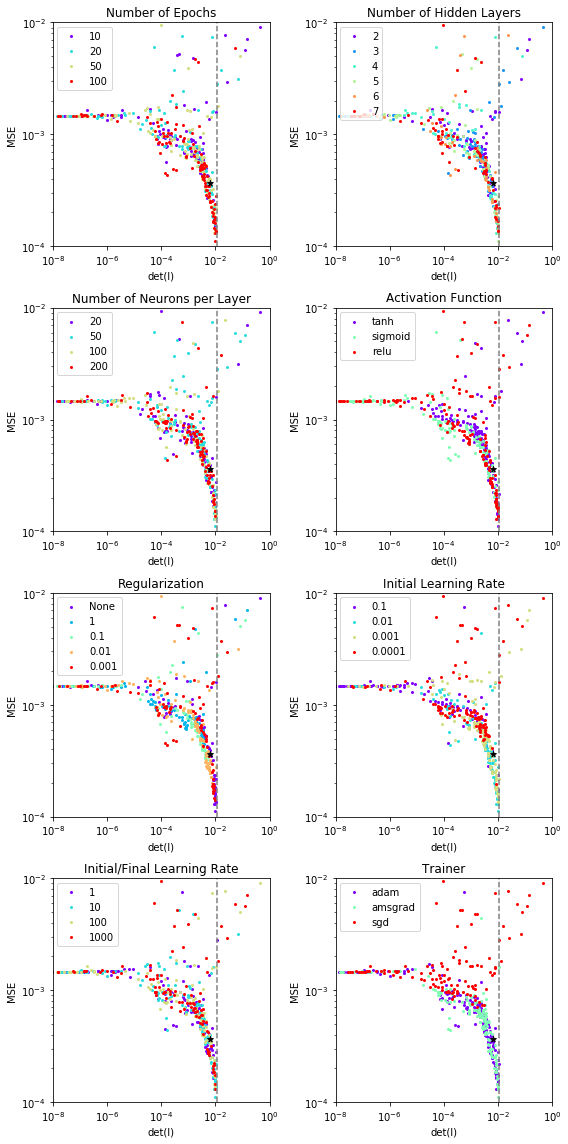

In [9]:
#######
#Truth FisherInfo
fi_truth , _= fisher.calculate_fisher_information_full_truth(theta=[0.,0.],luminosity=300*1000.)
fidet_truth=np.linalg.det(fi_truth)

#######
#Input Data
data = np.load(usesummaryfile)

#######
#List Manipulation
def sublist(inputlist, index, condition):
    outputlist=[]
    for ilist in range(len(inputlist)):
        if inputlist[ilist,index]==condition:
            outputlist.append(inputlist[ilist])
    return np.array(outputlist)

#######
#Figure
myrangex=[10**(-8),1]
myrangey=[10**(-4),.01]
mysize=4
f, ((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8)) = plt.subplots(4, 2)
f.set_size_inches(8,16)


# choices_epochs
mycolors = cm.rainbow(np.linspace(0, 1, len(choices_epochs)))
for i in range(len(choices_epochs)):
    thisdata=sublist(data,1,i)
    ax1.scatter(thisdata[:,9], thisdata[:,10],color=mycolors[i],s=mysize,alpha=1,label=str(choices_epochs[i]))
ax1.scatter(data[0,9], data[0,10],color='black',marker="*")
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('det(I)')
ax1.set_ylabel('MSE')
ax1.set_xlim(myrangex)
ax1.set_ylim(myrangey)
ax1.legend(bbox_to_anchor=(0.02, 0.98), loc=2, borderaxespad=0.)
ax1.set_title('Number of Epochs')
ax1.plot([fidet_truth,fidet_truth], myrangey, linestyle="--", color='gray')

# choices_nhidden
mycolors = cm.rainbow(np.linspace(0, 1, len(choices_nhidden)))
for i in range(len(choices_nhidden)):
    thisdata=sublist(data,2,i)
    ax2.scatter(thisdata[:,9], thisdata[:,10],color=mycolors[i],s=mysize,alpha=1,label=str(choices_nhidden[i]))
ax2.scatter(data[0,9], data[0,10],color='black',marker="*")
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel('det(I)')
ax2.set_ylabel('MSE')
ax2.set_xlim(myrangex)
ax2.set_ylim(myrangey)
ax2.legend(bbox_to_anchor=(0.02, 0.98), loc=2, borderaxespad=0.)
ax2.set_title('Number of Hidden Layers')
ax2.plot([fidet_truth,fidet_truth], myrangey, linestyle="--", color='gray')

# choices_nneuron
mycolors = cm.rainbow(np.linspace(0, 1, len(choices_nneuron)))
for i in range(len(choices_nneuron)):
    thisdata=sublist(data,3,i)
    ax3.scatter(thisdata[:,9], thisdata[:,10],color=mycolors[i],s=mysize,alpha=1,label=str(choices_nneuron[i]))
ax3.scatter(data[0,9], data[0,10],color='black',marker="*")
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_xlabel('det(I)')
ax3.set_ylabel('MSE')
ax3.set_xlim(myrangex)
ax3.set_ylim(myrangey)
ax3.legend(bbox_to_anchor=(0.02, 0.98), loc=2, borderaxespad=0.)
ax3.set_title('Number of Neurons per Layer')
ax3.plot([fidet_truth,fidet_truth], myrangey, linestyle="--", color='gray')

# choices_activation
mycolors = cm.rainbow(np.linspace(0, 1, len(choices_activation)))
for i in range(len(choices_activation)):
    thisdata=sublist(data,4,i)
    ax4.scatter(thisdata[:,9], thisdata[:,10],color=mycolors[i],s=mysize,alpha=1,label=str(choices_activation[i]))
ax4.scatter(data[0,9], data[0,10],color='black',marker="*")
ax4.set_yscale('log')
ax4.set_xscale('log')
ax4.set_xlabel('det(I)')
ax4.set_ylabel('MSE')
ax4.set_xlim(myrangex)
ax4.set_ylim(myrangey)
ax4.legend(bbox_to_anchor=(0.02, 0.98), loc=2, borderaxespad=0.)
ax4.set_title('Activation Function')
ax4.plot([fidet_truth,fidet_truth], myrangey, linestyle="--", color='gray')

# choices_regularization
mycolors = cm.rainbow(np.linspace(0, 1, len(choices_regularization)))
for i in range(len(choices_regularization)):
    thisdata=sublist(data,5,i)
    ax5.scatter(thisdata[:,9], thisdata[:,10],color=mycolors[i],s=mysize,alpha=1,label=str(choices_regularization[i]))
ax5.scatter(data[0,9], data[0,10],color='black',marker="*")
ax5.set_yscale('log')
ax5.set_xscale('log')
ax5.set_xlabel('det(I)')
ax5.set_ylabel('MSE')
ax5.set_xlim(myrangex)
ax5.set_ylim(myrangey)
ax5.legend(bbox_to_anchor=(0.02, 0.98), loc=2, borderaxespad=0.)
ax5.set_title('Regularization')
ax5.plot([fidet_truth,fidet_truth], myrangey, linestyle="--", color='gray')

# choices_learning
mycolors = cm.rainbow(np.linspace(0, 1, len(choices_lrinitial)))
for i in range(len(choices_lrinitial)):
    thisdata=sublist(data,6,i)
    ax6.scatter(thisdata[:,9], thisdata[:,10],color=mycolors[i],s=mysize,alpha=1,label=str(choices_lrinitial[i]))
ax6.scatter(data[0,9], data[0,10],color='black',marker="*")
ax6.set_yscale('log')
ax6.set_xscale('log')
ax6.set_xlabel('det(I)')
ax6.set_ylabel('MSE')
ax6.set_xlim(myrangex)
ax6.set_ylim(myrangey)
ax6.legend(bbox_to_anchor=(0.02, 0.98), loc=2, borderaxespad=0.)
ax6.set_title('Initial Learning Rate')
ax6.plot([fidet_truth,fidet_truth], myrangey, linestyle="--", color='gray')

# choices_learning
mycolors = cm.rainbow(np.linspace(0, 1, len(choices_lrratio)))
for i in range(len(choices_lrratio)):
    thisdata=sublist(data,7,i)
    ax7.scatter(thisdata[:,9], thisdata[:,10],color=mycolors[i],s=mysize,alpha=1,label=str(choices_lrratio[i]))
ax7.scatter(data[0,9], data[0,10],color='black',marker="*")
ax7.set_yscale('log')
ax7.set_xscale('log')
ax7.set_xlabel('det(I)')
ax7.set_ylabel('MSE')
ax7.set_xlim(myrangex)
ax7.set_ylim(myrangey)
ax7.legend(bbox_to_anchor=(0.02, 0.98), loc=2, borderaxespad=0.)
ax7.set_title('Initial/Final Learning Rate')
ax7.plot([fidet_truth,fidet_truth], myrangey, linestyle="--", color='gray')

# choices_trainer
mycolors = cm.rainbow(np.linspace(0, 1, len(choices_trainer)))
for i in range(len(choices_trainer)):
    thisdata=sublist(data,8,i)
    ax8.scatter(thisdata[:,9], thisdata[:,10],color=mycolors[i],s=mysize,alpha=1,label=str(choices_trainer[i]))
ax8.scatter(data[0,9], data[0,10],color='black',marker="*")
ax8.set_yscale('log')
ax8.set_xscale('log')
ax8.set_xlabel('det(I)')
ax8.set_ylabel('MSE')
ax8.set_xlim(myrangex)
ax8.set_ylim(myrangey)
ax8.legend(bbox_to_anchor=(0.02, 0.98), loc=2, borderaxespad=0.)
ax8.set_title('Trainer')
ax8.plot([fidet_truth,fidet_truth], myrangey, linestyle="--", color='gray')


#######
#Plot
plt.tight_layout()
plt.show()

In [7]:
#Get list of good settings
data_sort = data[data[:,10].argsort()[::1]][:5,:]

for i in range(len(data_sort)):
    print ('Setting with det(I)=',data_sort[i,9],'and MSE=',data_sort[i,10], 'had settings')
    print (' - Number of Epochs:',choices_epochs[int(data_sort[i,1])])
    print (' - Number of Hidden Layers:',choices_nhidden[int(data_sort[i,2])])
    print (' - Number of Neurons per Layer:',choices_nneuron[int(data_sort[i,3])])
    print (' - Activation Function:',choices_activation[int(data_sort[i,4])])
    print (' - Regularization Parameter:',choices_regularization[int(data_sort[i,5])])
    print (' - Initial Learning Rate:',choices_lrinitial[int(data_sort[i,6])])
    print (' - Final Learning Rate:',choices_lrinitial[int(data_sort[i,6])]/choices_lrratio[int(data_sort[i,7])])
    print (' - Trainer:',choices_trainer[int(data_sort[i,8])])
    print ('')

Setting with det(I)= 0.009877942648331861 and MSE= 0.00011168778742107451 had settings
 - Number of Epochs: 100
 - Number of Hidden Layers: 5
 - Number of Neurons per Layer: 50
 - Activation Function: tanh
 - Regularization Parameter: None
 - Initial Learning Rate: 0.01
 - Final Learning Rate: 0.001
 - Trainer: amsgrad

Setting with det(I)= 0.00873401503888327 and MSE= 0.0001297624638992898 had settings
 - Number of Epochs: 50
 - Number of Hidden Layers: 4
 - Number of Neurons per Layer: 50
 - Activation Function: relu
 - Regularization Parameter: None
 - Initial Learning Rate: 0.01
 - Final Learning Rate: 0.001
 - Trainer: adam

Setting with det(I)= 0.009853391781356241 and MSE= 0.00013008601953233182 had settings
 - Number of Epochs: 100
 - Number of Hidden Layers: 5
 - Number of Neurons per Layer: 100
 - Activation Function: tanh
 - Regularization Parameter: None
 - Initial Learning Rate: 0.01
 - Final Learning Rate: 1e-05
 - Trainer: amsgrad

Setting with det(I)= 0.0101557580123043